# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

## Introduction
- __Motivation__: The New York Workers’ Compensation Board (WCB) handles a vast number of workplace injury claims, which require timely and accurate decisions. Currently, manually reviewing these claims is both resource-intensive and time-consuming. An automated model could significantly expedite the decision-making process, improving efficiency and consistency in awarding compensation.
- __Dataset__: The dataset contains claims assembled by the WCB from the beginning of 2020 to the end of 2022, which serves as the training data. The test data comprises claims from January 2023 onward. Each claim includes various attributes such as injury details, claimant information, and associated codes that characterize the nature, cause, and affected body part of the injury. This comprehensive dataset enables the development of predictive models based on historical decisions.
- __Task and Goal__: The primary objective of this project is to develop and evaluate machine learning models that can accurately classify the WCB’s final decision on the type of injury for each claim (i.e., the "Claim Injury Type"). This involves creating a multiclass classification model to predict injury types based on the provided features, optimizing model performance, and assessing the importance of different features. The ultimate goal is to produce a model that can generalize well to unseen data, assisting the WCB in making faster, data-driven decisions on new claims.

| **ATTRIBUTE**                        | **DESCRIPTION**                                                                                                         |
|--------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| Accident Date                        | Injury date of the claim.                                                                                               |
| Age at Injury                        | Age of injured worker when the injury occurred.                                                                         |
| Alternative Dispute Resolution       | Adjudication processes external to the Board.                                                                           |
| Assembly Date                        | The date the claim was first assembled.                                                                                 |
| Attorney/Representative              | Is the claim being represented by an Attorney?                                                                          |
| Average Weekly Wage                  | The wage used to calculate workers’ compensation, disability, or Paid Leave wage replacement benefits.                  |
| Birth Year                           | The reported year of birth of the injured worker.                                                                       |
| C-2 Date                             | Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).              |
| C-3 Date                             | Date Form C-3 (Employee Claim Form) was received.                                                                       |
| Carrier Name                         | Name of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker's employer. |
| Carrier Type                         | Type of primary insurance provider responsible for providing workers’ compensation coverage.                            |
| Claim Identifier                     | Unique identifier for each claim, assigned by WCB.                                                                      |
| County of Injury                     | Name of the New York County where the injury occurred.                                                                  |
| COVID-19 Indicator                   | Indication that the claim may be associated with COVID-19.                                                              |
| District Name                        | Name of the WCB district office that oversees claims for that region or area of the state.                              |
| First Hearing Date                   | Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held. |
| Gender                               | The reported gender of the injured worker.                                                                              |
| IME-4 Count                          | Number of IME-4 forms received per claim. The IME-4 form is the “Independent Examiner’s Report of Independent Medical Examination” form. |
| Industry Code                        | NAICS code and descriptions are available at https://www.naics.com/search-naics-codes-by-industry/.                     |
| Industry Code Description            | 2-digit NAICS industry code description used to classify businesses according to their economic activity.               |
| Medical Fee Region                   | Approximate region where the injured worker would receive medical service.                                               |
| OIICS Nature of Injury Description   | The OIICS nature of injury codes & descriptions are available at https://www.bls.gov/iif/oiics_manual_2007.pdf.         |
| WCIO Cause of Injury Code            | The WCIO cause of injury codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.  |
| WCIO Cause of Injury Description     | See description of field above.                                                                                         |
| WCIO Nature of Injury Code           | The WCIO nature of injury are available at https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.                     |
| WCIO Nature of Injury Description    | See description of field above.                                                                                         |
| WCIO Part Of Body Code               | The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.      |
| WCIO Part Of Body Description        | See description of field above.                                                                                         |
| Zip Code                             | The reported ZIP code of the injured worker’s home address.                                                             |
| Agreement Reached                    | Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.    |
| WCB Decision                         | Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim. |
| Claim Injury Type                    | Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.   |


## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
&nbsp;&nbsp;&nbsp;[1.1 Import the Needed Libraries](#import_libaries) <br>
&nbsp;&nbsp;&nbsp;[1.2 Read the Data and First Overview](#read_data) <br>
[2. Data Understanding and Exploration](#dataunderstand) <br>
&nbsp;&nbsp;&nbsp;[2.1 Target Variable Analysis](#target) <br>
&nbsp;&nbsp;&nbsp;[2.2 Data Anomalies and Inconsistencies](#anomalies) <br>
&nbsp;&nbsp;&nbsp;[2.3 Data Codes to Descriptions Analysis](#data_codes) <br>
[3. Data Cleaning and Pre-processing](#dataclean) <br>
&nbsp;&nbsp;&nbsp;[3.1 Train-Validation Split](#train_val_split) <br>
&nbsp;&nbsp;&nbsp;[3.2 Imputations](#imputations) <br>
&nbsp;&nbsp;&nbsp;[3.3 Outliers Handling](#outliers_handling) <br>
&nbsp;&nbsp;&nbsp;[3.4 Binning and Feature Extraction](#binning) <br>
&nbsp;&nbsp;&nbsp;[3.5 Encoding and Data Scaling](#encoding) <br>
[4. Feature Selection](#features) <br>
[5. Modeling and Evaluation](#modeling) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the Needed Libraries <a id='import_libaries'></a>

In [1]:
import numpy as np #to efficiently compute functions
import pandas as pd #to work with data frames
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile #to open zipfile
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 60)
from scipy.stats import mode

# data partition
from sklearn.model_selection import train_test_split


# Pre-processing missing values
from sklearn.experimental import enable_iterative_imputer  # Needed to use IterativeImputer
from sklearn.impute import IterativeImputer

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV

# encoding and scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# model assessment
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### 1.2 Read the Data and First Overview <a id='read_data'></a>
[to the top](#top)

In [2]:
train_zip_path = 'train_data.csv.zip'
test_zip_path = 'test_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df = read_zipped_csv(train_zip_path)
test_df = read_zipped_csv(test_zip_path)

In [3]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [4]:
test_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
0,2022-12-24,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,6165911,BRONX,N,NYC,NaN,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1
1,2022-11-20,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,1A. PRIVATE,6166141,QUEENS,N,NYC,NaN,F,NaN,45.0,RETAIL TRADE,IV,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1
2,2022-12-26,59,N,2023-01-02,N,0.0,1963.0,2022-12-31,NaN,AMGUARD INSURANCE COMPANY,1A. PRIVATE,6165907,WESTCHESTER,N,NYC,NaN,F,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,III,NaN,68.0,STATIONARY OBJECT,49.0,SPRAIN OR TEAR,62.0,BUTTOCKS,10604,0
3,2022-12-28,55,N,2023-01-02,N,0.0,0.0,2023-01-02,NaN,INDEMNITY INS. OF N AMERICA,1A. PRIVATE,6166047,QUEENS,N,NYC,NaN,F,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,25.0,FROM DIFFERENT LEVEL (ELEVATION),10.0,CONTUSION,53.0,KNEE,11411,6
4,2022-12-20,25,N,2023-01-02,N,0.0,1997.0,2022-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,6166102,KINGS,N,NYC,NaN,M,NaN,55.0,MANAGEMENT OF COMPANIES AND ENTERPRISES,IV,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,40.0,LACERATION,37.0,THUMB,11212,5


## 2. Data Understanding and Exploration <a id='dataunderstand'></a>
[to the top](#top)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [6]:
# Have a first look at the numerical variables and their distirbutions
train_df.describe()

,Age at Injury,Average Weekly Wage,Birth Year,Claim Identifier,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,574026.000000,5.453750e+05,544948.000000,5.934710e+05,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,42.114270,4.910883e+02,1886.767604,2.366760e+07,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
std,14.256432,6.092918e+03,414.644423,1.079271e+08,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801
min,0.000000,0.000000e+00,0.000000,5.393066e+06,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,31.000000,0.000000e+00,1965.000000,5.593414e+06,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,42.000000,0.000000e+00,1977.000000,5.791212e+06,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,54.000000,8.410000e+02,1989.000000,5.991000e+06,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,117.000000,2.828079e+06,2018.000000,9.998917e+08,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000


In [7]:
# Have a first look at the categorical variables and their distirbutions
train_df.describe(include='O')

,Accident Date,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,570337,574026,593471,574026,559466,187245,574026,574026,574026,574026,574026,574026,150798,574026,564068,574026,558386,558369,556944,545389,574026
unique,5539,3,1096,2,2475,1648,2046,8,8,63,2,8,1094,4,20,5,74,56,54,10060,1
top,2020-03-01,N,2020-03-06,N,2021-05-11,2021-04-21,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,2022-04-15,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,1245,571412,1422,392291,1847,350,111144,285368,291078,60430,546505,270779,440,335218,114339,265981,46610,153373,51862,3302,574026


In [8]:
# before working on the dataset, we will do a copy so we can use the original one if we need it
train_df_temp = train_df.copy()

### 2.1 __Target Variable__ Analysis <a id='target'></a>
[to the top](#top)

We just have a look at the distribution of the target variable 'Claim Injury Type'. To check how our dataset is balanced.

In [9]:
train_df_temp['Claim Injury Type'].value_counts()

Claim Injury Type
2. NON-COMP        291078
4. TEMPORARY       148507
3. MED ONLY         68906
5. PPD SCH LOSS     48280
1. CANCELLED        12477
6. PPD NSL           4211
8. DEATH              470
7. PTD                 97
Name: count, dtype: int64

In [10]:
non_comp_percent = round(train_df_temp['Claim Injury Type'].value_counts().max() / len(train_df_temp),4)

print('Percentage of Non-Comp Cases: {}%'.format(non_comp_percent*100))

Percentage of Non-Comp Cases: 49.05%


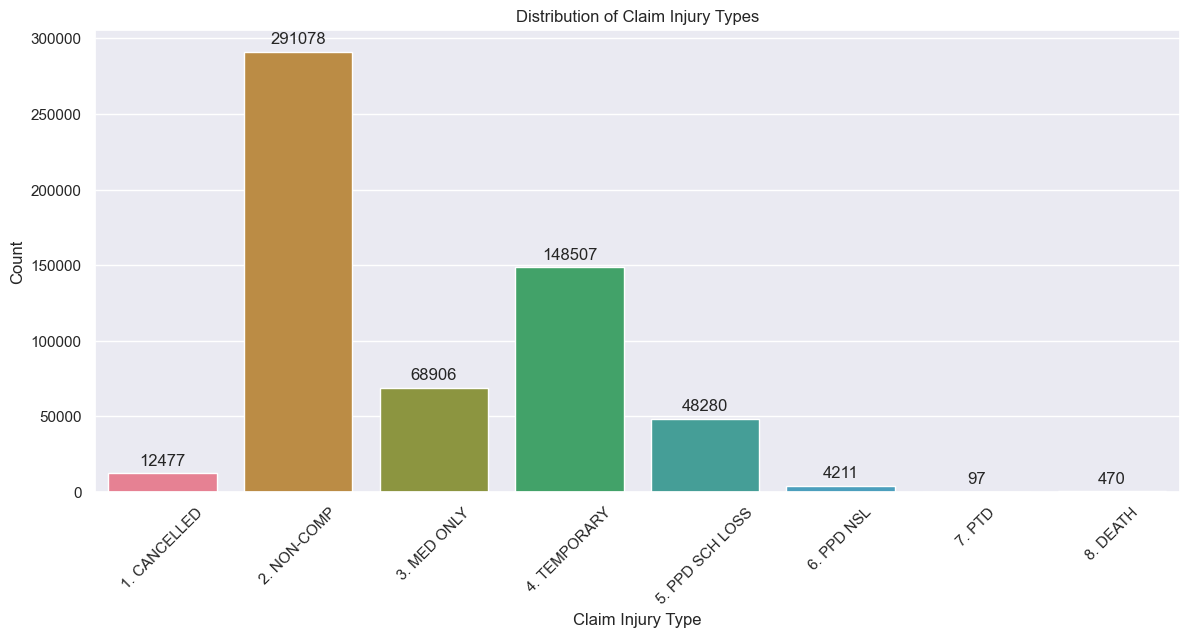

In [11]:
# Define the custom order for 'Claim Injury Type'
custom_order = ['1. CANCELLED', '2. NON-COMP', '3. MED ONLY', '4. TEMPORARY',
                '5. PPD SCH LOSS', '6. PPD NSL', '7. PTD', '8. DEATH']

# Plot distribution of target values with the custom order
target_values = train_df_temp['Claim Injury Type'].value_counts()

# Convert target values to a DataFrame and reorder based on custom order
df_target_counts = target_values.reset_index()
df_target_counts.columns = ['Claim Injury Type', 'Count']
df_target_counts = df_target_counts.set_index('Claim Injury Type').reindex(custom_order).reset_index()

plt.figure(figsize=(14, 6))
# Use a color palette to assign different colors to each bar
palette = sns.color_palette("husl", len(df_target_counts))
barplot = sns.barplot(x='Claim Injury Type', y='Count', data=df_target_counts, palette=palette, order=custom_order)

# Annotate the counts on top of each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

plt.title('Distribution of Claim Injury Types')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

We can see that we have 7 different classes. One class, "NON-COMP", is very dominantly present with making up for 49.05% of the cases.

Let's have an initial look at the spearman correlation of the target variable with the other features: 

We use spearman correlation because we suspect that the relationship between our variables and target is non-linear, and also because our data contains outliers that can distort the analysis. Also, our data violate the assumptions of linearity and don't follow a normal distribtuion so spearman correlation is more adequate here. Also, despite the fact that our data is not ordinal we decide it to visualize its distribution in an ordinal way because we know that from 1 to 8 , it's the scale of the severity of the injury , and thus the compensations are ordered in severity order.

Spearman Correlations with 'Claim Injury Type Numeric':
Claim Injury Type Numeric             1.000000
Average Weekly Wage                   0.855234
Agreement Reached                     0.235905
Age at Injury                         0.118533
Industry Code                         0.028782
WCIO Nature of Injury Code            0.023586
WCIO Part Of Body Code                0.000096
Number of Dependents                 -0.000625
IME-4 Count                          -0.007009
WCIO Cause of Injury Code            -0.039392
Birth Year                           -0.084158
Claim Identifier                     -0.154982
OIICS Nature of Injury Description         NaN
Name: Claim Injury Type Numeric, dtype: float64


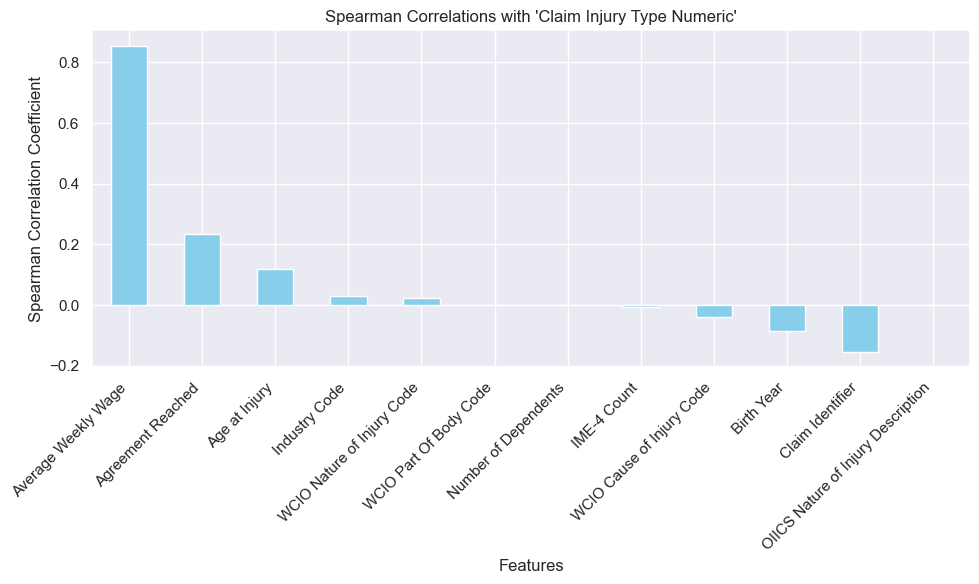

In [12]:
# Convert 'Claim Injury Type' to numeric if not already done
train_df_temp['Claim Injury Type Numeric'] = train_df_temp['Claim Injury Type'].astype('category').cat.codes

# Select only numeric columns
numeric_cols = train_df_temp.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
spearman_corr = numeric_cols.corr(method='spearman')

# Display correlations with the target variable 'Claim Injury Type Numeric'
target_correlations = spearman_corr['Claim Injury Type Numeric'].sort_values(ascending=False)

# Print the correlations
print("Spearman Correlations with 'Claim Injury Type Numeric':")
print(target_correlations)

# Plot the correlations as a bar chart for better visualization
plt.figure(figsize=(10, 6))
target_correlations.drop('Claim Injury Type Numeric').plot(kind='bar', color='skyblue')
plt.title("Spearman Correlations with 'Claim Injury Type Numeric'")
plt.ylabel("Spearman Correlation Coefficient")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1. Strongest correlations: 

Average Weekly Wage has the highest positive correlation with the target (0.855), suggesting that there may be a strong monotonic relationship between the weekly wage and the type of claim injury.

2. Moderate Correlations:

Agreement Reached shows a moderate positive correlation (0.236), indicating that cases where an agreement was reached may be related to specific types of claim injuries.

Age at Injury has a weaker positive correlation (0.119), implying a slight relationship between age and the type of claim injury.

3. Minimal correlations:

Industry Code, WCIO Nature of Injury Code, WCIO Part Of Body Code, and Number of Dependents , Claim Identifier and Birth Year , WCIO Cause of Injury Code

So lets have a look at the features itself.

__Age at Injury__

In [13]:
train_df_temp['Age at Injury'].describe()

count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64

We can already see that the minimum and maximum values seem kind of strang with ranging from 0 to 117. We will deal with them in the outlier section.

In [14]:
# plot the distribution of a single feature with respect to the target categorical variable.
def feature_distribution(data, feature, target_variable):
    plt.figure(figsize=(13, 8))
    sns.histplot(data=data, x=feature, hue=target_variable, multiple="stack")
    plt.title(f'Distribution of {feature}', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()


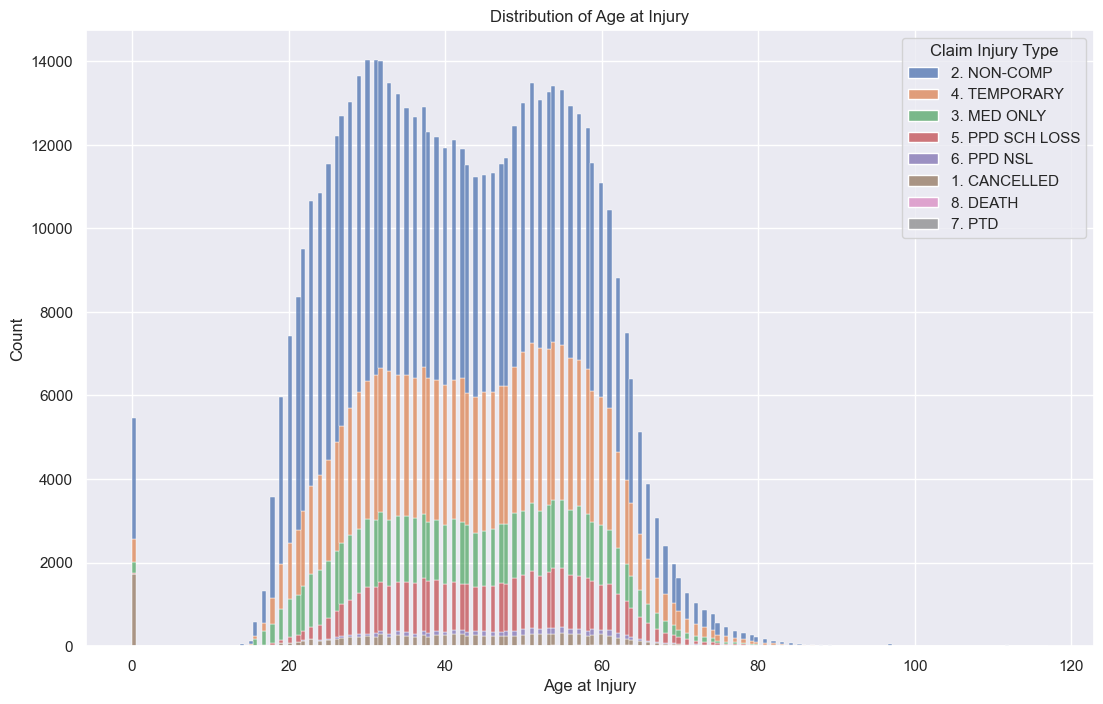

In [15]:
feature_distribution(train_df_temp, 'Age at Injury', 'Claim Injury Type')

Some conclusions on the distribution of the claim injury type related to the age can already be seen:

1. The 2. NON-COMP claim type is the most prevalent across all age groups, indicating that non-compensable cases are frequent regardless of age

2. The distribution is most concentrated between the ages of approximately 20 and 60, suggesting that most injury claims occur within the working-age population.

3. The number of claims decreases significantly for ages above 60 and below 20, indicating fewer injury claims for younger and older individuals

4. The 8. DEATH and 7. PTD (permanent total disability) claim types appear infrequently, showing they are relatively rare outcomes.

5. There is a noticeable spike in 2. NON-COMP claims for very young ages (below 20), which might indicate special cases, data anomalies, or claims related to youth employment or specific circumstances.


### 2.2 Data __Anomalies__ and __Inconsistencies__ <a id='anomalies'></a>
[to the top](#top)

Missing values analysis

In [16]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(train_df_temp)

Your selected dataframe has 34 columns.
There are 31 columns that have missing values.


In [17]:
missing_values.head(15)

,Missing Values,% of Total Values
OIICS Nature of Injury Description,593471,100.0
IME-4 Count,460668,77.6
First Hearing Date,442673,74.6
C-3 Date,406226,68.4
Birth Year,48523,8.2
Average Weekly Wage,48096,8.1
Zip Code,48082,8.1
WCIO Part Of Body Description,36527,6.2
WCIO Part Of Body Code,36527,6.2
WCIO Nature of Injury Description,35102,5.9


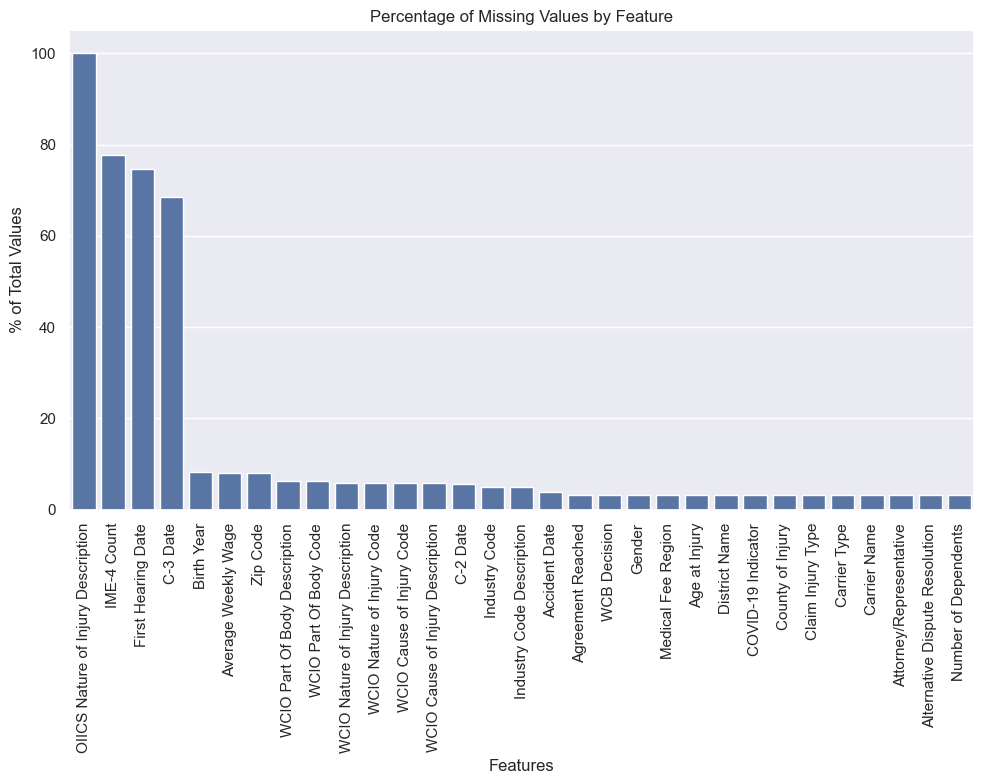

In [18]:
def plot_missing_values(mis_val_table, title):
    plt.figure(figsize=(10, 8))
    
    # Create a bar plot for the percentage of missing values
    sns.barplot(x=mis_val_table.index, 
                y=mis_val_table['% of Total Values'])
    
    # Rotate the x labels for better readability
    plt.xticks(rotation=90)
    
    # Set plot labels and title
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('% of Total Values')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the missing values
plot_missing_values(missing_values,title= 'Percentage of Missing Values by Feature')

These colums are the ones that have lots of missing values so we'll have to address them in the later section of pre-processing and data cleaning.

* OIICS Nature of Injury Description:		100.0 % 

* IME-4 Count:		77.6%

* First Hearing Date:	74.6%

* C-3 Date:		68.4% 

Null values analysis

In [19]:
# Function to calculate zero values by column
def zero_values_table(df):
    # Total zero values
    zero_val = (df == 0).sum()
    
    # Percentage of zero values
    zero_val_percent = 100 * (df == 0).sum() / len(df)
    
    # Make a table with the results
    zero_val_table = pd.concat([zero_val, zero_val_percent], axis=1)
    
    # Rename the columns
    zero_val_table_ren_columns = zero_val_table.rename(
        columns={0: 'Zero Values', 1: '% of Total Values'})
    
    # Sort the table by percentage of zero values in descending order
    zero_val_table_ren_columns = zero_val_table_ren_columns[
        zero_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
    # Print summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
          "There are " + str(zero_val_table_ren_columns.shape[0]) +
          " columns that have zero values.")
    
    # Return the dataframe with zero values information
    return zero_val_table_ren_columns


zero_values = zero_values_table(train_df_temp)

Your selected dataframe has 34 columns.
There are 6 columns that have zero values.


In [20]:
zero_values.head(15)

# The column Agreement Date has a high percentage of zero values because it's a binary feature and thus being equal to 0 means no Agreement Reached.

,Zero Values,% of Total Values
Agreement Reached,547239,92.2
Average Weekly Wage,335450,56.5
Number of Dependents,81665,13.8
Birth Year,25081,4.2
Claim Injury Type Numeric,12477,2.1
Age at Injury,5464,0.9


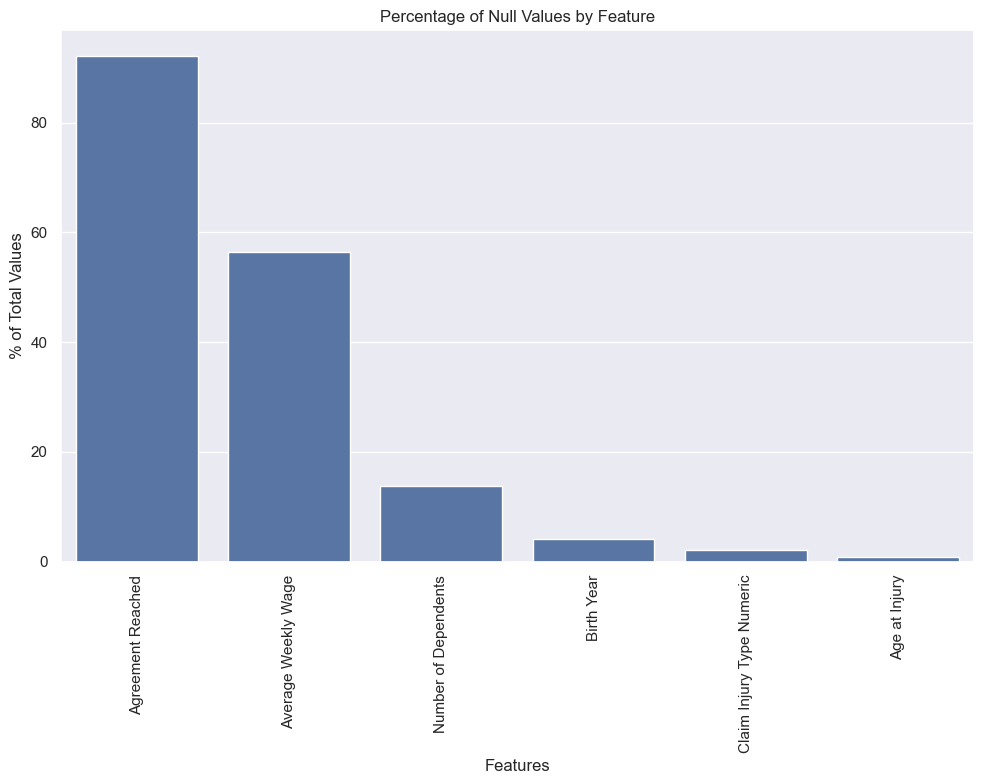

In [21]:
plot_missing_values(zero_values,title='Percentage of Null Values by Feature')

These colums are the ones that have lots of null values so we'll have to address them in the later section of pre-processing and data cleaning.

* (The column Agreement Date has a high percentage of zero values because it's a binary feature and thus being equal to 0 means no Agreement Reached)

* Average Weekly Wage:	56.5 % 

* Number of Dependents:	13.8% 

Individual Feature Analysis

In [22]:
# First, split the features into numerical and categorical

# Select numerical columns
numerical_cols = train_df_temp.select_dtypes(include=[np.number])

# Select categorical columns
categorical_cols = train_df_temp.select_dtypes(include=[object])

In [23]:
def numerical_describe(df, numerical_col):
    # Check if the column in the DataFrame is numerical
    if np.issubdtype(df[numerical_col].dtype, np.number):
        return df[numerical_col].describe()
    else:
        return None

# Iterate over the list of numerical columns
for col in numerical_cols:
    print(f"Description for column {col}:\n")
    description = numerical_describe(train_df_temp, col)
    if description is not None:
        print(description)
    else:
        print(f"Column {col} is not numerical.\n")

Description for column Age at Injury:

count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Description for column Average Weekly Wage:

count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Description for column Birth Year:

count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64
Description for column Claim Identifier:

count    5.934710e+05
mean     2.366760e+07
std      1.079271e+08
min      5.393066e+06
25%      5.593414e+06
50%      5.791212e+06
75%      5.991000e+06
max      9.998917e+08
Name: C

### Summary from Individual Feature Analysis:

#### Key Points:

- **Age at Injury**: Min = 0 (missing/incorrect data), Max = 117 (possible outlier).
- **Average Weekly Wage**: Min = 0 (unreported/missing), Max = 2,828,079 (extreme outlier; 75th percentile = 841).
- **Birth Year**: Min = 0 (erroneous), Max = 2018 (unrealistic), Mean = 1886.77 (outliers likely).
- **Claim Identifier**: High variability, broad range, potentially expected as an identifier.
- **IME-4 Count**: Max = 73, indicating outliers beyond the 75th percentile of 4.
- **OIICS Nature of Injury**: Missing entirely; may need imputation/removal.
- **WCIO Part Of Body Code**: Min = -9 (data error).
- **Agreement Reached**: Mean = 4.67% of cases; shows class imbalance.
- **Number of Dependents**: Max = 6 (reasonable, needs context verification).
- **Claim Injury Type Numeric**: Min = -1 (error), 75th percentile = 3, Max = 7 (varied types, needs review).








In [24]:
def categorical_describe(df, categorical_col):
    # Check if the column in the DataFrame is categorical
    if df[categorical_col].dtype == 'object' or df[categorical_col].dtype.name == 'category':
        description = df[categorical_col].describe()
        return description
    else:
        return None

# Iterate over the list of categorical columns
for col in categorical_cols:
    print(f"Description for column {col}:\n")
    description = categorical_describe(train_df_temp, col)
    if description is not None:
        print(description)
    else:
        print(f"Column {col} is not categorical.\n")

Description for column Accident Date:

count         570337
unique          5539
top       2020-03-01
freq            1245
Name: Accident Date, dtype: object
Description for column Alternative Dispute Resolution:

count     574026
unique         3
top            N
freq      571412
Name: Alternative Dispute Resolution, dtype: object
Description for column Assembly Date:

count         593471
unique          1096
top       2020-03-06
freq            1422
Name: Assembly Date, dtype: object
Description for column Attorney/Representative:

count     574026
unique         2
top            N
freq      392291
Name: Attorney/Representative, dtype: object
Description for column C-2 Date:

count         559466
unique          2475
top       2021-05-11
freq            1847
Name: C-2 Date, dtype: object
Description for column C-3 Date:

count         187245
unique          1648
top       2021-04-21
freq             350
Name: C-3 Date, dtype: object
Description for column Carrier Name:

count       

### Summary from Individual Categorical Feature Analysis:

#### Key Points from Categorical Analysis:

- **Accident Date**: High count (570,337) and variety (5,539 unique dates), with the most frequent date being 2020-03-01 (1,245 times).

- **Alternative Dispute Resolution**: Predominantly 'N' (571,412 out of 574,026), indicating limited use of this option.

- **Assembly Date**: Complete data (593,471), with 1,096 unique dates. Most frequent date: 2020-03-06 (1,422 times).

- **Attorney/Representative**: Majority response is 'N' (392,291 out of 574,026), showing fewer cases with attorney involvement.

- **C-2 Date**: Well-populated (559,466) with 2,475 unique values. Top date: 2021-05-11 (1,847 times).

- **C-3 Date**: Lower count (187,245), indicating many missing values. Top date: 2021-04-21 (350 times).

- **Carrier Name**: Complete data (574,026) with high diversity (2,046 unique). Most frequent: STATE INSURANCE FUND (111,144 times).

- **Carrier Type**: Predominantly '1A. PRIVATE' (285,368 out of 574,026).

- **Claim Injury Type**: Common type is '2. NON-COMP' (291,078 times).

- **County of Injury**: Widely varied (63 unique), with Suffolk being the most common (60,430 times).

- **COVID-19 Indicator**: Predominantly 'N' (546,505 out of 574,026).

- **District Name**: Most cases handled in NYC (270,779 times).

- **First Hearing Date**: Lower count (150,798) with varied dates. Top date: 2022-04-15 (440 times).

- **Gender**: Majority male (335,218 out of 574,026).

- **Industry Code Description**: Common in 'HEALTH CARE AND SOCIAL ASSISTANCE' (114,339 times).

- **Medical Fee Region**: Dominated by Region IV (265,981 times).

- **WCIO Cause of Injury Description**: Most common cause: 'LIFTING' (46,610 times).

- **WCIO Nature of Injury Description**: Predominantly 'STRAIN OR TEAR' (153,373 times).

- **WCIO Part Of Body Description**: Most common part affected is 'LOWER BACK AREA' (51,862 times).

- **Zip Code**: High diversity (10,060 unique). Most frequent: 11236 (3,302 times).

- **WCB Decision**: Uniform value ('Not Work Related') across all records (574,026 times).


#### Visual Data Analysis for Numerical Features after describing them

In [ ]:
# Plot boxplots for all numerical features in a compact manner
num_cols_count = len(numeric_cols.columns)

# Apply log transformation to variables with extreme scales to improve visualization
numeric_cols_log = numeric_cols.copy()
for col in numeric_cols_log.columns:
    if numeric_cols_log[col].max() > 1000:  # Apply to columns with high values
        numeric_cols_log[col] = np.log1p(numeric_cols_log[col])  # log1p to handle zero values safely

# Plot boxplots for the log-transformed numerical features
plt.figure(figsize=(20, 10))  # Adjust size for better readability
sns.boxplot(data=numeric_cols_log)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplots of Log-Transformed Numerical Features')
plt.tight_layout()
plt.show()

### Observations from Boxplots of Log-Transformed Numerical Features:

1. **Age at Injury**:
   - Wide spread with outliers extending past 100, indicating variability in the data and potential outliers at older ages.

2. **Average Weekly Wage**:
   - Compact distribution with some outliers. Also, > 50% of the values are 0 so we'll have to take that into account


3. **Birth Year**:
   - Narrow range with a few outliers, which could indicate data entry errors or edge cases (e.g., very low or high years).

4. **Claim Identifier**:
   - Tight distribution, suggesting it is likely an ID rather than a useful variable for analysis. Outliers could represent different data entry segments.

5. **IME-4 Count**:
   - Many outliers present, indicating that while most counts are low, there are some significantly higher values.

6. **Industry Code**:
   - Relatively even distribution with few outliers, suggesting a spread across different codes.

7. **WCIO Codes (Cause, Nature, Part of Body)**:
   - Moderate spread with some outliers, indicating variability in reported injury data.

8. **Agreement Reached**:
   - Minimal spread, confirming that it is a binary var. or, with only a few outliers.

9. **Number of Dependents**:
   - Narrow range with a few outliers, indicating most values cluster tightly with some higher counts.

10. **Claim Injury Type Numeric (Target Var.)**:
    - Tight distribution with a few outliers, indicating that most data points fall within a small range but some deviations exist.
    - Given the class distribution analysis shown in the bar chart, it's clear that most instances are concentrated in a few categories, which aligns with the narrow spread observed in the boxplot.
    - The presence of outliers could represent rarer claim types, which may be difficult for models to predict due to limited examples in these categories.


#### Individual Analysis in Numerical Features

Analysis in the numerical variables that left (Age at Injury, Avg. Weekly Wage, Claim identifier, IME-4 Count, Nr. of Dependents)

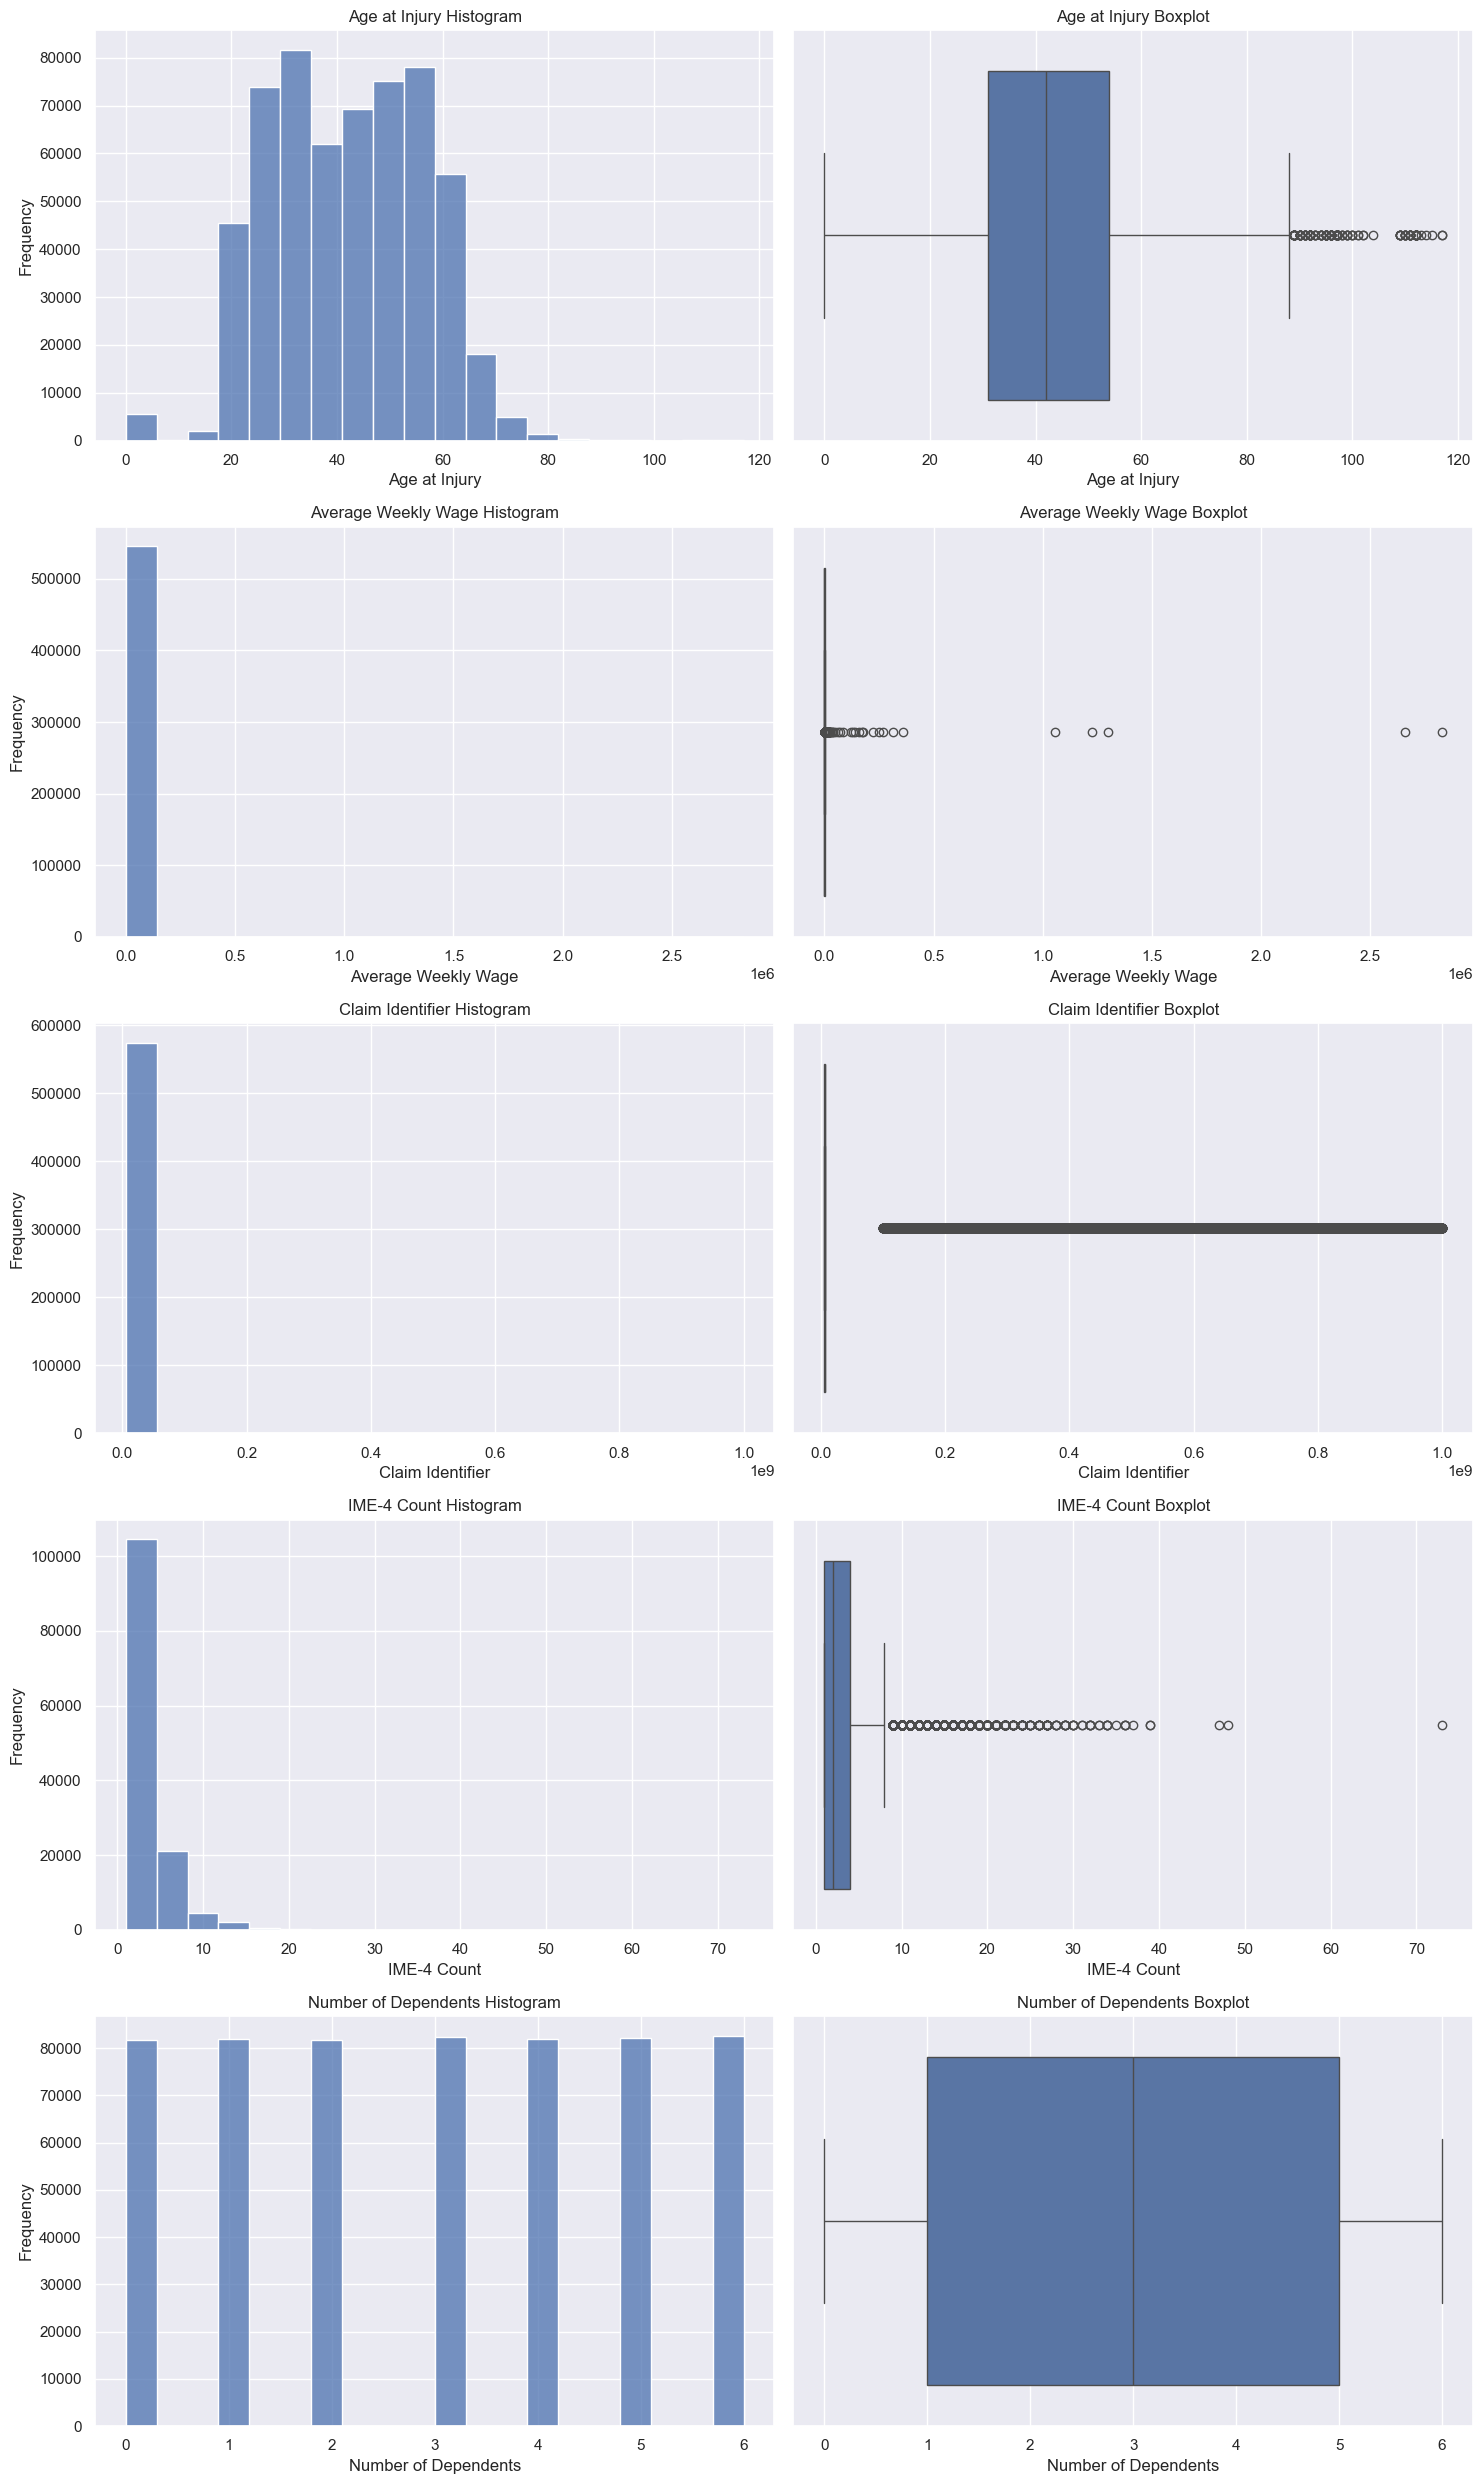

In [ ]:
subset_numerical = train_df_temp[['Age at Injury', 'Average Weekly Wage', 
       'Claim Identifier', 'IME-4 Count',
       'Number of Dependents']].select_dtypes(include=[np.number])

# Create subplots for each numerical variable
n_vars = len(subset_numerical.columns)
fig, axes = plt.subplots(n_vars, 2, figsize=(15, 5*n_vars))

# Create histogram and boxplot for each variable
for i, col in enumerate(subset_numerical.columns):
    # Histogram
    sns.histplot(data=train_df_temp, x=col, bins=20, kde=False, ax=axes[i,0])
    axes[i,0].set_title(f'{col} Histogram')
    axes[i,0].set_xlabel(col)
    axes[i,0].set_ylabel('Frequency')
    
    # Boxplot
    sns.boxplot(data=train_df_temp, x=col, ax=axes[i,1])
    axes[i,1].set_title(f'{col} Boxplot')
    axes[i,1].set_xlabel(col)

# Adjust layout
plt.tight_layout()
plt.show()


1. **Age at Injury**:
   - **Histogram**: The distribution shows that most cases are clustered around ages 20–50, indicating that the majority of injuries occur in working-age adults.
   - **Boxplot**: There are some outliers above 60, suggesting that injuries among older individuals are less common but do occur.

2. **Average Weekly Wage**:
   - **Histogram**: The distribution appears highly skewed, with most data points concentrated at lower values, potentially indicating the prevalence of lower wage cases.
   - **Boxplot**: A significant number of extreme outliers, suggesting that while most wages are on the lower end, there are occasional cases with exceptionally high wages.

3. **Claim Identifier**:
   - **Histogram and Boxplot**: The distribution is highly uniform with minimal spread, indicating that this may be more of an identifier variable rather than an analytically meaningful one, so perhaps
   this variable can be droped or used as an index for each claim.

4. **IME-4 Count**:
   - **Histogram**: Shows that most cases have an IME-4 count of 0-5, with very few going beyond this range.
   - **Boxplot**: Highlights the presence of outliers, indicating that some claims have a notably higher number of IME-4 counts.

5. **Number of Dependents**:
   - **Histogram**: The distribution is fairly uniform, suggesting that the number of dependents varies widely without a clear trend.
   - **Boxplot**: A wider interquartile range indicates variability, with no significant outliers.

#### Visual Data Analysis for Categorical Features after describing them

In [ ]:
categorical_cols.columns

Index(['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date',
       'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name',
       'Carrier Type', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision'],
      dtype='object')

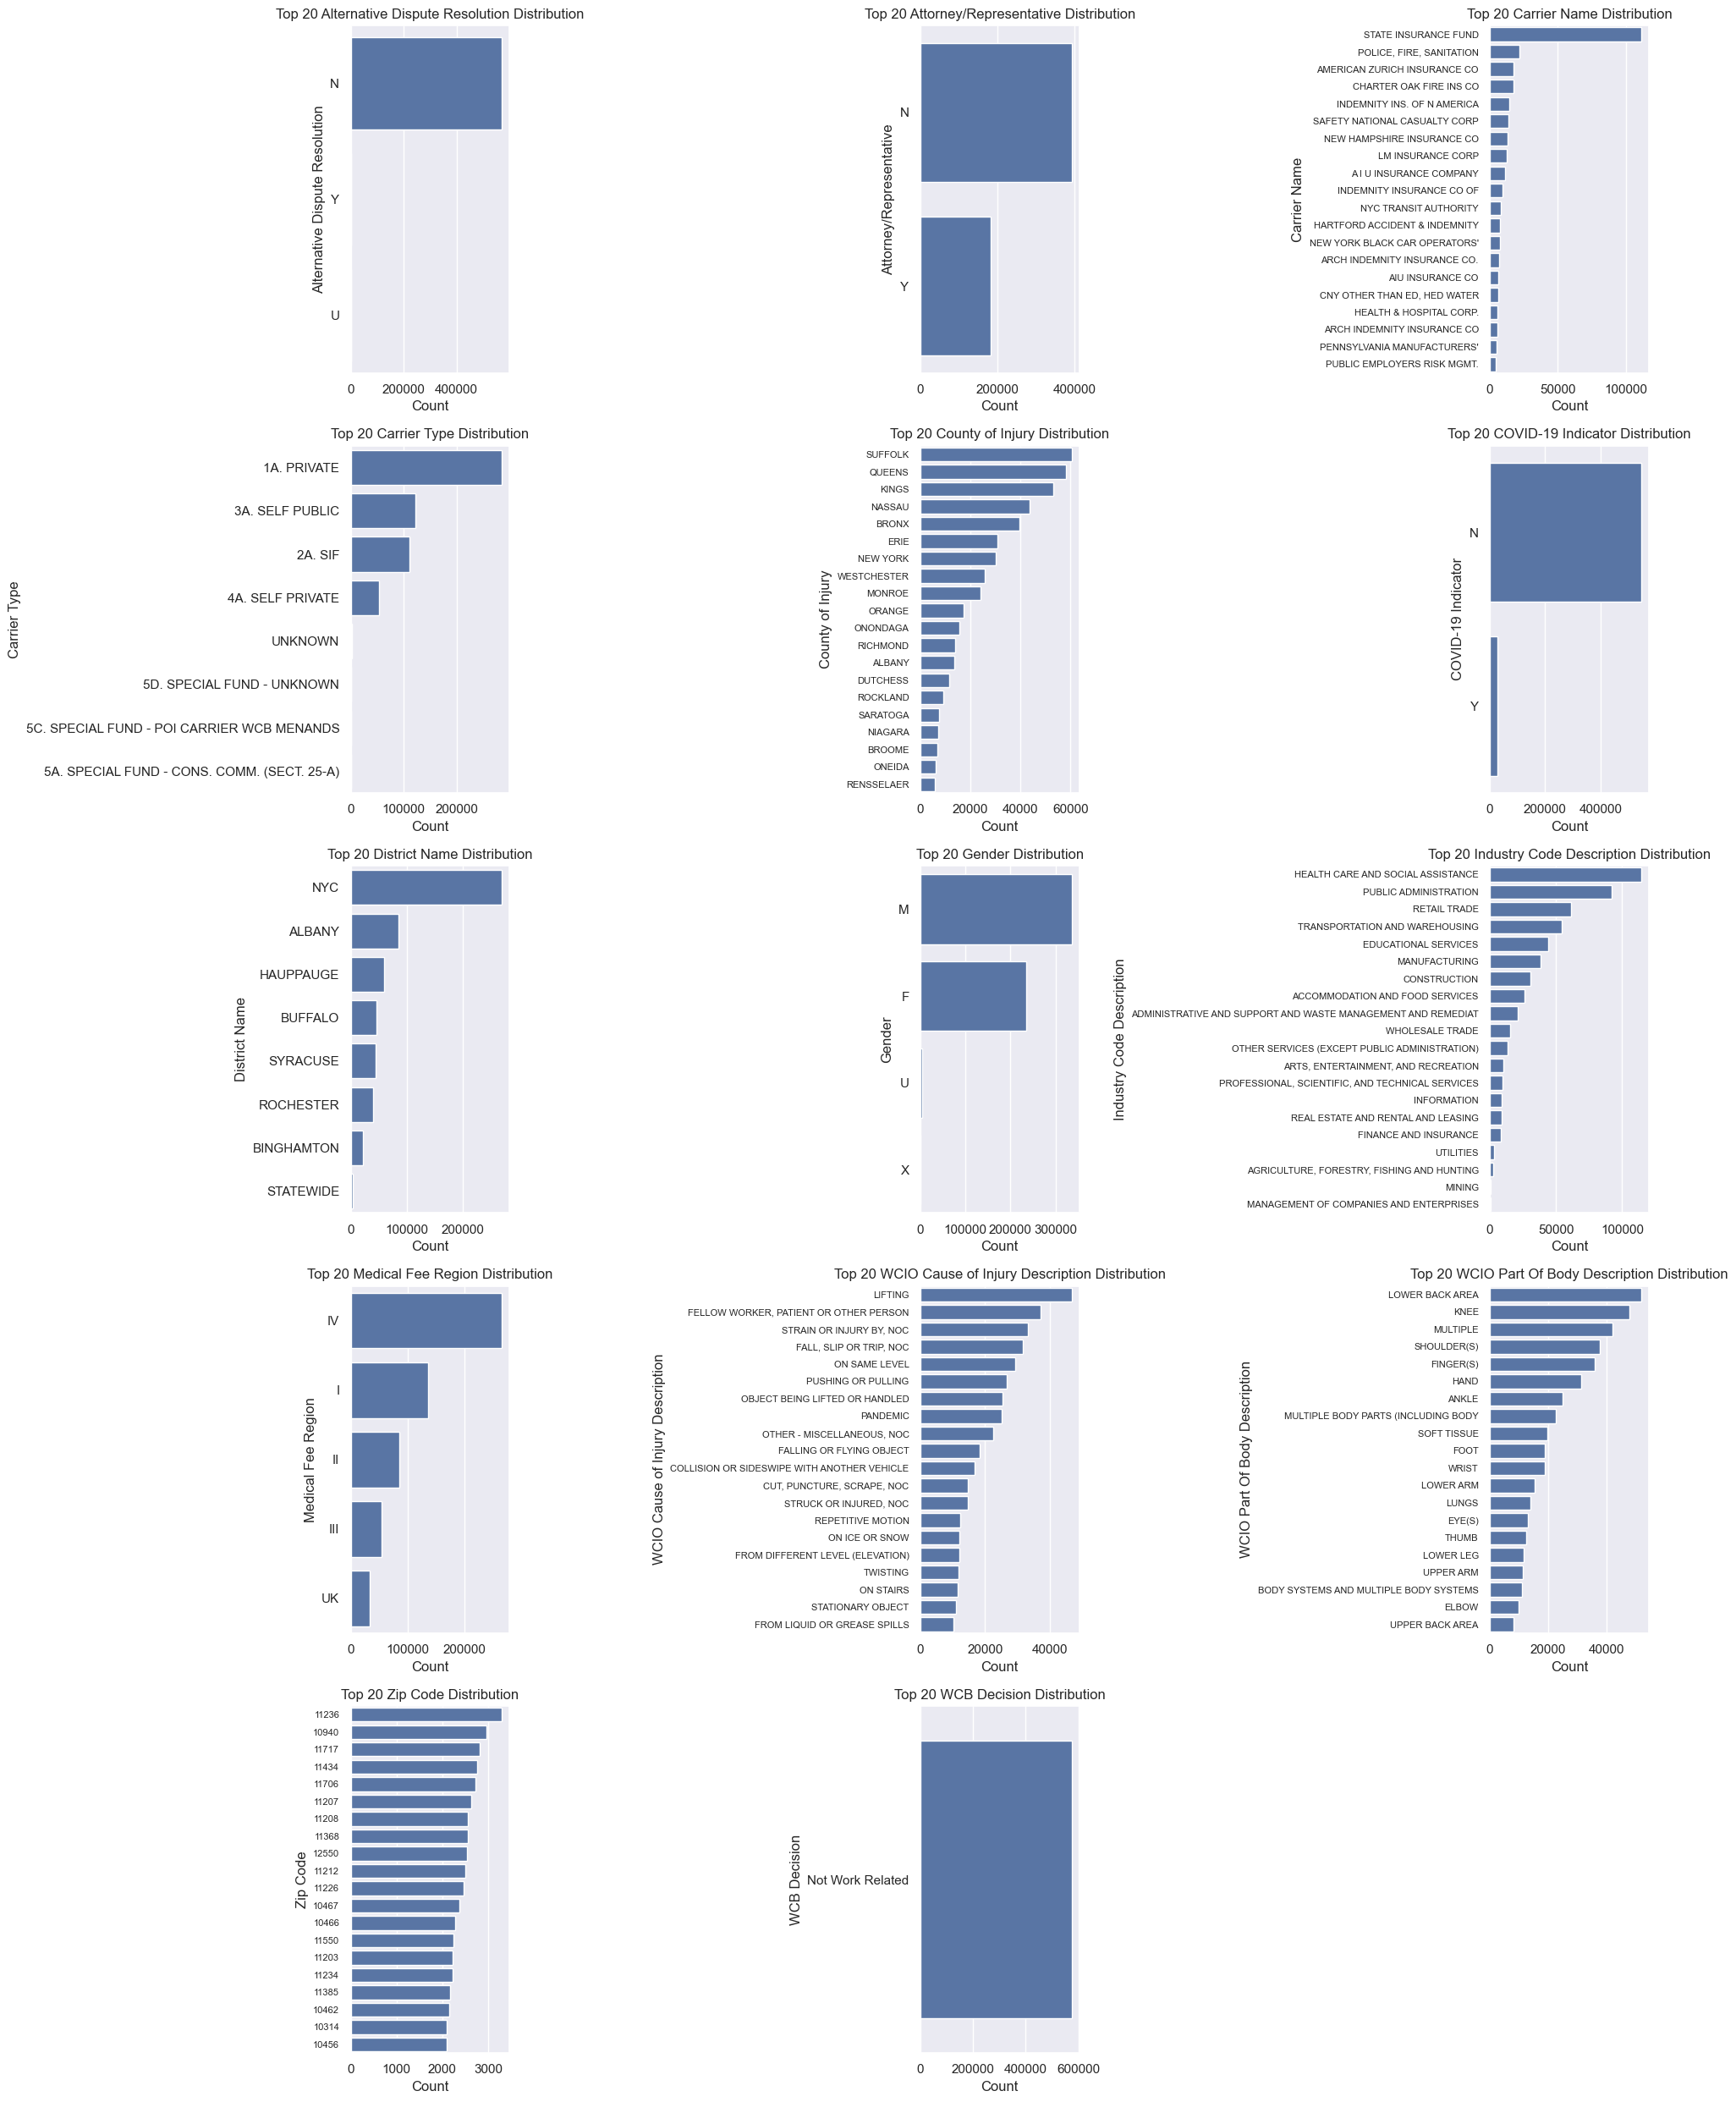

In [ ]:
# Subset of categorical columns , so that we don't have dates and other features that cannot be visualized in a countplot 

subset_categorical = train_df_temp[['Alternative Dispute Resolution',
       'Attorney/Representative', 'Carrier Name',
       'Carrier Type', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']].select_dtypes(include=[object])

# Calculate number of rows needed (3 plots per row)
n_vars = len(subset_categorical.columns)
n_rows = (n_vars // 3) + (1 if n_vars % 3 != 0 else 0)

# Create figure
plt.figure(figsize=(20, 5 * n_rows))

# Create countplot for each variable, limiting to top 20 categories where applicable
for i, col in enumerate(subset_categorical.columns, 1):
    top_20 = train_df_temp[col].value_counts().head(20).index
    filtered_data = train_df_temp[train_df_temp[col].isin(top_20)]
    
    plt.subplot(n_rows, 3, i)
    sns.countplot(data=filtered_data, y=col, order=top_20)
    plt.title(f'Top 20 {col} Distribution')
    plt.xlabel('Count')
    
    # Adjust tick labels if too long
    if train_df_temp[col].nunique() > 10:
        plt.tick_params(axis='y', labelsize=8)

# Adjust layout
plt.tight_layout()
plt.show()



1. **Alternative Dispute Resolution & Attorney/Representative**:
   - The vast majority of cases do not involve alternative dispute resolution or attorney representation, indicating that most claims may be handled without these aspects.

2. **Carrier Name & Carrier Type**:
   - A small subset of carrier names appears frequently, suggesting a concentration of claims among a few key carriers. The distribution of carrier types is dominated by 'Private' and 'Self-Public' types, with a significant number of claims from the 'SF' and 'Unknown' types as well.

3. **County of Injury**:
   - Injuries are spread across many counties, but a few counties, like Suffolk and Nassau, have significantly higher counts, indicating regional concentrations of claims.

4. **COVID-19 Indicator**:
   - Most claims do not have a COVID-19 indicator, suggesting that COVID-19-related claims are less frequent in the dataset.

5. **District Name**:
   - The majority of claims are handled in the NYC district, with other districts like Albany and Hauppauge also showing notable counts.

6. **Gender**:
   - There is a higher count of male claimants compared to female claimants, with some cases marked as 'Unknown' or 'X'.

7. **Industry Code Description**:
   - The top industries involved in claims include health care, public administration, and construction, highlighting these sectors as more prone to work-related injuries.

8. **Medical Fee Region**:
   - Most cases fall under a few primary medical fee regions, with 'IV' and 'UK' being notably common.

9. **WCIO Cause of Injury Description**:
   - Lifting, falling, and repetitive motion are among the most common causes of injury, indicating typical work-related injuries.

10. **WCIO Part of Body Description**:
    - Injuries commonly involve the lower back, knees, and multiple parts, suggesting frequent musculoskeletal issues.

11. **Zip Code**:
    - The top 20 zip codes indicate that certain areas contribute more significantly to the dataset, possibly correlating with high population or working places areas.

12. **WCB Decision**:
    - The decision distribution shows that the majority of cases are categorized as 'Not Work Related,' which could imply a high rate of non-compensable claims or initial rejections.

### 2.3 __Data Codes to Descriptions__ Analysis and __Dropping Wrongful Codes__ <a id='data_codes'></a>
[to the top](#top)

__Code and Description Variables__

For the Industry Code & Industry Code Description variables, as well as for the WCIO variables, we want to check their relationship.

In [ ]:
def analyze_code_description_relationship(data, code_column, description_column):
    # Step 1: Count unique descriptions per code
    code_to_description = data.groupby(code_column)[description_column].nunique()
    # Check if each code maps to a single unique description
    if code_to_description.max() == 1:
        print(f"\nEach {code_column} has only one unique {description_column}.")
    else:
        print(f"\nSome {code_column}s have multiple {description_column}s associated with them.")

    # Step 2: Count unique codes per description
    description_to_code = data.groupby(description_column)[code_column].nunique()
    # Check if each description maps to a single unique code
    if description_to_code.max() == 1:
        print(f"\nEach {description_column} has only one unique {code_column}.")
    else:
        print(f"\nSome {description_column}s have multiple {code_column}s associated with them.")

    # Step 3: Validate if there is a 1:1 relationship
    is_one_to_one = (code_to_description.max() == 1) and (description_to_code.max() == 1)
    if is_one_to_one:
        print(f"\n{code_column} and {description_column} have a 1:1 relationship.")
    else:
        print(f"\nThere is no 1:1 relationship between {code_column} and {description_column}.")

    # Step 4: Find descriptions with multiple unique associated codes
    description_to_unique_codes = data.groupby(description_column)[code_column].apply(lambda x: list(set(x)))
    descriptions_with_multiple_unique_codes = description_to_unique_codes[description_to_unique_codes.apply(len) > 1]
    
    print(f"\nDescriptions with multiple unique associated {code_column}s:")
    print(descriptions_with_multiple_unique_codes)

__Industry Code / Industry Code Description__

In [ ]:
analyze_code_description_relationship(train_df_temp, 'Industry Code', 'Industry Code Description')


Each Industry Code has only one unique Industry Code Description.

Some Industry Code Descriptions have multiple Industry Codes associated with them.

There is no 1:1 relationship between Industry Code and Industry Code Description.

Descriptions with multiple unique associated Industry Codes:
Industry Code Description
MANUFACTURING                     [32.0, 33.0, 31.0]
RETAIL TRADE                            [44.0, 45.0]
TRANSPORTATION AND WAREHOUSING          [48.0, 49.0]
Name: Industry Code, dtype: object


* MANUFCTURING is associated with codes: 32, 33 and 31 

* RETRAIL TRADE is associated with codes: 44 and 45 

* TRANSPORTATION AND WAREHOUSING with codes: 48 and 49

__WCIO Cause of Injury Code / WCIO Cause of Injury Description__

In [ ]:
analyze_code_description_relationship(train_df_temp, 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description')


Each WCIO Cause of Injury Code has only one unique WCIO Cause of Injury Description.

Some WCIO Cause of Injury Descriptions have multiple WCIO Cause of Injury Codes associated with them.

There is no 1:1 relationship between WCIO Cause of Injury Code and WCIO Cause of Injury Description.

Descriptions with multiple unique associated WCIO Cause of Injury Codes:
WCIO Cause of Injury Description
OBJECT BEING LIFTED OR HANDLED    [17.0, 66.0, 79.0]
REPETITIVE MOTION                       [97.0, 94.0]
Name: WCIO Cause of Injury Code, dtype: object


* OBJECT BEING LIFTED OR HANDLED  is associated with codes: 17, 66 and 79 

* REPETITIVE MOTION is associated with codes: 97 and 94 

__WCIO Nature of Injury Code / WCIO Nature of Injury Description__

In [ ]:
analyze_code_description_relationship(train_df_temp, 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description')


Each WCIO Nature of Injury Code has only one unique WCIO Nature of Injury Description.

Each WCIO Nature of Injury Description has only one unique WCIO Nature of Injury Code.

WCIO Nature of Injury Code and WCIO Nature of Injury Description have a 1:1 relationship.

Descriptions with multiple unique associated WCIO Nature of Injury Codes:
Series([], Name: WCIO Nature of Injury Code, dtype: object)


__WCIO Part Of Body Code / WCIO Part Of Body Description__

In [ ]:
analyze_code_description_relationship(train_df_temp, 'WCIO Part Of Body Code', 'WCIO Part Of Body Description')


Each WCIO Part Of Body Code has only one unique WCIO Part Of Body Description.

Some WCIO Part Of Body Descriptions have multiple WCIO Part Of Body Codes associated with them.

There is no 1:1 relationship between WCIO Part Of Body Code and WCIO Part Of Body Description.

Descriptions with multiple unique associated WCIO Part Of Body Codes:
WCIO Part Of Body Description
DISC           [43.0, 22.0]
SOFT TISSUE    [25.0, 18.0]
SPINAL CORD    [47.0, 23.0]
Name: WCIO Part Of Body Code, dtype: object


* DISC  is associated with codes: 43 and 22 

* SOFT TISSUE is associated with codes: 25 and 18

* SPINAL CORD is associated w/codes: 47 and 23

## 3. Data Cleaning and Pre-processing <a id='dataclean'></a>
[to the top](#top)

All the pre-processing should be done after applying Train Test Split, so that we don't inccur in data leakage, so  any transformations or imputations are fit only on the training set and then applied to the validation/test set.

In [ ]:
# Define X and y
X = train_df_temp.drop(columns=['Claim Injury Type'])
y = train_df_temp['Claim Injury Type']

# Drop rows with missing values in the target variable y
y = y.dropna()

# Ensure X and y are aligned after dropping missing values
X = X.loc[y.index]

In [ ]:
len(y) / len(train_df) # We've only dropped 4% of the missing values in y , so that we can apply train_test_split

0.9672351302759529

In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 459220
Validation set size: 114806


## 3.2 Mapping Injuries, Injuries Nature, Body Part

In [ ]:
# Mapping categorical variables

# Gender: Combine "U" and "X" into "Other"
X_train['Gender'] = X_train['Gender'].replace({'U': 'Other', 'X': 'Other'})
X_val['Gender'] = X_val['Gender'].replace({'U': 'Other', 'X': 'Other'})

In [ ]:
# WCIO Cause of Injury Description
X_train['WCIO Cause of Injury Description'].unique();
X_train['WCIO Cause of Injury Description'].value_counts()

WCIO Cause of Injury Description
LIFTING                                        37240
FELLOW WORKER, PATIENT OR OTHER PERSON         29667
STRAIN OR INJURY BY, NOC                       26498
FALL, SLIP OR TRIP, NOC                        25477
ON SAME LEVEL                                  23435
PUSHING OR PULLING                             21313
OBJECT BEING LIFTED OR HANDLED                 20253
PANDEMIC                                       20072
OTHER - MISCELLANEOUS, NOC                     18060
FALLING OR FLYING OBJECT                       14619
COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE    13355
CUT, PUNCTURE, SCRAPE, NOC                     11763
STRUCK OR INJURED, NOC                         11609
REPETITIVE MOTION                               9977
ON ICE OR SNOW                                  9646
FROM DIFFERENT LEVEL (ELEVATION)                9613
TWISTING                                        9526
ON STAIRS                                       9189
STATIONARY OB

In [ ]:
# Mapping dictionary
injury_mapping = {
    # Falls and Slips
    'FALL, SLIP OR TRIP, NOC': 'Falls and Slips',
    'FROM LIQUID OR GREASE SPILLS': 'Falls and Slips',
    'ON ICE OR SNOW': 'Falls and Slips',
    'ON SAME LEVEL': 'Falls and Slips',
    'ON STAIRS': 'Falls and Slips',
    'SLIP, OR TRIP, DID NOT FALL': 'Falls and Slips',
    
    # Lifting and Strain
    'OBJECT BEING LIFTED OR HANDLED': 'Lifting and Strain',
    'LIFTING': 'Lifting and Strain',
    'TWISTING': 'Lifting and Strain',
    'PUSHING OR PULLING': 'Lifting and Strain',
    'STRAIN OR INJURY BY, NOC': 'Lifting and Strain',
    'REACHING': 'Lifting and Strain',
    'HOLDING OR CARRYING': 'Lifting and Strain',
    
    # Collisions and Motor Vehicle Accidents
    'COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'MOTOR VEHICLE, NOC': 'Collisions and Motor Vehicle Accidents',
    'MOTOR VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'COLLISION WITH A FIXED OBJECT': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF RAIL VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF WATER VEHICLE': 'Collisions and Motor Vehicle Accidents',
    'CRASH OF AIRPLANE': 'Collisions and Motor Vehicle Accidents',
    'VEHICLE UPSET': 'Collisions and Motor Vehicle Accidents',
    
    # Struck By Object or Person
    'STRUCK OR INJURED, NOC': 'Struck By Object or Person',
    'FALLING OR FLYING OBJECT': 'Struck By Object or Person',
    'STEPPING ON SHARP OBJECT': 'Struck By Object or Person',
    'FELLOW WORKER, PATIENT OR OTHER PERSON': 'Struck By Object or Person',
    'ANIMAL OR INSECT': 'Struck By Object or Person',
    'WIELDING OR THROWING': 'Struck By Object or Person',
    
    # Exposure to Substances and Environment
    'CHEMICALS': 'Exposure to Substances and Environment',
    'DUST, GASES, FUMES OR VAPORS': 'Exposure to Substances and Environment',
    'ABSORPTION, INGESTION OR INHALATION, NOC': 'Exposure to Substances and Environment',
    'STEAM OR HOT FLUIDS': 'Exposure to Substances and Environment',
    'COLD OBJECTS OR SUBSTANCES': 'Exposure to Substances and Environment',
    'TEMPERATURE EXTREMES': 'Exposure to Substances and Environment',
    'CONTINUAL NOISE': 'Exposure to Substances and Environment',
    'MOLD': 'Exposure to Substances and Environment',
    'ABNORMAL AIR PRESSURE': 'Exposure to Substances and Environment',
    'RADIATION': 'Exposure to Substances and Environment',
    
    # Tools, Machinery, and Objects
    'HAND TOOL, UTENSIL; NOT POWERED': 'Tools, Machinery, and Objects',
    'POWERED HAND TOOL, APPLIANCE': 'Tools, Machinery, and Objects',
    'USING TOOL OR MACHINERY': 'Tools, Machinery, and Objects',
    'MOVING PARTS OF MACHINE': 'Tools, Machinery, and Objects',
    'MACHINE OR MACHINERY': 'Tools, Machinery, and Objects',
    'MOVING PART OF MACHINE': 'Tools, Machinery, and Objects',
    'OBJECT HANDLED BY OTHERS': 'Tools, Machinery, and Objects',
    'BROKEN GLASS': 'Tools, Machinery, and Objects',
    
    # Explosions and Fire
    'FIRE OR FLAME': 'Explosions and Fire',
    'EXPLOSION OR FLARE BACK': 'Explosions and Fire',
    
    # Natural Disasters and Uncommon Events
    'NATURAL DISASTERS': 'Natural Disasters and Uncommon Events',
    'TERRORISM': 'Natural Disasters and Uncommon Events',
    'PANDEMIC': 'Natural Disasters and Uncommon Events',
}

In [ ]:
X_train['Cause of Injury Category'] = X_train['WCIO Cause of Injury Description'].map(injury_mapping).fillna('Other')
X_val['Cause of Injury Category'] = X_val['WCIO Nature of Injury Description'].map(injury_mapping).fillna('Other')

In [ ]:
X_train.drop(columns='WCIO Cause of Injury Description', inplace=True)
X_val.drop(columns='WCIO Cause of Injury Description', inplace=True)

In [ ]:
# WCIO Nature of Injury Description
X_train['WCIO Nature of Injury Description'].unique();
X_train['WCIO Nature of Injury Description'].value_counts()


WCIO Nature of Injury Description
STRAIN OR TEAR                                                 122778
CONTUSION                                                       88347
SPRAIN OR TEAR                                                  44560
LACERATION                                                      37610
ALL OTHER SPECIFIC INJURIES, NOC                                28949
COVID-19                                                        20638
FRACTURE                                                        18240
PUNCTURE                                                        13908
MULTIPLE PHYSICAL INJURIES ONLY                                 10202
INFLAMMATION                                                     9979
BURN                                                             6024
FOREIGN BODY                                                     5933
NO PHYSICAL INJURY                                               4790
DISLOCATION                                             

In [ ]:
# Mapping dictionary
injury_nature_mapping = {
    # Physical Trauma
    'CONTUSION': 'Physical Trauma',
    'SPRAIN OR TEAR': 'Physical Trauma',
    'CONCUSSION': 'Physical Trauma',
    'PUNCTURE': 'Physical Trauma',
    'LACERATION': 'Physical Trauma',
    'FRACTURE': 'Physical Trauma',
    'CRUSHING': 'Physical Trauma',
    'DISLOCATION': 'Physical Trauma',
    'AMPUTATION': 'Physical Trauma',
    'SEVERANCE': 'Physical Trauma',
    
    # Cumulative or Repetitive Injuries
    'CARPAL TUNNEL SYNDROME': 'Cumulative or Repetitive Injuries',
    'INFLAMMATION': 'Cumulative or Repetitive Injuries',
    'ALL OTHER CUMULATIVE INJURY, NOC': 'Cumulative or Repetitive Injuries',
    'ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC': 'Cumulative or Repetitive Injuries',
    'ALL OTHER SPECIFIC INJURIES, NOC': 'Cumulative or Repetitive Injuries',
    
    # Burns and Temperature-Related Injuries
    'BURN': 'Burns and Temperature-Related Injuries',
    'HEAT PROSTRATION': 'Burns and Temperature-Related Injuries',
    'FREEZING': 'Burns and Temperature-Related Injuries',
    
    # Respiratory Issues
    'RESPIRATORY DISORDERS': 'Respiratory Issues',
    'ASBESTOSIS': 'Respiratory Issues',
    'DUST DISEASE, NOC': 'Respiratory Issues',
    'BLACK LUNG': 'Respiratory Issues',
    'SILICOSIS': 'Respiratory Issues',
    'BYSSINOSIS': 'Respiratory Issues',
    
    # Poisoning and Chemical Exposure
    'POISONING - GENERAL (NOT OD OR CUMULATIVE': 'Poisoning and Chemical Exposure',
    'POISONING - CHEMICAL, (OTHER THAN METALS)': 'Poisoning and Chemical Exposure',
    'POISONING - METAL': 'Poisoning and Chemical Exposure',
    
    # Infections and Diseases
    'INFECTION': 'Infections and Diseases',
    'COVID-19': 'Infections and Diseases',
    'CONTAGIOUS DISEASE': 'Infections and Diseases',
    'AIDS': 'Infections and Diseases',
    'HEPATITIS C': 'Infections and Diseases',
    'CANCER': 'Infections and Diseases',
    
    # Psychological and Mental Health
    'MENTAL STRESS': 'Psychological and Mental Health',
    'MENTAL DISORDER': 'Psychological and Mental Health',
    'NO PHYSICAL INJURY': 'Psychological and Mental Health',
    'MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL': 'Psychological and Mental Health',
    
    # Circulatory and Heart-Related Issues
    'MYOCARDIAL INFARCTION': 'Circulatory and Heart-Related Issues',
    'ANGINA PECTORIS': 'Circulatory and Heart-Related Issues',
    'VASCULAR': 'Circulatory and Heart-Related Issues',
    
    # Sensory Loss
    'LOSS OF HEARING': 'Sensory Loss',
    'HEARING LOSS OR IMPAIRMENT': 'Sensory Loss',
    'VISION LOSS': 'Sensory Loss',
    'ENUCLEATION': 'Sensory Loss',
    
    # Radiation and Light Exposure
    'RADIATION': 'Radiation and Light Exposure',
    'VDT - RELATED DISEASES': 'Radiation and Light Exposure',
    
    # Miscellaneous (catch-all for remaining cases)
    'ASPHYXIATION': 'Miscellaneous Conditions',
    'SYNCOPE': 'Miscellaneous Conditions',
    'DERMATITIS': 'Miscellaneous Conditions',
    'ADVERSE REACTION TO A VACCINATION OR INOCULATION': 'Miscellaneous Conditions'
}

In [ ]:
# Apply mapping
X_train['Nature of Injury Category'] = X_train['WCIO Nature of Injury Description'].map(injury_nature_mapping).fillna('Other')
X_val['Nature of Injury Category'] = X_val['WCIO Nature of Injury Description'].map(injury_nature_mapping).fillna('Other')


In [ ]:
X_train.drop(columns='WCIO Nature of Injury Description', inplace=True)
X_val.drop(columns='WCIO Nature of Injury Description', inplace=True)


In [ ]:
# WCIO Part Of Body Description
X_train['WCIO Part Of Body Description'].unique();
X_train['WCIO Part Of Body Description'].value_counts()

WCIO Part Of Body Description
LOWER BACK AREA                                          41395
KNEE                                                     38457
MULTIPLE                                                 33570
SHOULDER(S)                                              30194
FINGER(S)                                                28881
HAND                                                     25085
ANKLE                                                    19943
MULTIPLE BODY PARTS (INCLUDING BODY                      18173
SOFT TISSUE                                              15778
WRIST                                                    15054
FOOT                                                     15040
LOWER ARM                                                12260
LUNGS                                                    11214
EYE(S)                                                   10397
THUMB                                                     9962
LOWER LEG                

In [ ]:
# Mapping dictionary
body_part_mapping = {
    # Head and Face
    'SKULL': 'Head and Face', 'FACIAL BONES': 'Head and Face', 'EYE(S)': 'Head and Face',
    'MOUTH': 'Head and Face', 'NOSE': 'Head and Face', 'EAR(S)': 'Head and Face', 
    'BRAIN': 'Head and Face', 'TEETH': 'Head and Face',

    # Neck and Throat
    'MULTIPLE NECK INJURY': 'Neck and Throat', 'LARYNX': 'Neck and Throat', 'TRACHEA': 'Neck and Throat',

    # Upper and Lower Back
    'UPPER BACK AREA': 'Upper Back',
    'LOWER BACK AREA': 'Lower Back', 'LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA': 'Lower Back',
    'SACRUM AND COCCYX': 'Lower Back',

    # Spinal Column
    'SPINAL CORD': 'Spinal Column', 'VERTEBRAE': 'Spinal Column',

    # Shoulder
    'SHOULDER(S)': 'Shoulder', 

    # Arm and Wrist
    'LOWER ARM': 'Arm and Wrist', 'UPPER ARM': 'Arm and Wrist', 'WRIST': 'Arm and Wrist',

    # Hand and Fingers
    'HAND': 'Hand and Fingers', 'FINGER(S)': 'Hand and Fingers', 'THUMB': 'Hand and Fingers',

    # Hip
    'HIP': 'Hip', 

    # Leg
    'LOWER LEG': 'Leg', 'UPPER LEG': 'Leg',

    # Knee
    'KNEE': 'Knee',

    # Ankle and Foot
    'ANKLE': 'Ankle and Foot', 'FOOT': 'Ankle and Foot', 'TOES': 'Ankle and Foot', 'GREAT TOE': 'Ankle and Foot',

    # Chest
    'CHEST': 'Chest',

    # Abdomen and Pelvis
    'ABDOMEN INCLUDING GROIN': 'Abdomen and Pelvis', 'PELVIS': 'Abdomen and Pelvis', 'BUTTOCKS': 'Abdomen and Pelvis',

    # Lungs
    'LUNGS': 'Lungs',

    # Heart
    'HEART': 'Heart',

    # Internal Organs
    'INTERNAL ORGANS': 'Internal Organs',

    # Body Systems
    'BODY SYSTEMS AND MULTIPLE BODY SYSTEMS': 'Body Systems', 
    'WHOLE BODY': 'Body Systems', 'MULTIPLE BODY PARTS (INCLUDING BODY': 'Body Systems',
    'ARTIFICIAL APPLIANCE': 'Body Systems',

    # Soft Tissue
    'SOFT TISSUE': 'Soft Tissue',

    # Unclassified or Insufficient Info
    'NO PHYSICAL INJURY': 'Unclassified or Insufficient Info',
    'INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED': 'Unclassified or Insufficient Info'
}

In [ ]:
X_train['Body Part Category'] = X_train['WCIO Part Of Body Description'].map(body_part_mapping).fillna('NaN')
X_val['Body Part Category'] = X_val['WCIO Part Of Body Description'].map(body_part_mapping).fillna('NaN')


In [ ]:
X_train.drop(columns='WCIO Part Of Body Description', inplace=True)
X_val.drop(columns='WCIO Part Of Body Description', inplace=True)


## 3.3 Dropping Industries Codes as previously seen that they don't obey 1:1 relationship

In [ ]:
X_train = X_train.drop(columns='Industry Code')
X_train = X_train.drop(columns='WCIO Cause of Injury Code')
X_train = X_train.drop(columns='WCIO Nature of Injury Code')
X_train = X_train.drop(columns='WCIO Part Of Body Code')


X_val = X_val.drop(columns='Industry Code')
X_val = X_val.drop(columns='WCIO Cause of Injury Code')
X_val = X_val.drop(columns='WCIO Nature of Injury Code')
X_val = X_val.drop(columns='WCIO Part Of Body Code')

In [ ]:
# Drop OIICS NATURE OF INJURY DESCRIPTION AS WITH CONTAINS 100% MISSING VALUES

X_train = X_train.drop(columns='OIICS Nature of Injury Description')
X_val = X_val.drop(columns='OIICS Nature of Injury Description')

In [ ]:
X_train.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code Description', 'Medical Fee Region', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Claim Injury Type Numeric', 'Cause of Injury Category',
       'Nature of Injury Category', 'Body Part Category'],
      dtype='object')

In [ ]:
X_train.isnull().sum() 

Accident Date                       2956
Age at Injury                          0
Alternative Dispute Resolution         0
Assembly Date                          0
Attorney/Representative                0
Average Weekly Wage                22976
Birth Year                         23242
C-2 Date                           11635
C-3 Date                          309565
Carrier Name                           0
Carrier Type                           0
Claim Identifier                       0
County of Injury                       0
COVID-19 Indicator                     0
District Name                          0
First Hearing Date                338679
Gender                                 0
IME-4 Count                       353032
Industry Code Description           7976
Medical Fee Region                     0
Zip Code                           22828
Agreement Reached                      0
WCB Decision                           0
Number of Dependents                   0
Claim Injury Typ

In [ ]:
y.isnull().sum()

0

In [ ]:
X_train.drop(columns=['Claim Injury Type Numeric'], inplace=True)

In [ ]:
X_val.drop(columns=['Claim Injury Type Numeric'], inplace=True)

In [ ]:
X_train.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code Description', 'Medical Fee Region', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Cause of Injury Category', 'Nature of Injury Category',
       'Body Part Category'],
      dtype='object')

## Feature Engineering for Dates


Since we can't use the date variables for the models, we want to extract all the information they contain. Some variables might be exaclty the same "Accident_Year" and "Assembly_Year". However, we will calaculate all of them and exclude irrelevant ones in the feature selection part.

- __Lag_Time__: Difference in days between accident date and assembly date
- __Accident_to_C2_Lag__: Difference in days between accident date and C-2 date
- __Accident_Year__: Extract the year from Accident Date
- __Accident_Month__: Extract the month from Accident Date
- __Accident_Month_Sin__: Sine of the month from Accident Date; this transformation is used to represent the cyclic nature of months (ensures that December (month 12) is closer to January (month 1) in feature space)
- __Accident_Month_Cos__: Cosine of the month from Accident Date; this transformation is used to represent the cyclic nature of months (ensures that December (month 12) is closer to January (month 1) in feature space)
- __Accident_Day__: Extract the day from Accident Date
- __Reference_Days_Accident__: Starting with the first accident day and counting onwards to get a numerical order of the dates
- __Assembly_Year__: Extract the year from Assembly Date
- __Assembly_Month__: Extract the month from Assembly Date
- __Assembly_Month_Sin__: Sine of the month from Assembly Date; this transformation is used to represent the cyclic nature of months (ensures that December (month 12) is closer to January (month 1) in feature space)
- __Assembly_Month_Cos__: Cosine of the month from Assembly Date; this transformation is used to represent the cyclic nature of months (ensures that December (month 12) is closer to January (month 1) in feature space)
- __Assembly_Day__: Extract the day from Assembly Date
- __Reference_Days_Assembly__: Starting with the first assembly day and counting onwards to get a numerical order of the dates
- __C-2_Year__: Extract the year from C-2 Date
- __C-2_Month__: Extract the month from C-2 Date
- __C-2_Month_Sin__: Sine of the month from C-2 Date; this transformation is used to represent the cyclic nature of months (ensures that December (month 12) is closer to January (month 1) in feature space)
- __C-2_Month_Cos__: Cosine of the month from C-2 Date; this transformation is used to represent the cyclic nature of months (ensures that December (month 12) is closer to January (month 1) in feature space)
- __C-2_Day__: Extract the day from C-2 Date
- __Reference_Days_C-2__: Starting with the first C-2 day and counting onwards to get a numerical order of the dates

In [ ]:
# Convert datetime columns to datetime format for both X_train and X_val
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']

for col in date_columns:
    X_train[col] = pd.to_datetime(X_train[col], errors='coerce')
    X_val[col] = pd.to_datetime(X_val[col], errors='coerce')

# Extract specific components of each date and create cyclical features
for col in date_columns:
    X_train[f'{col}_Year'] = X_train[col].dt.year
    X_train[f'{col}_Month'] = X_train[col].dt.month
    X_train[f'{col}_Day'] = X_train[col].dt.dayofweek
    
    X_val[f'{col}_Year'] = X_val[col].dt.year
    X_val[f'{col}_Month'] = X_val[col].dt.month
    X_val[f'{col}_Day'] = X_val[col].dt.dayofweek

    # Create cyclical features for month (to represent seasonality)
    X_train[f'{col}_Month_Sin'] = np.sin(2 * np.pi * X_train[f'{col}_Month'] / 12)
    X_train[f'{col}_Month_Cos'] = np.cos(2 * np.pi * X_train[f'{col}_Month'] / 12)
    
    X_val[f'{col}_Month_Sin'] = np.sin(2 * np.pi * X_val[f'{col}_Month'] / 12)
    X_val[f'{col}_Month_Cos'] = np.cos(2 * np.pi * X_val[f'{col}_Month'] / 12)

# Reference date for conversion to numeric format
reference_date = pd.Timestamp('2020-01-01')

# Convert datetime columns to numeric format (days since the reference date)
for col in date_columns:
    X_train[f'{col} Numeric'] = (X_train[col] - reference_date).dt.days
    X_val[f'{col} Numeric'] = (X_val[col] - reference_date).dt.days

# Drop original datetime columns if not needed
X_train.drop(date_columns, axis=1, inplace=True)
X_val.drop(date_columns, axis=1, inplace=True)


In [ ]:
X_train.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code Description', 'Medical Fee Region', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Cause of Injury Category', 'Nature of Injury Category',
       'Body Part Category', 'Accident Date_Year', 'Accident Date_Month',
       'Accident Date_Day', 'Accident Date_Month_Sin',
       'Accident Date_Month_Cos', 'Assembly Date_Year', 'Assembly Date_Month',
       'Assembly Date_Day', 'Assembly Date_Month_Sin',
       'Assembly Date_Month_Cos', 'C-2 Date_Year', 'C-2 Date_Month',
       'C-2 Date_Day', 'C-2 Date_Month_Sin', 'C-2 Date_Month_Cos',
       'C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',
       'C-3 Date_Month_Cos', 'First Hear

In [ ]:
X_val.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code Description', 'Medical Fee Region', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Cause of Injury Category', 'Nature of Injury Category',
       'Body Part Category', 'Accident Date_Year', 'Accident Date_Month',
       'Accident Date_Day', 'Accident Date_Month_Sin',
       'Accident Date_Month_Cos', 'Assembly Date_Year', 'Assembly Date_Month',
       'Assembly Date_Day', 'Assembly Date_Month_Sin',
       'Assembly Date_Month_Cos', 'C-2 Date_Year', 'C-2 Date_Month',
       'C-2 Date_Day', 'C-2 Date_Month_Sin', 'C-2 Date_Month_Cos',
       'C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',
       'C-3 Date_Month_Cos', 'First Hear

In [ ]:
y_train.shape

(459220,)

In [ ]:
y_val.shape

(114806,)

In [ ]:
X_train.shape

(459220, 52)

In [ ]:
X_val.shape

(114806, 52)

In [ ]:
X_train.isnull().sum()

Age at Injury                          0
Alternative Dispute Resolution         0
Attorney/Representative                0
Average Weekly Wage                22976
Birth Year                         23242
Carrier Name                           0
Carrier Type                           0
Claim Identifier                       0
County of Injury                       0
COVID-19 Indicator                     0
District Name                          0
Gender                                 0
IME-4 Count                       353032
Industry Code Description           7976
Medical Fee Region                     0
Zip Code                           22828
Agreement Reached                      0
WCB Decision                           0
Number of Dependents                   0
Cause of Injury Category               0
Nature of Injury Category              0
Body Part Category                     0
Accident Date_Year                  2956
Accident Date_Month                 2956
Accident Date_Da

In [ ]:
X_val.isnull().sum()

Age at Injury                         0
Alternative Dispute Resolution        0
Attorney/Representative               0
Average Weekly Wage                5675
Birth Year                         5836
Carrier Name                          0
Carrier Type                          0
Claim Identifier                      0
County of Injury                      0
COVID-19 Indicator                    0
District Name                         0
Gender                                0
IME-4 Count                       88191
Industry Code Description          1982
Medical Fee Region                    0
Zip Code                           5809
Agreement Reached                     0
WCB Decision                          0
Number of Dependents                  0
Cause of Injury Category              0
Nature of Injury Category             0
Body Part Category                    0
Accident Date_Year                  733
Accident Date_Month                 733
Accident Date_Day                   733


Let's have a look at the three variables with the high percentage of missing values:
- __OIICS Nature Of Injury Description__ : This variables has 100% missing values.
- __IME-4 Count (77.62%)__: This variable describes the number of IME-4 forms received per claim. The missing values could be replaced with zeros, however, since the amout of missing values is so high, it's variance is relatively small.
- __First Hearing Date (74.59%)__: The description of the variable states that a blank date means the claim has not yet had a hearing held. The relationship between the date variables should be checked to determine if its relevant. Further, if the variable has an impact on the target variable, one idea would be to transform it into a binary variable which states if the first hearing date took place already (=1) or not (=0).
- __C-3 Date (68.45%)__: This variable means that the Date Form C-3 (Employee Claim Form) was received. It could also be transformed into a binary variable if it is important.

In [ ]:
X_train.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'Carrier Name', 'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code Description', 'Medical Fee Region', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Cause of Injury Category', 'Nature of Injury Category',
       'Body Part Category', 'Accident Date_Year', 'Accident Date_Month',
       'Accident Date_Day', 'Accident Date_Month_Sin',
       'Accident Date_Month_Cos', 'Assembly Date_Year', 'Assembly Date_Month',
       'Assembly Date_Day', 'Assembly Date_Month_Sin',
       'Assembly Date_Month_Cos', 'C-2 Date_Year', 'C-2 Date_Month',
       'C-2 Date_Day', 'C-2 Date_Month_Sin', 'C-2 Date_Month_Cos',
       'C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',
       'C-3 Date_Month_Cos', 'First Hear

In [ ]:
""" # Corrected column drop code
X_train.drop(columns=['C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',
                      'C-3 Date_Month_Cos', 'First Hearing Date_Year', 'First Hearing Date_Month',
                      'First Hearing Date_Day', 'First Hearing Date_Month_Sin', 'First Hearing Date_Month_Cos'], inplace=True)

X_val.drop(columns=['C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',
                    'C-3 Date_Month_Cos', 'First Hearing Date_Year', 'First Hearing Date_Month',
                    'First Hearing Date_Day', 'First Hearing Date_Month_Sin', 'First Hearing Date_Month_Cos'], inplace=True) """


" # Corrected column drop code\nX_train.drop(columns=['C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',\n                      'C-3 Date_Month_Cos', 'First Hearing Date_Year', 'First Hearing Date_Month',\n                      'First Hearing Date_Day', 'First Hearing Date_Month_Sin', 'First Hearing Date_Month_Cos'], inplace=True)\n\nX_val.drop(columns=['C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',\n                    'C-3 Date_Month_Cos', 'First Hearing Date_Year', 'First Hearing Date_Month',\n                    'First Hearing Date_Day', 'First Hearing Date_Month_Sin', 'First Hearing Date_Month_Cos'], inplace=True) "

In [ ]:
""" X_train.drop(columns=['C-3 Date Numeric', 'First Hearing Date Numeric'], inplace=True)
X_val.drop(columns=['C-3 Date Numeric', 'First Hearing Date Numeric'], inplace=True)     """

" X_train.drop(columns=['C-3 Date Numeric', 'First Hearing Date Numeric'], inplace=True)\nX_val.drop(columns=['C-3 Date Numeric', 'First Hearing Date Numeric'], inplace=True)     "

In [ ]:
X_train.drop(columns='Birth Year', inplace=True) # it doesn't add relevant information
X_val.drop(columns='Birth Year', inplace=True) 

In [ ]:
X_train.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Carrier Name',
       'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code Description', 'Medical Fee Region', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Cause of Injury Category', 'Nature of Injury Category',
       'Body Part Category', 'Accident Date_Year', 'Accident Date_Month',
       'Accident Date_Day', 'Accident Date_Month_Sin',
       'Accident Date_Month_Cos', 'Assembly Date_Year', 'Assembly Date_Month',
       'Assembly Date_Day', 'Assembly Date_Month_Sin',
       'Assembly Date_Month_Cos', 'C-2 Date_Year', 'C-2 Date_Month',
       'C-2 Date_Day', 'C-2 Date_Month_Sin', 'C-2 Date_Month_Cos',
       'C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',
       'C-3 Date_Month_Cos', 'First Hearing Date_Year'

We decide to encode the variables as follows:
- __One-Hot Encoding:__ For variables with a small number of unique values (< 5); preferable because it treats each category independently and avoids introducing an artificial order.
- __Label Encoding:__ For variables with a larger number of categories or variables where there is a clear order or hierarchy.
- __Ordinal Encoding:__ For variables with a natural order or numeric-like scale.

__Summary of Encoding Types__ (Lena Part)

The target variable __"Claim Injury Type"__ will be encoded with the label encoder. The rest of the variables will be encoded as follows:

| Variable                           | Encoding Type           | Notes                                                                                  |
|------------------------------------|--------------------------|----------------------------------------------------------------------------------------|
| `Gender`                           | One-Hot Encoding        | 3 categories (M, F, Other)                                                                        |
| `Attorney/Representative`          | One-Hot Encoding        | Yes / No binary.                                                                       |
| `COVID-19 Indicator`               | One-Hot Encoding        | Yes / No binary.                                                                        |
| `Agreement Reached`                | One-Hot Encoding        | Yes / No binary.                                                                        |                                                     |
| `Industry Code Description`        | Label Encoding          | Many categories, no clear order.                                               |
| `Carrier Type`   | Label Encoding          | Many categories, no clear order.                                       |
| `Carrier Name`    | Label Encoding          | Many categories, no clear order.                                       |
| `Carrier Name Grouped`    | Label Encoding          | Many categories, no clear order.                                       |
| `County of Injury` | Label Encoding | Large number of categories.                                                           |
| `District Name` | Label Encoding | Large number of categories.                                                           |
| `Cause Injury Category` | Label Encoding | Large number of categories.                                                           |
| `Nature of Injury Category` | Label Encoding | Large number of categories.                                                           |
| `Body Part Category` | Label Encoding | Large number of categories.                                                           |
| `Zip Code` | Label Encoding | Large number of categories.                                                           |
| `Medical Fee Region`               | Ordinal Encoding        | Regions have a ranking (I, II, III, VI, UK)                                                   |                       |
| `Age_Group`         | Ordinal Encoding        | The groups have a natural order                        |
| `Wage_Group`          | Ordinal Encoding        | The groups have a natural order                       |                                                   |

In [ ]:
label_encode_columns = ['Age at Injury', 'Alternative Dispute Resolution',
                        'Attorney/Representative', 'Average Weekly Wage', 'Carrier Name',
                        'Carrier Type', 'County of Injury',
                        'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
                        'Industry Code Description', 'Medical Fee Region', 'Zip Code',
                        'Agreement Reached', 'WCB Decision', 'Number of Dependents',
                        'Cause of Injury Category', 'Nature of Injury Category',
                        'Body Part Category', 'Accident Date_Year', 'Accident Date_Month',
                        'Accident Date_Day', 'Accident Date_Month_Sin', 'Accident Date_Month_Cos',
                        'Assembly Date_Year', 'Assembly Date_Month', 'Assembly Date_Day',
                        'Assembly Date_Month_Sin', 'Assembly Date_Month_Cos',
                        'C-2 Date_Year', 'C-2 Date_Month', 'C-2 Date_Day', 'C-2 Date_Month_Sin',
                        'C-2 Date_Month_Cos', 'Accident Date Numeric', 'Assembly Date Numeric',
                        'C-2 Date Numeric', 'C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',
                      'C-3 Date_Month_Cos', 'First Hearing Date_Year', 'First Hearing Date_Month',
                      'First Hearing Date_Day', 'First Hearing Date_Month_Sin', 'First Hearing Date_Month_Cos', 'C-3 Date Numeric', 'First Hearing Date Numeric'
]


numeric_cols_train = X_train.select_dtypes(include=['number']).columns.tolist()

all_impute_columns = list(set(label_encode_columns + numeric_cols_train))

# Ensure only valid columns are included (check for existence in both X_train and X_val)

all_impute_columns = [col for col in all_impute_columns if col in X_train.columns and col in X_val.columns]

# Prepare temporary datasets
X_train_temp = X_train[all_impute_columns].copy()
X_val_temp = X_val[all_impute_columns].copy()

In [154]:
X_train['Claim Identifier'] = X_train['Claim Identifier'].astype('str')

In [161]:
# Ensure only valid columns are included for X_train and X_val
X_train_temp = X_train[label_encode_columns + ['Claim Identifier']].copy()
X_val_temp = X_val[label_encode_columns + ['Claim Identifier']].copy()

# Exclude 'Claim Identifier' from label encoding and preprocessing
label_encode_columns_excluding_id = [col for col in label_encode_columns if col != 'Claim Identifier']

In [158]:
X_train_temp.shape

(459220, 52)

In [159]:
X_val_temp.shape

(114806, 52)

In [178]:
# Replace NaN values with a placeholder and ensure consistent data types (all strings)
X_train_temp[label_encode_columns_excluding_id] = X_train_temp[label_encode_columns_excluding_id].fillna('Unknown').astype(str)
X_val_temp[label_encode_columns_excluding_id] = X_val_temp[label_encode_columns_excluding_id].fillna('Unknown').astype(str)

# Step 1: Label encode categorical columns
label_encoders = {}
for col in label_encode_columns_excluding_id:
    if col in X_train_temp.columns:
        le = LabelEncoder()
        
        # Combine unique values from both train and val to fit the encoder
        combined_unique_values = pd.concat([X_train_temp[col], X_val_temp[col]]).astype(str).unique()
        le.fit(combined_unique_values)
        
        # Transform columns
        X_train_temp[col] = le.transform(X_train_temp[col])
        X_val_temp[col] = le.transform(X_val_temp[col])
        
        # Store encoder for reference
        label_encoders[col] = le



# Step 2: Apply MICE imputation
print("Starting imputation...")
imputer = IterativeImputer(max_iter=500, random_state=42)

# Impute the data excluding 'Claim Identifier'
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_temp.drop(columns=['Claim Identifier'])), 
                               columns=X_train_temp.drop(columns=['Claim Identifier']).columns, 
                               index=X_train_temp.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val_temp.drop(columns=['Claim Identifier'])), 
                             columns=X_val_temp.drop(columns=['Claim Identifier']).columns, 
                             index=X_val_temp.index)

print("Imputation completed.")

# Step 3: Verify that all columns are numeric after encoding and imputation
print("Data types after imputation:")
print(X_train_imputed.dtypes)

Starting imputation...
Imputation completed.
Data types after imputation:
Age at Injury                     float64
Alternative Dispute Resolution    float64
Attorney/Representative           float64
Average Weekly Wage               float64
Carrier Name                      float64
Carrier Type                      float64
County of Injury                  float64
COVID-19 Indicator                float64
District Name                     float64
Gender                            float64
IME-4 Count                       float64
Industry Code Description         float64
Medical Fee Region                float64
Zip Code                          float64
Agreement Reached                 float64
WCB Decision                      float64
Number of Dependents              float64
Cause of Injury Category          float64
Nature of Injury Category         float64
Body Part Category                float64
Accident Date_Year                float64
Accident Date_Month               float64
Ac

In [78]:
X_train_imputed.isnull().sum()

First Hearing Date_Month          0
Accident Date_Year                0
C-3 Date_Month                    0
Cause of Injury Category          0
COVID-19 Indicator                0
Average Weekly Wage               0
Attorney/Representative           0
District Name                     0
C-3 Date_Month_Sin                0
First Hearing Date Numeric        0
Gender                            0
First Hearing Date_Day            0
IME-4 Count                       0
Body Part Category                0
Zip Code                          0
Accident Date_Month_Cos           0
County of Injury                  0
Assembly Date_Day                 0
C-3 Date Numeric                  0
C-2 Date_Day                      0
Assembly Date Numeric             0
First Hearing Date_Month_Cos      0
C-2 Date_Month                    0
First Hearing Date_Month_Sin      0
C-2 Date_Month_Sin                0
Number of Dependents              0
Accident Date_Month               0
C-2 Date_Year               

In [79]:
X_val_imputed.isnull().sum()

First Hearing Date_Month          0
Accident Date_Year                0
C-3 Date_Month                    0
Cause of Injury Category          0
COVID-19 Indicator                0
Average Weekly Wage               0
Attorney/Representative           0
District Name                     0
C-3 Date_Month_Sin                0
First Hearing Date Numeric        0
Gender                            0
First Hearing Date_Day            0
IME-4 Count                       0
Body Part Category                0
Zip Code                          0
Accident Date_Month_Cos           0
County of Injury                  0
Assembly Date_Day                 0
C-3 Date Numeric                  0
C-2 Date_Day                      0
Assembly Date Numeric             0
First Hearing Date_Month_Cos      0
C-2 Date_Month                    0
First Hearing Date_Month_Sin      0
C-2 Date_Month_Sin                0
Number of Dependents              0
Accident Date_Month               0
C-2 Date_Year               

In [80]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(459220, 51)
(114806, 51)
(459220,)
(114806,)


In [81]:
# Initialize the LabelEncoder
label_encoder_target = LabelEncoder()

# Fit the encoder on y_train only and transform both y_train and y_val
y_train = label_encoder_target.fit_transform(y_train)

# Transform , applies the mapping learned from y_train to convert y_label labels into numeric labels, mantaining the consistency between the two splits.
y_val = label_encoder_target.transform(y_val)


In [82]:
# Print the mapping to understand the transformation
print("Label mapping:", dict(zip(label_encoder_target.classes_, label_encoder_target.transform(label_encoder_target.classes_))))

Label mapping: {'1. CANCELLED': 0, '2. NON-COMP': 1, '3. MED ONLY': 2, '4. TEMPORARY': 3, '5. PPD SCH LOSS': 4, '6. PPD NSL': 5, '7. PTD': 6, '8. DEATH': 7}


In [83]:
X_train_imputed.describe()

,First Hearing Date_Month,Accident Date_Year,C-3 Date_Month,Cause of Injury Category,COVID-19 Indicator,Average Weekly Wage,Attorney/Representative,District Name,C-3 Date_Month_Sin,First Hearing Date Numeric,Gender,First Hearing Date_Day,IME-4 Count,Body Part Category,Zip Code,Accident Date_Month_Cos,County of Injury,Assembly Date_Day,C-3 Date Numeric,C-2 Date_Day,Assembly Date Numeric,First Hearing Date_Month_Cos,C-2 Date_Month,First Hearing Date_Month_Sin,C-2 Date_Month_Sin,Number of Dependents,Accident Date_Month,C-2 Date_Year,C-3 Date_Year,Assembly Date_Month_Sin,C-3 Date_Month_Cos,Accident Date_Day,C-2 Date_Month_Cos,Accident Date_Month_Sin,Industry Code Description,Nature of Injury Category,First Hearing Date_Year,Carrier Name,Claim Identifier,Medical Fee Region,Accident Date Numeric,Alternative Dispute Resolution,Agreement Reached,C-2 Date Numeric,Age at Injury,WCB Decision,Carrier Type,Assembly Date_Year,Assembly Date_Month,C-3 Date_Day,Assembly Date_Month_Cos
count,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000,459220.0,459220.000000,459220.000000,459220.000000,459220.000000,459220.000000
mean,10.255786,55.847879,9.896440,4.756145,0.048058,28540.299427,0.316648,3.340538,9.088006,960.150851,0.600427,4.217212,35.061722,8.907097,3057.034315,5.216911,30.414945,2.008451,1449.462443,2.268784,454.481260,9.483431,5.693334,9.478383,5.231445,3.005255,5.536255,25.144959,12.721101,5.073080,9.085478,2.530454,5.288332,5.109133,10.240151,5.094066,4.138809,1129.598617,287012.668597,1.959932,4901.533668,0.009081,0.046468,1925.822103,46.425617,0.0,0.926349,1.052143,5.537755,5.380946,5.121685
std,3.399476,1.872047,3.610411,1.879126,0.213888,42160.418835,0.465169,1.877735,3.258855,283.222345,0.506252,1.508048,12.737302,5.541777,2048.691286,3.045846,16.564367,1.437672,369.078516,1.642090,257.193172,2.993699,3.582664,2.978328,3.144533,2.000623,3.516777,1.233751,1.907188,3.047807,3.258142,1.842580,3.120329,3.076701,5.540957,1.520722,1.542125,616.376072,165777.328017,1.337415,706.418568,0.134425,0.210496,387.362177,14.792544,0.0,1.108260,0.810463,3.479056,2.480135,3.015783
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,55.000000,9.000000,4.000000,0.000000,0.000000,0.000000,2.000000,8.000000,1049.000000,0.000000,4.000000,41.000000,4.000000,1852.000000,3.000000,21.000000,1.000000,1386.000000,1.000000,234.000000,10.000000,3.000000,10.000000,3.000000,1.000000,2.000000,24.000000,11.000000,2.000000,8.000000,1.000000,3.000000,3.000000,6.000000,5.000000,3.000000,619.000000,143428.750000,1.000000,4727.000000,0.000000,0.000000,1690.000000,35.000000,0.0,0.000000,0.000000,3.000000,3.000000,3.000000
50%,12.000000,56.000000,12.000000,4.000000,0.000000,0.000000,0.000000,4.000000,11.000000,1094.000000,1.000000,5.000000,41.000000,10.000000,2335.000000,6.000000,30.000000,2.000000,1648.000000,2.000000,460.000000,11.000000,6.000000,11.000000,6.000000,3.000000,5.000000,25.000000,14.000000,5.000000,11.000000,2.000000,6.000000,5.000000,10.000000,5.000000,5.000000,1291.000000,

## 3.3 Outliers Handling - (For now, we don't do it)

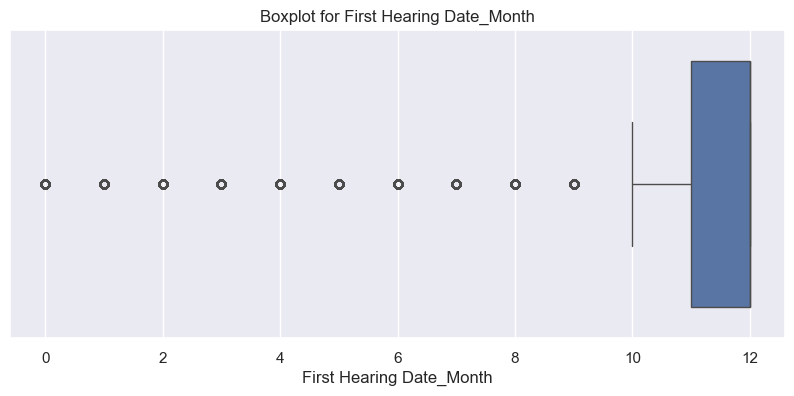

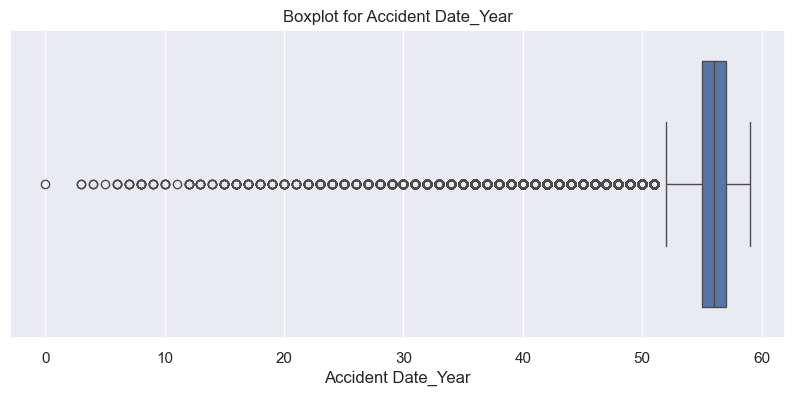

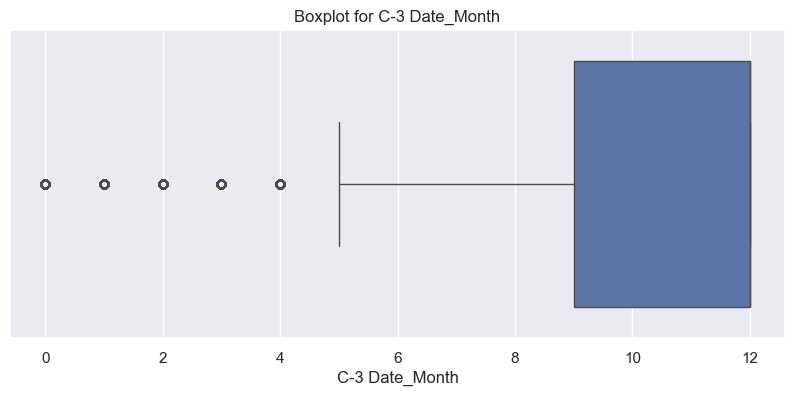

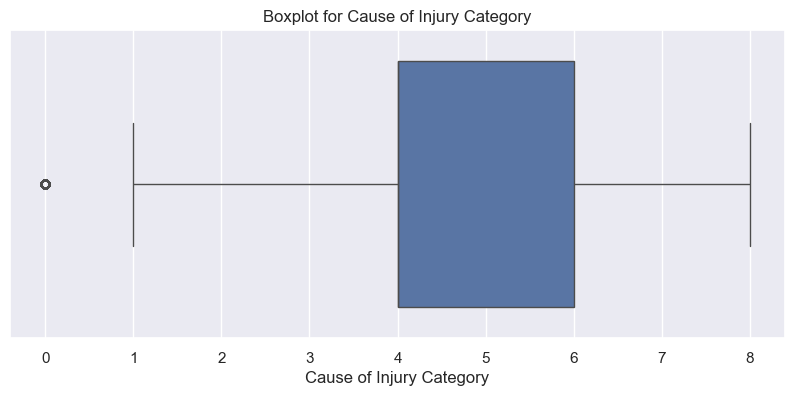

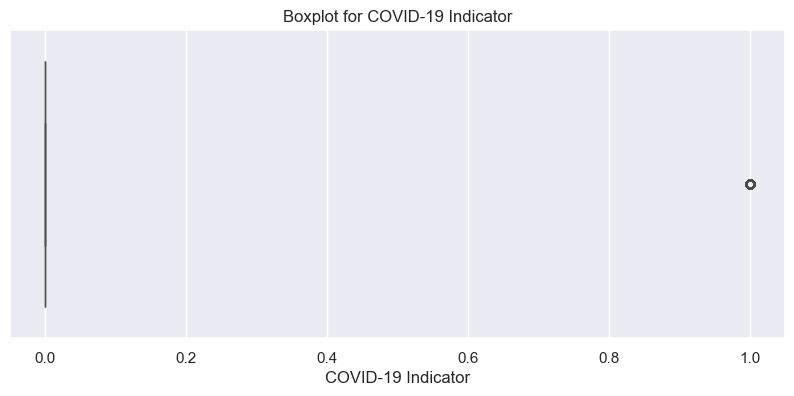

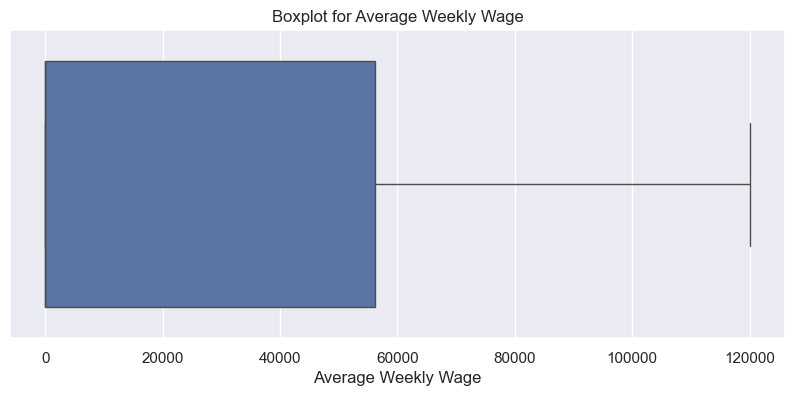

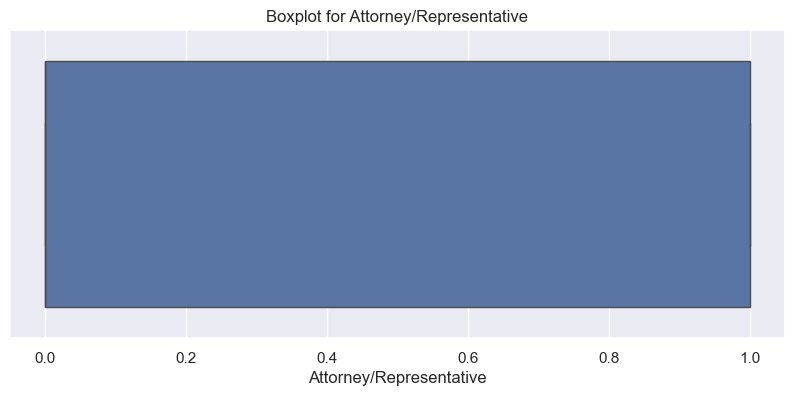

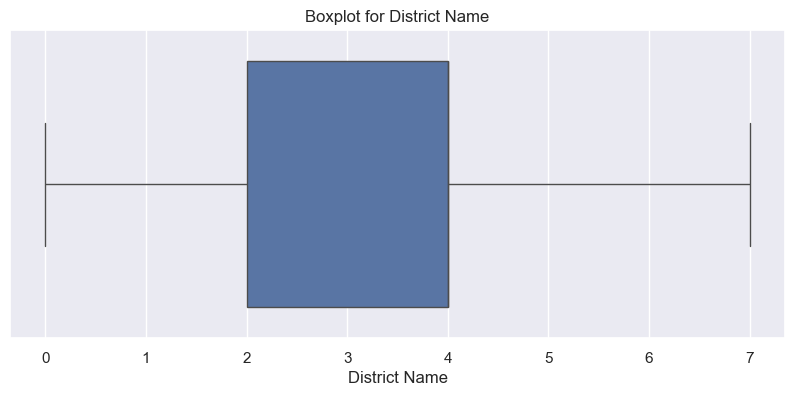

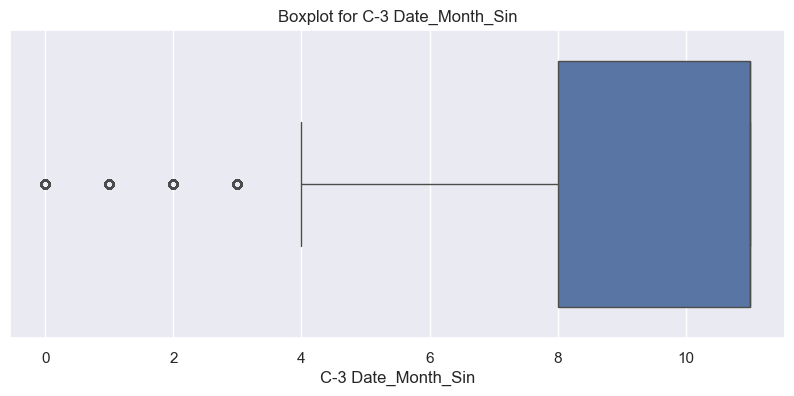

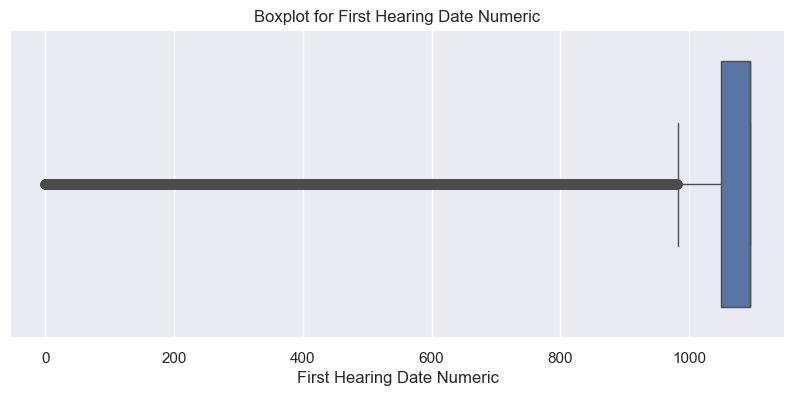

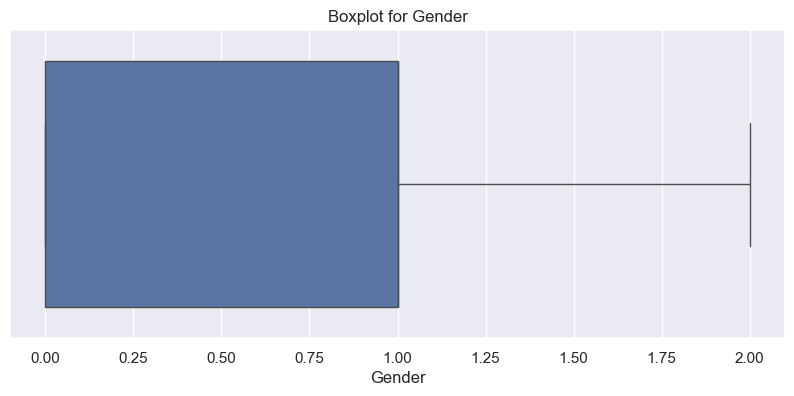

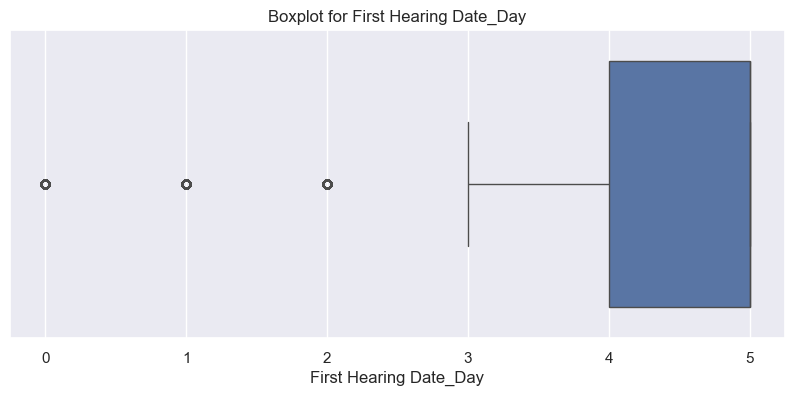

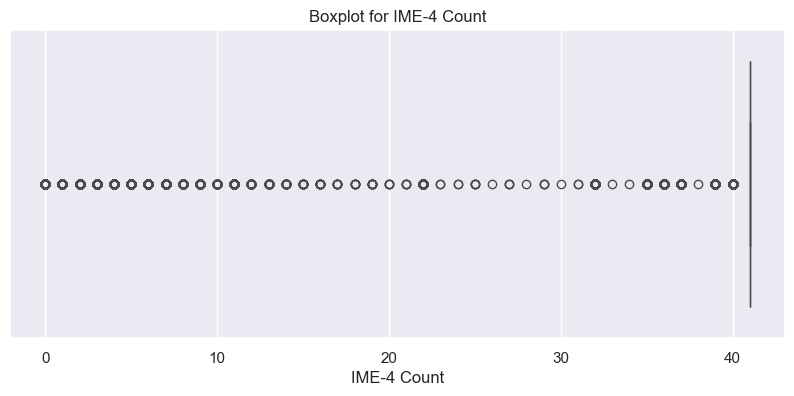

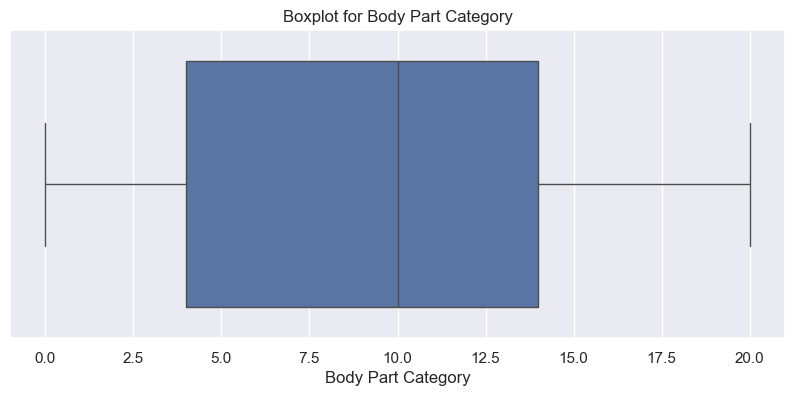

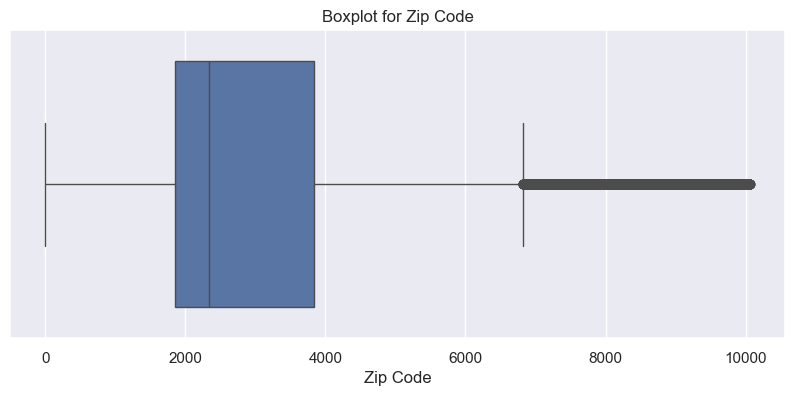

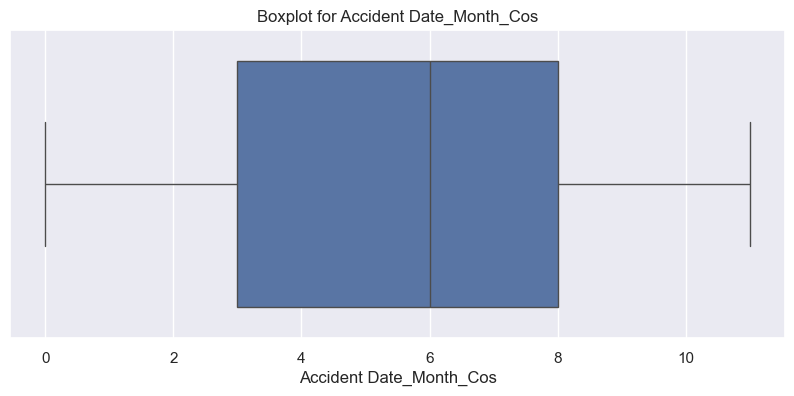

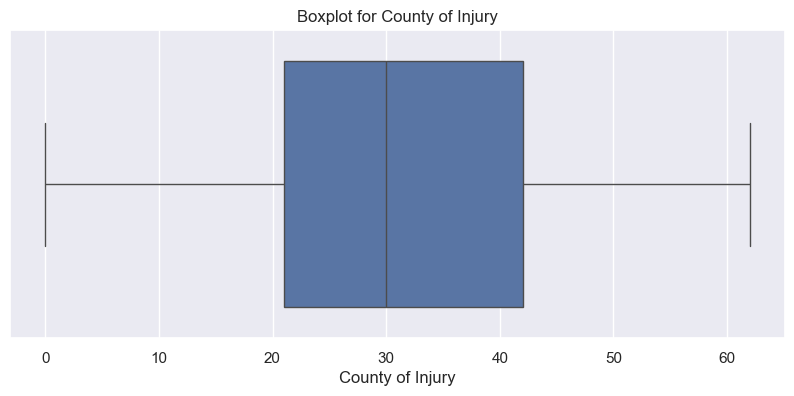

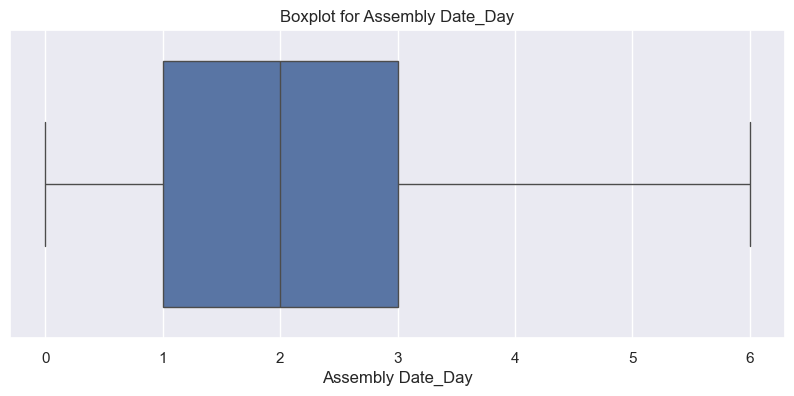

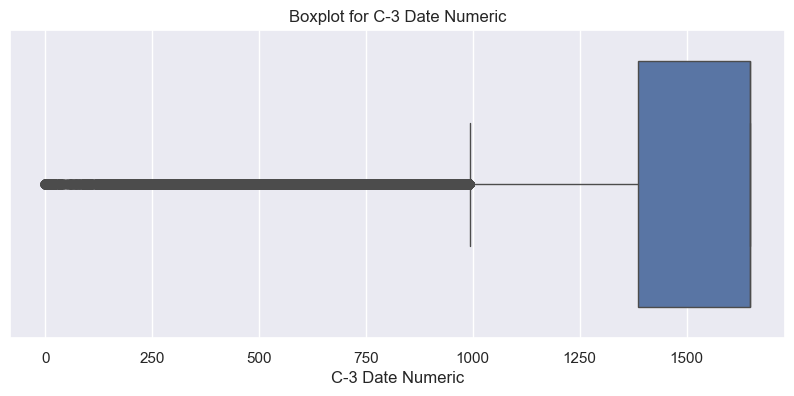

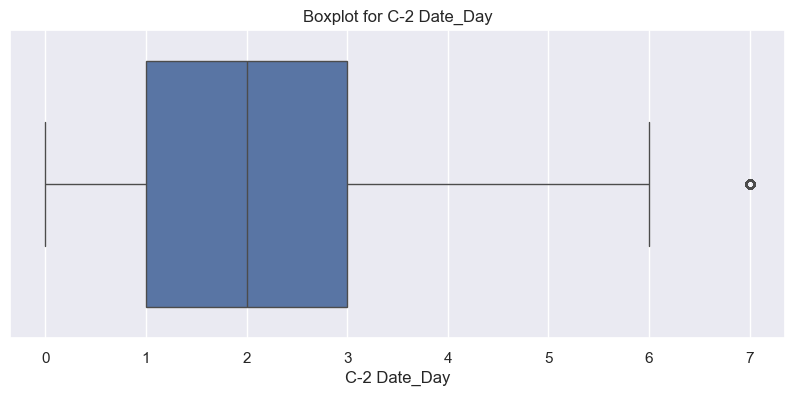

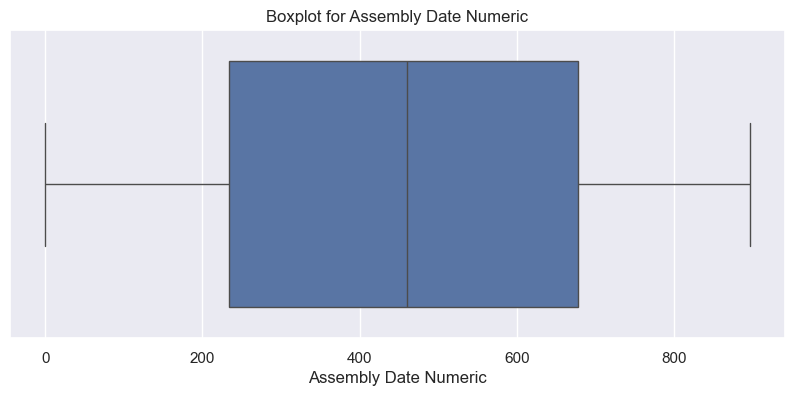

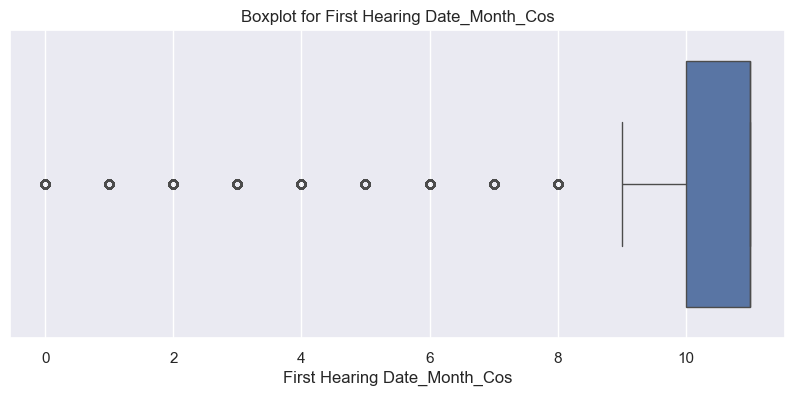

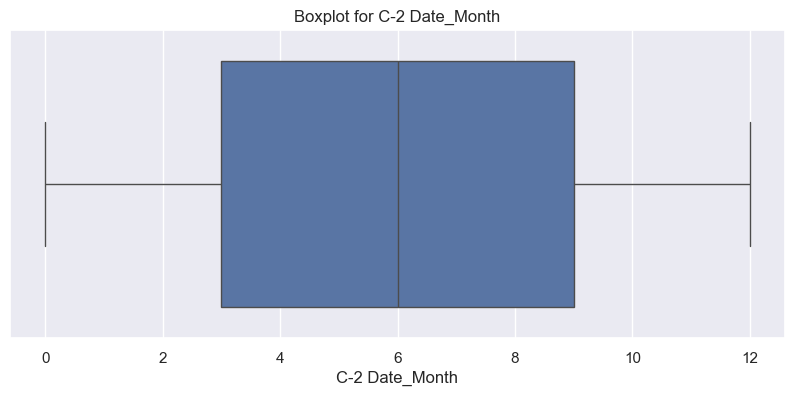

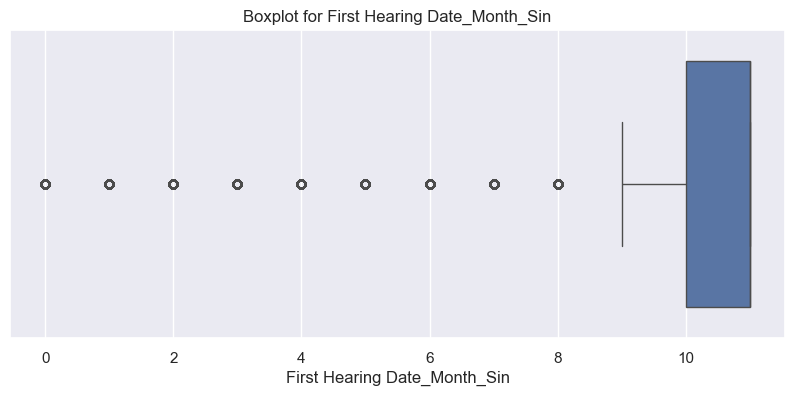

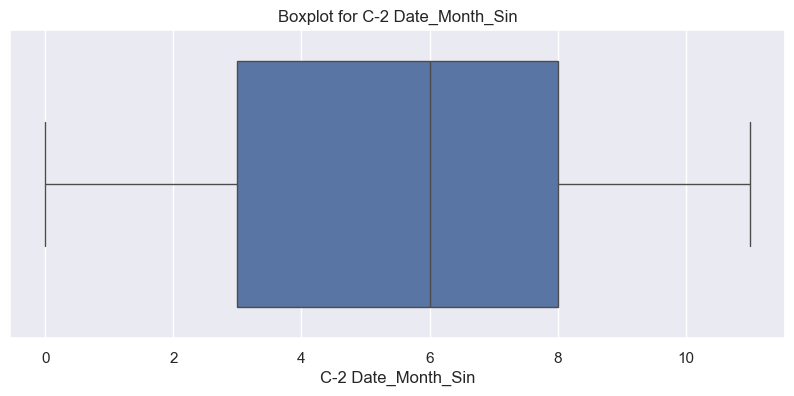

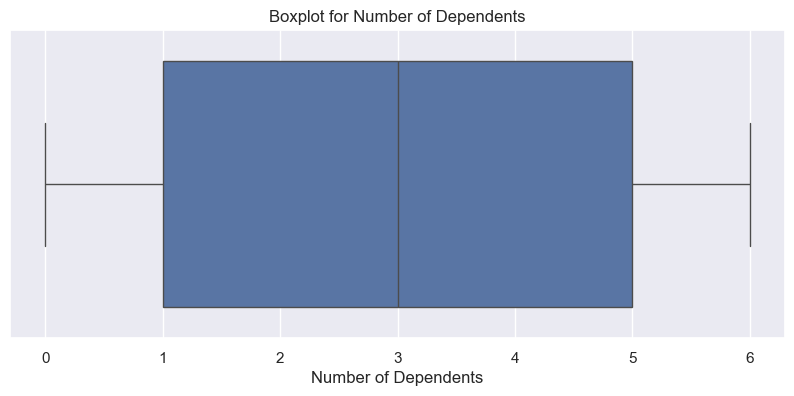

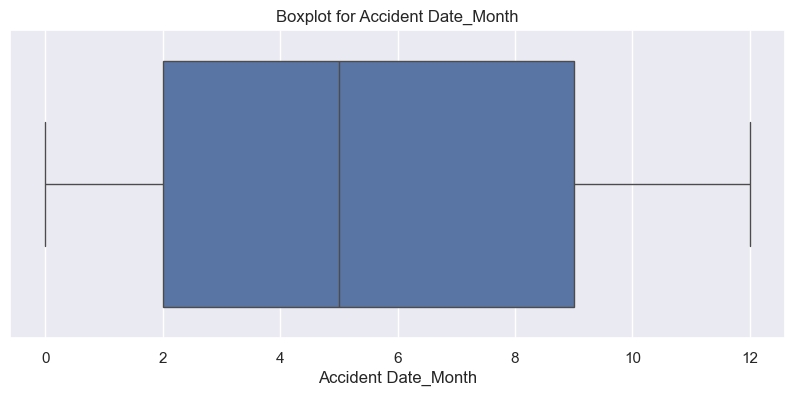

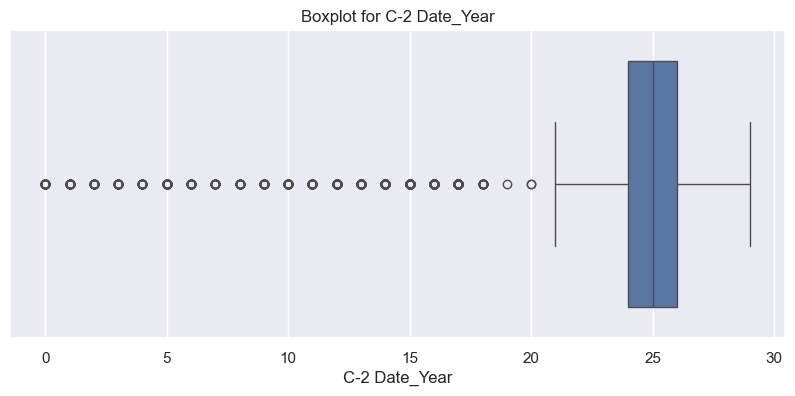

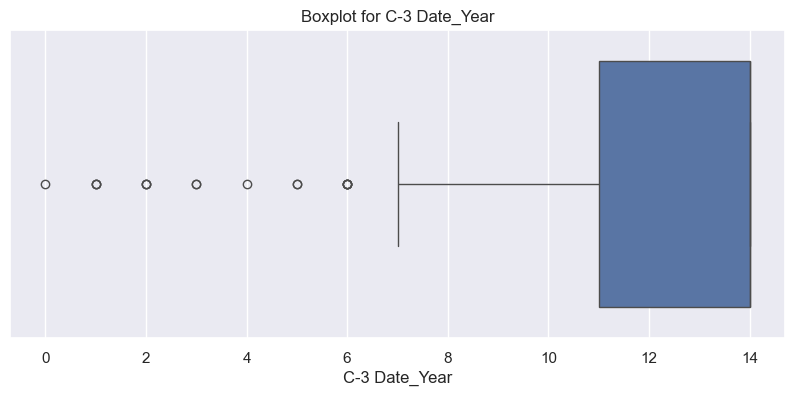

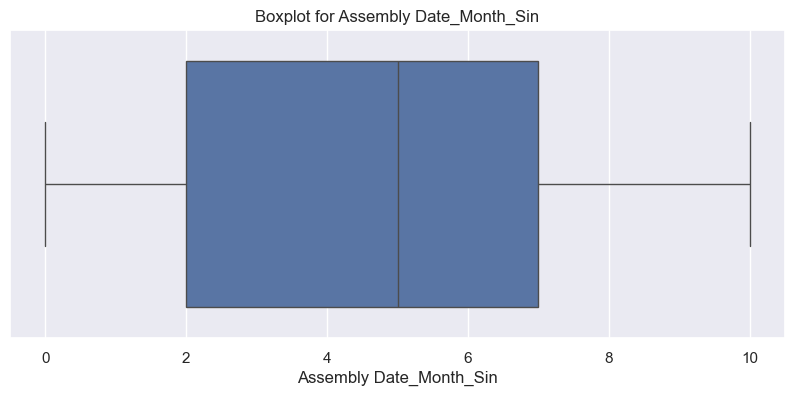

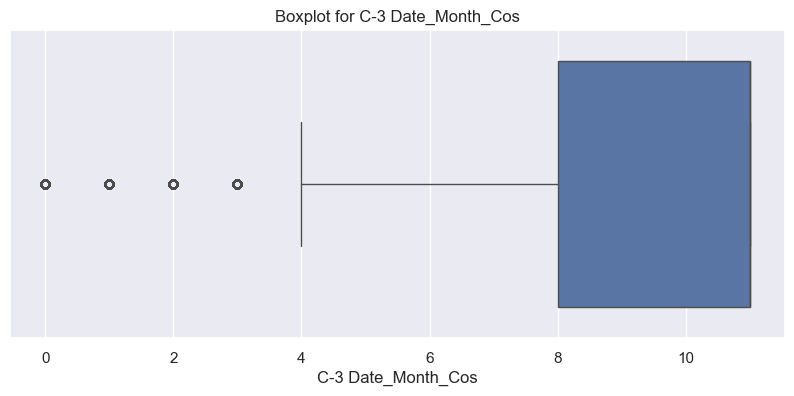

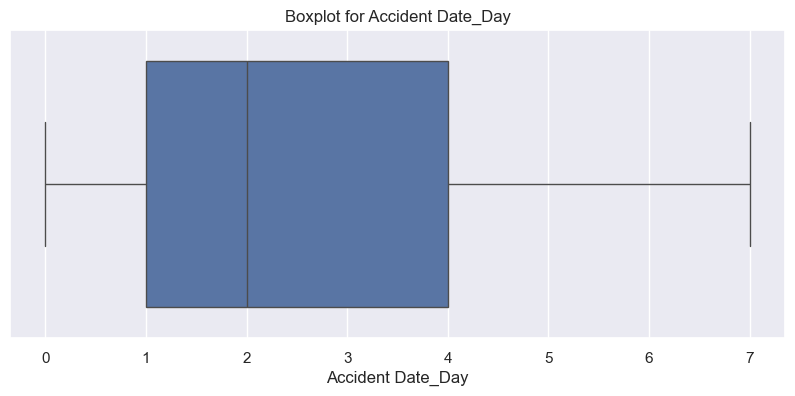

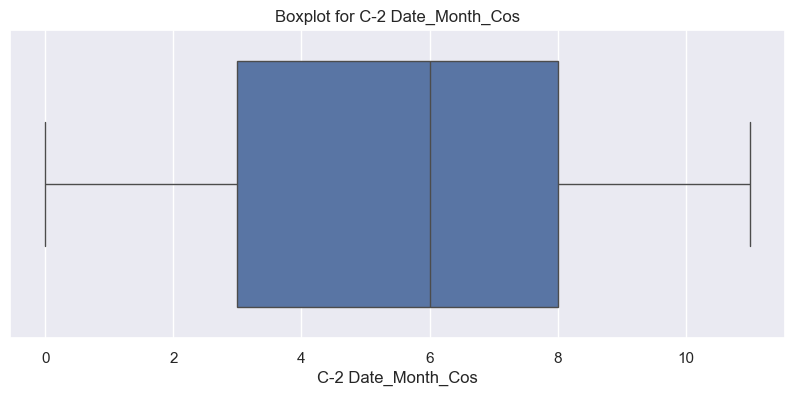

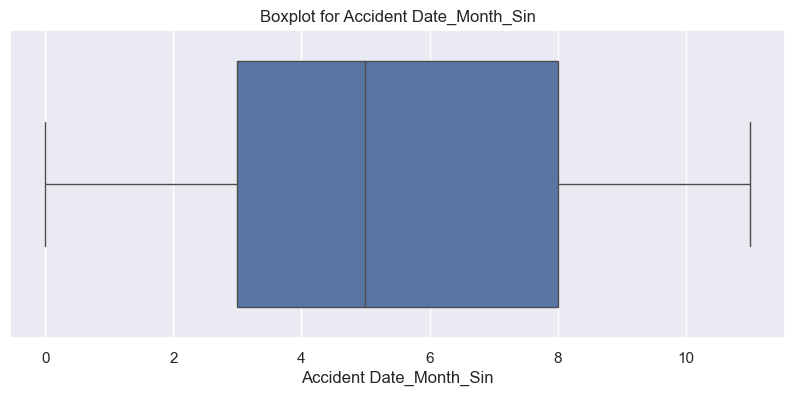

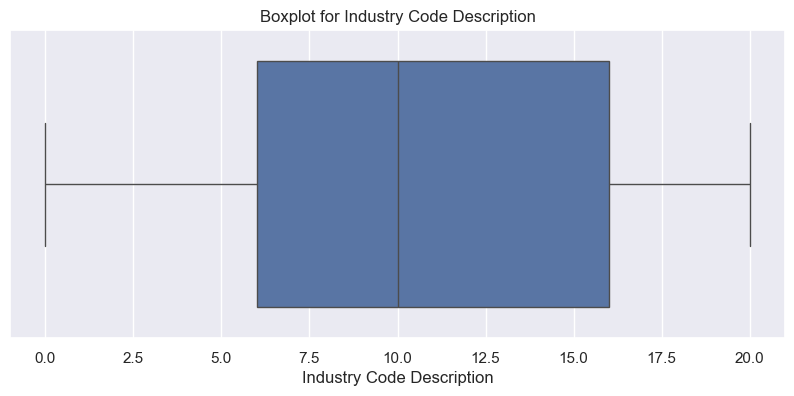

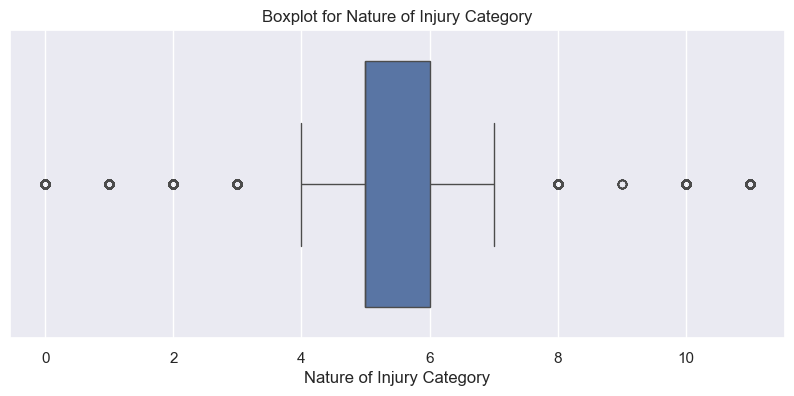

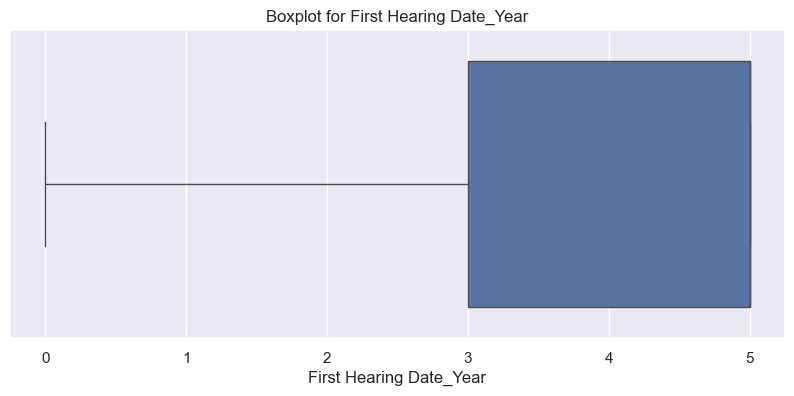

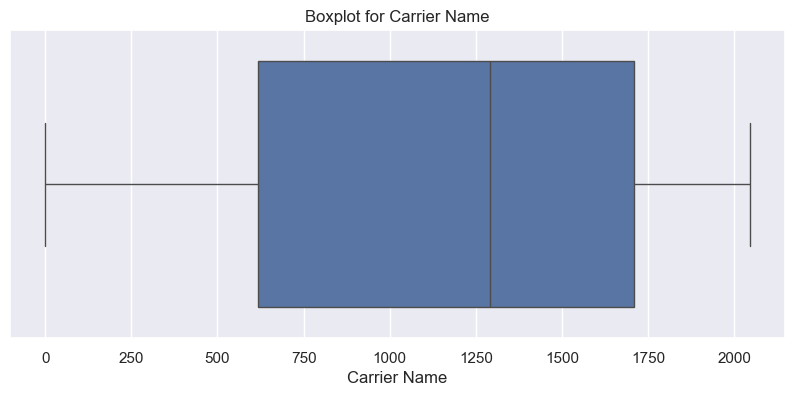

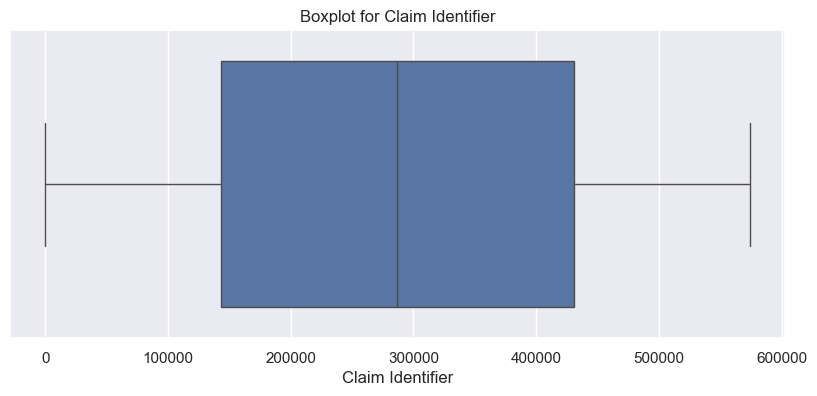

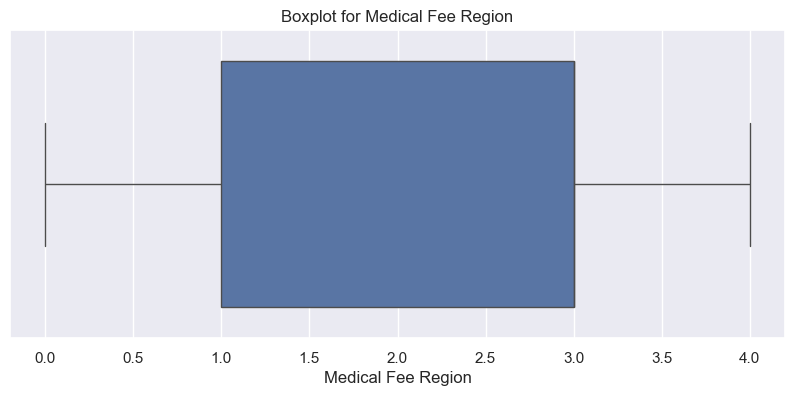

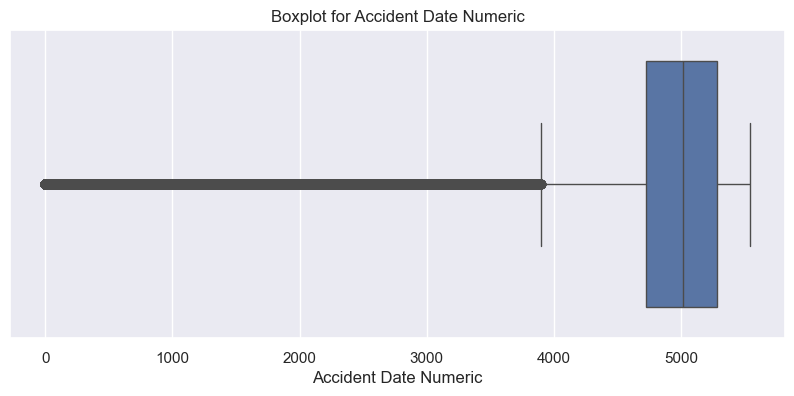

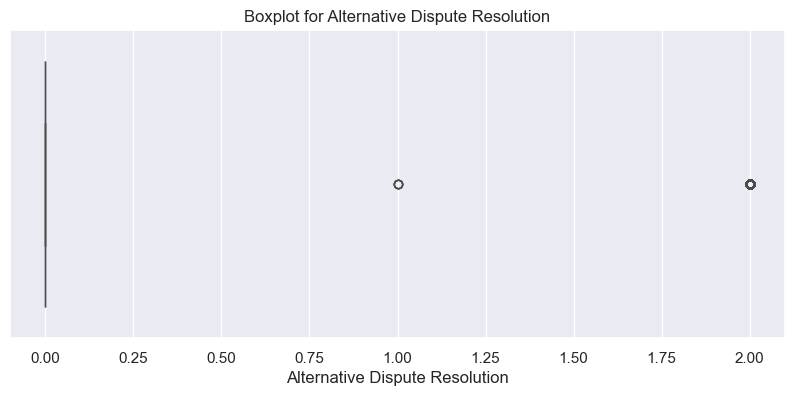

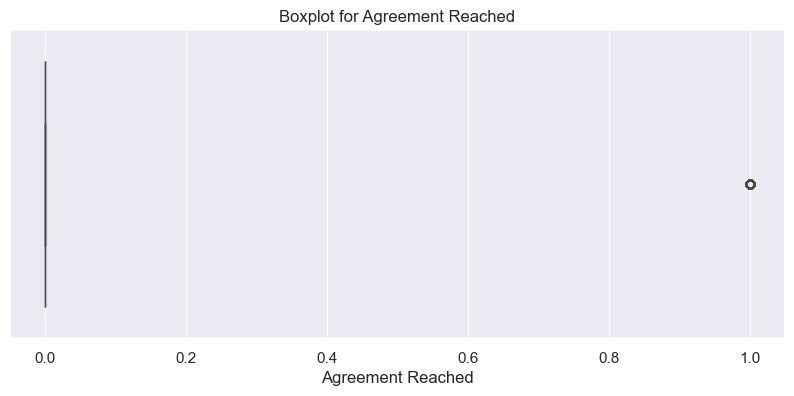

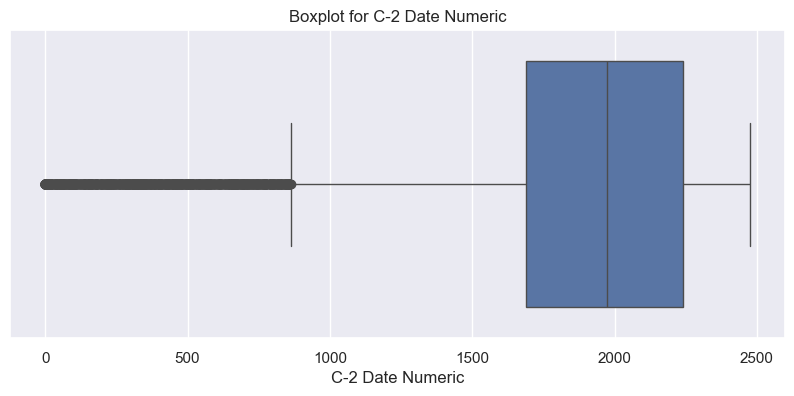

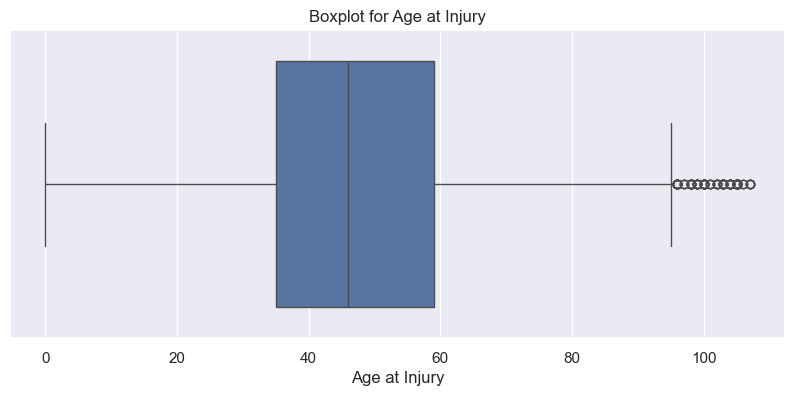

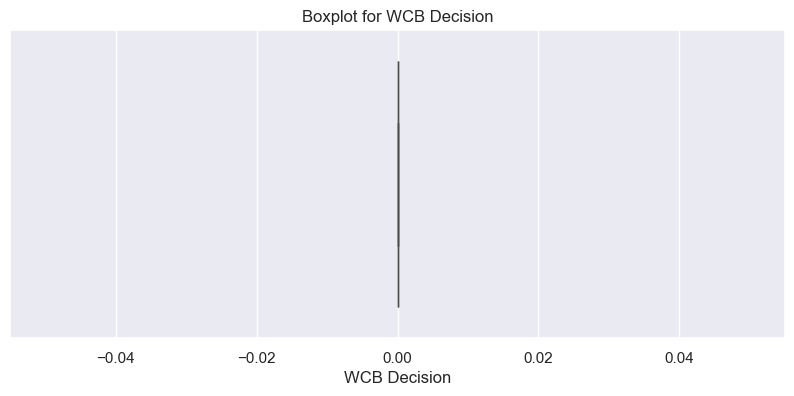

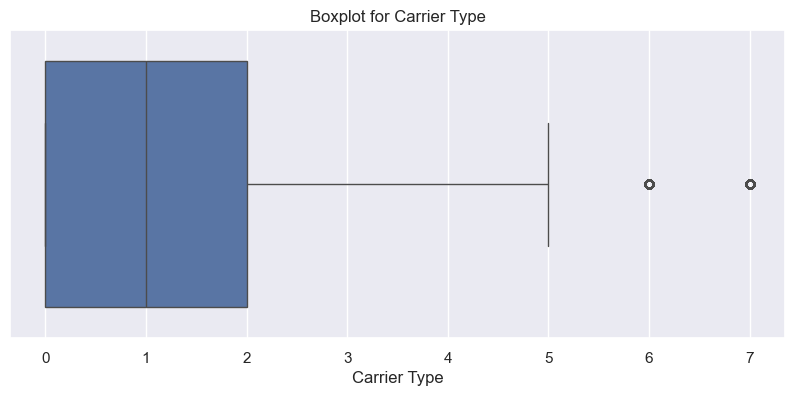

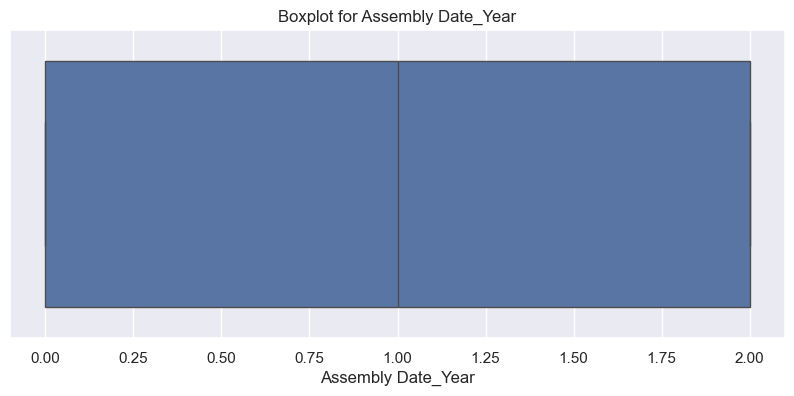

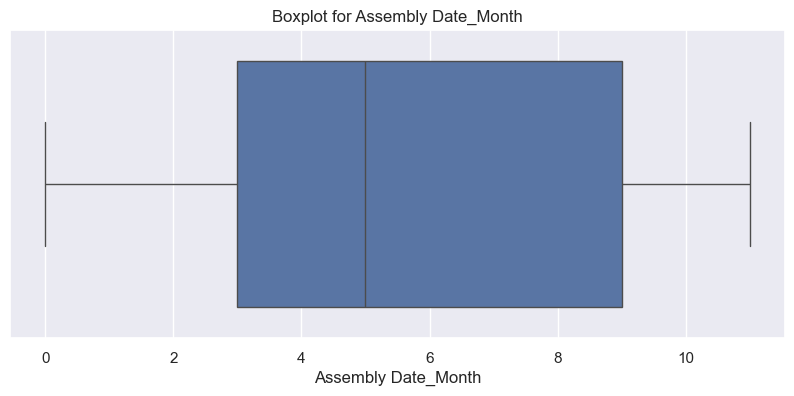

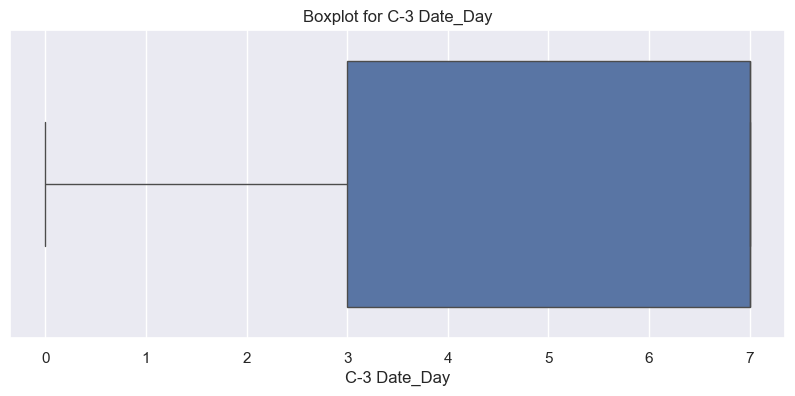

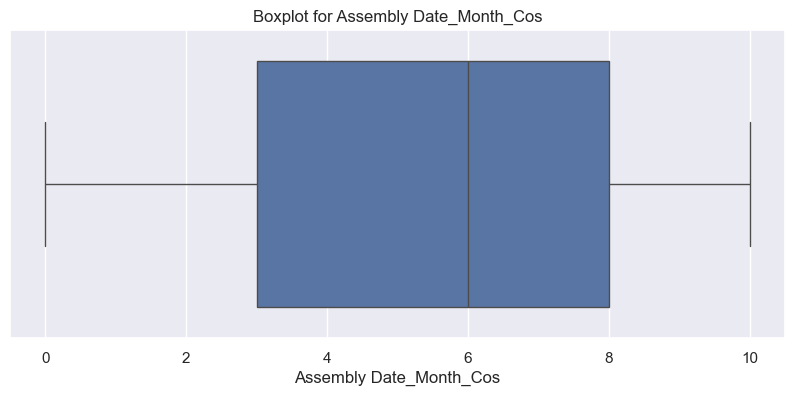

In [84]:
for column in X_train_imputed.columns:
    # Check if the column is numeric and not categorical
    if X_train_imputed[column].dtype in ['int64', 'float64']:
        # Drop NaNs or fill them with a value to avoid issues in plotting
        data = X_train_imputed[column].dropna()  # You can use .fillna() if needed
        
        if not data.empty:  # Ensure the column has data to plot
            plt.figure(figsize=(10, 4))
            sns.boxplot(x=data)
            plt.title(f'Boxplot for {column}')
            plt.show()

In [85]:
# Perform a copy to handle outliers

X_train_out = X_train_imputed.copy()
X_val_out = X_val_imputed.copy()

#### Alternative Dispute Resolution

In [86]:
print(X_train_imputed['Alternative Dispute Resolution'].value_counts())

Alternative Dispute Resolution
0.0    457133
2.0      2083
1.0         4
Name: count, dtype: int64


## 3.4 Data Scaling 

In [93]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_imputed_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

# Transform the validation data using the same scaler
X_val_imputed_scaled = pd.DataFrame(
    scaler.transform(X_val_imputed),
    columns=X_val_imputed.columns,
    index=X_val_imputed.index
)

# Display the scaled DataFrames
X_train_imputed_scaled.head()
X_val_imputed_scaled.head()


,First Hearing Date_Month,Accident Date_Year,C-3 Date_Month,Cause of Injury Category,COVID-19 Indicator,Average Weekly Wage,Attorney/Representative,District Name,C-3 Date_Month_Sin,First Hearing Date Numeric,Gender,First Hearing Date_Day,IME-4 Count,Body Part Category,Zip Code,Accident Date_Month_Cos,County of Injury,Assembly Date_Day,C-3 Date Numeric,C-2 Date_Day,Assembly Date Numeric,First Hearing Date_Month_Cos,C-2 Date_Month,First Hearing Date_Month_Sin,C-2 Date_Month_Sin,Number of Dependents,Accident Date_Month,C-2 Date_Year,C-3 Date_Year,Assembly Date_Month_Sin,C-3 Date_Month_Cos,Accident Date_Day,C-2 Date_Month_Cos,Accident Date_Month_Sin,Industry Code Description,Nature of Injury Category,First Hearing Date_Year,Carrier Name,Claim Identifier,Medical Fee Region,Accident Date Numeric,Alternative Dispute Resolution,Agreement Reached,C-2 Date Numeric,Age at Injury,WCB Decision,Carrier Type,Assembly Date_Year,Assembly Date_Month,C-3 Date_Day,Assembly Date_Month_Cos
428363,0.513084,0.615435,-0.802247,0.661933,-0.224686,-0.676946,-0.680716,1.948872,-0.947575,0.472594,-1.186026,0.519074,0.466212,0.919003,0.422693,1.570366,1.121991,-0.701448,0.150476,-0.772665,1.032372,0.506588,-0.193525,0.510897,1.198448,-0.502471,-0.152485,0.693043,-0.902430,1.288442,-2.174701,-1.373322,1.509992,1.264624,-0.945713,0.595727,0.558445,-1.402714,0.760987,-1.465465,0.595209,-0.067552,-0.220754,0.888518,0.647245,0.0,0.968773,1.169526,-0.154569,-0.556803,1.617597
582430,-1.251896,0.615435,0.582638,0.661933,-0.224686,2.169898,1.469042,0.883758,0.586708,-1.917756,0.789279,-2.133364,-2.752683,1.279898,0.672120,1.242050,-0.749498,1.385261,0.537928,1.054277,-1.498802,-3.167801,-0.751769,-0.496381,-0.073602,-0.502471,-0.721188,0.693043,0.670569,-0.023978,0.587612,0.797549,1.189513,-0.035471,1.219980,-0.061856,-0.090012,0.941636,1.666004,-1.465465,-0.610876,-0.067552,-0.220754,-1.951205,1.323261,0.0,0.066456,1.169526,-0.729439,0.652810,1.286008
4015,0.513084,-5.260493,0.582638,0.661933,-0.224686,-0.676946,1.469042,-0.181356,0.586708,0.472594,-1.186026,0.519074,0.466212,-1.426818,-0.378796,-0.399532,1.242733,-0.005878,0.537928,-0.772665,0.631894,0.506588,-1.589136,0.510897,0.244410,-1.002316,0.700570,-0.928032,0.670569,0.304127,0.587612,-0.830605,0.869034,1.589648,-0.584764,0.595727,0.558445,-1.173958,-1.715047,0.777671,-4.554718,-0.067552,4.529925,0.289595,0.579643,0.0,-0.835860,-1.298200,-1.591742,0.652810,0.954418
527870,-2.428549,0.615435,0.028684,0.661933,-0.224686,0.052696,1.469042,0.351201,-2.175001,-2.299083,0.789279,-0.807145,-0.004846,0.919003,-0.428583,0.257101,1.484215,-0.005878,0.459354,-0.772665,1.650585,-0.829554,1.481208,-2.846695,-0.391615,-1.502161,-0.436837,0.693043,-0.902430,-0.352083,-2.481625,-1.373322,-0.092405,0.614577,-0.584764,0.595727,-0.738468,0.941636,1.341194,0.777671,0.538585,-0.067552,-0.220754,1.379016,0.850050,0.0,0.066456,1.169526,1.570038,-1.363212,-0.040349
424995,0.513084,0.615435,0.582638,0.661933,-0.224686,-0.676946,-0.680716,0.351201,0.586708,0.472594,2.764584,0.519074,0.466212,2.001689,-0.583317,1.570366,-0.447645,-0.005878,0.537928,-0.163684,1.012931,0.506588,-0.193525,0.510897,1.198448,-1.502161,-0.152485,0.693043,0.670569,1.288442,0.587612,-0.830605,1.509992,1.264624,-0.584764,-0.061856,0.558445,0.691788,0.749623,0.777671,0.596625,-0.067552,-0.220754,0.870447,-0.501984,0.0,-0.835860,1.169526,-0.154569,0.652810,1.617597


In [177]:
from sklearn.preprocessing import MinMaxScaler


# Initialize the MinMaxScaler
scaler_min_max = MinMaxScaler()

# Fit the scaler on the training data and transform it
X_train_imputed_scaled_minmax = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

# Transform the validation data using the same scaler
X_val_imputed_scaled_minmax = pd.DataFrame(
    scaler.transform(X_val_imputed),
    columns=X_val_imputed.columns,
    index=X_val_imputed.index
)

# Display the scaled DataFrame
X_train_imputed_scaled_minmax.head()
X_val_imputed_scaled_minmax.head()

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Carrier Name,Carrier Type,County of Injury,COVID-19 Indicator,District Name,Gender,IME-4 Count,Industry Code Description,Medical Fee Region,Zip Code,Agreement Reached,WCB Decision,Number of Dependents,Cause of Injury Category,Nature of Injury Category,Body Part Category,Accident Date_Year,Accident Date_Month,Accident Date_Day,Accident Date_Month_Sin,Accident Date_Month_Cos,Assembly Date_Year,Assembly Date_Month,Assembly Date_Day,Assembly Date_Month_Sin,Assembly Date_Month_Cos,C-2 Date_Year,C-2 Date_Month,C-2 Date_Day,C-2 Date_Month_Sin,C-2 Date_Month_Cos,Accident Date Numeric,Assembly Date Numeric,C-2 Date Numeric,C-3 Date_Year,C-3 Date_Month,C-3 Date_Day,C-3 Date_Month_Sin,C-3 Date_Month_Cos,First Hearing Date_Year,First Hearing Date_Month,First Hearing Date_Day,First Hearing Date_Month_Sin,First Hearing Date_Month_Cos,C-3 Date Numeric,First Hearing Date Numeric
428363,0.835420,-0.067552,3.618799,-0.698622,2.539194,0.968773,1.121991,-0.224686,1.948872,4.739889,1.319623,-0.945713,-1.465465,-1.794612,-0.220754,0.0,-0.502471,0.661933,0.595727,0.919003,0.615435,-0.152485,-1.373322,1.264624,1.570366,1.169526,-0.154569,-0.701448,-2.325158,1.617597,-8.246594,-0.193525,-0.772665,1.198448,1.903977,1.511935,1.032372,0.888518,-0.902430,-0.802247,-0.556803,-0.947575,-2.174701,0.558445,0.513084,0.519074,0.510897,0.506588,0.150476,0.472594
582430,1.288816,-0.067552,5.768556,2.360286,4.675611,0.066456,-0.749498,-0.224686,0.883758,6.715193,-3.154085,1.219980,-1.465465,-1.604116,-0.220754,0.0,-0.502471,0.661933,-0.061856,1.279898,0.615435,-0.721188,0.797549,-0.035471,1.242050,1.169526,-0.729439,1.385261,-3.641716,1.286008,-8.246594,-0.751769,1.054277,-0.073602,-2.020816,-6.563035,-1.498802,-1.951205,0.670569,0.582638,0.652810,0.586708,0.587612,-0.090012,-1.251896,-2.133364,-0.496381,-3.167801,0.537928,-1.917756
4015,0.792239,-0.067552,5.768556,-0.698622,2.745291,-0.835860,1.242733,-0.224686,-0.181356,4.739889,1.319623,-0.584764,0.777671,-2.392955,4.529925,0.0,-1.002316,0.661933,0.595727,-1.426818,-5.260493,0.700570,-0.830605,1.589648,-0.399532,-1.298200,-1.591742,-0.005878,-3.312576,0.954418,-9.595325,-1.589136,-0.772665,0.244410,-2.322724,-7.872451,0.631894,0.289595,0.670569,0.582638,0.652810,0.586708,0.587612,0.558445,0.513084,0.519074,0.510897,0.506588,0.537928,0.472594
527870,0.964961,-0.067552,5.768556,0.332199,4.675611,0.066456,1.484215,-0.224686,0.351201,6.715193,0.552701,-0.584764,0.777671,-2.433655,-0.220754,0.0,-1.502161,0.661933,0.595727,0.919003,0.615435,-0.436837,-1.373322,0.614577,0.257101,1.169526,1.570038,-0.005878,-3.970855,-0.040349,-8.246594,1.481208,-0.772665,-0.391615,-3.228445,1.100856,1.650585,1.379016,-0.902430,0.028684,-1.363212,-2.175001,-2.481625,-0.738468,-2.428549,-0.807145,-2.846695,-0.829554,0.459354,-2.299083
424995,0.144531,-0.067552,3.618799,-0.698622,4.438231,-0.835860,-0.447645,-0.224686,0.351201,8.690498,1.319623,-0.584764,0.777671,-2.545687,-0.220754,0.0,-1.502161,0.661933,-0.061856,2.001689,0.615435,-0.152485,-0.830605,1.264624,1.570366,1.169526,-0.154569,-0.005878,-2.325158,1.617597,-8.246594,-0.193525,-0.163684,1.198448,1.903977,1.526309,1.012931,0.870447,0.670569,0.582638,0.652810,0.586708,0.587612,0.558445,0.513084,0.519074,0.510897,0.506588,0.537928,0.472594


## 4. Feature Selection <a id='features'></a>
[to the top](#top)

#### 4.1 - FEATURE SELECTION : __LOGISTIC REGRESSION__ AND __RFE CV__

Optimal number of features: 51
Best cross-validated score: 0.7082295350417226
Selected Features:
Index(['First Hearing Date_Month', 'Accident Date_Year', 'C-3 Date_Month',
       'Cause of Injury Category', 'COVID-19 Indicator', 'Average Weekly Wage',
       'Attorney/Representative', 'District Name', 'C-3 Date_Month_Sin',
       'First Hearing Date Numeric', 'Gender', 'First Hearing Date_Day',
       'IME-4 Count', 'Body Part Category', 'Zip Code',
       'Accident Date_Month_Cos', 'County of Injury', 'Assembly Date_Day',
       'C-3 Date Numeric', 'C-2 Date_Day', 'Assembly Date Numeric',
       'First Hearing Date_Month_Cos', 'C-2 Date_Month',
       'First Hearing Date_Month_Sin', 'C-2 Date_Month_Sin',
       'Number of Dependents', 'Accident Date_Month', 'C-2 Date_Year',
       'C-3 Date_Year', 'Assembly Date_Month_Sin', 'C-3 Date_Month_Cos',
       'Accident Date_Day', 'C-2 Date_Month_Cos', 'Accident Date_Month_Sin',
       'Industry Code Description', 'Nature of Injury Category',

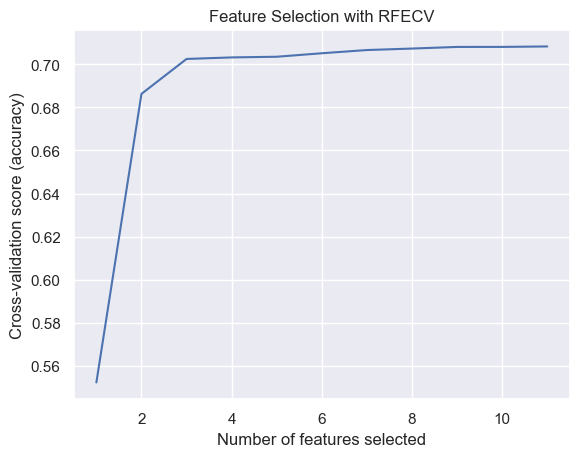

In [180]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Step 1: Choose Logistic Regression as the model
model = LogisticRegression(random_state=42)

# Step 2: Set up RFECV with default cross-validation (uses StratifiedKFold by default)
rfecv = RFECV(estimator=model, step=5, cv=5, scoring='accuracy')  # 'cv=5' uses 5-fold cross-validation

# Step 3: Fit RFECV to the training data
rfecv.fit(X_train_imputed_scaled, y_train)

# Step 4: Get the selected features and their ranking
print("Optimal number of features:", rfecv.n_features_)
print("Best cross-validated score:", rfecv.score(X_val_imputed_scaled, y_val))

# Optionally, print and display results
selected_features = X_train_imputed_scaled.columns[rfecv.support_]
print("Selected Features:")
print(selected_features)

# Plot the cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")

# Use cv_results_['mean_test_score'] for plotting in newer versions of scikit-learn
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("Feature Selection with RFECV")
plt.show()


In [99]:
# Get the selected features from RFECV
selected_features = X_train_imputed_scaled.columns[rfecv.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['Gender', 'Agreement Reached', 'Assembly Date_Day',
       'Accident Date_Year', 'Medical Fee Region', 'COVID-19 Indicator',
       'Accident Date_Month_Cos', 'Alternative Dispute Resolution',
       'Assembly Date_Month_Cos', 'C-2 Date_Year', 'C-2 Date_Month_Cos',
       'Age at Injury', 'Assembly Date Numeric', 'Industry Code Description',
       'WCB Decision', 'C-2 Date Numeric', 'Assembly Date_Month_Sin',
       'Body Part Category', 'Accident Date Numeric', 'Accident Date_Day',
       'Accident Date_Month_Sin', 'Claim Identifier', 'C-2 Date_Month',
       'C-2 Date_Month_Sin', 'Attorney/Representative', 'County of Injury',
       'IME-4 Count', 'Carrier Name', 'C-2 Date_Day', 'District Name',
       'Cause of Injury Category', 'Average Weekly Wage',
       'Nature of Injury Category', 'Carrier Type', 'Accident Date_Month',
       'Assembly Date_Month', 'Assembly Date_Year', 'Zip Code',
       'Number of Dependents'],
      dtype='object')


#### 4.2 - FEATURE SELECTION : __LASSO REGRESSION__ AND __REDUDANCY CHECK__ THROUGH __CORRELATION__ AND __VIF__

In [182]:
X_train_imputed_scaled.columns

Index(['First Hearing Date_Month', 'Accident Date_Year', 'C-3 Date_Month',
       'Cause of Injury Category', 'COVID-19 Indicator', 'Average Weekly Wage',
       'Attorney/Representative', 'District Name', 'C-3 Date_Month_Sin',
       'First Hearing Date Numeric', 'Gender', 'First Hearing Date_Day',
       'IME-4 Count', 'Body Part Category', 'Zip Code',
       'Accident Date_Month_Cos', 'County of Injury', 'Assembly Date_Day',
       'C-3 Date Numeric', 'C-2 Date_Day', 'Assembly Date Numeric',
       'First Hearing Date_Month_Cos', 'C-2 Date_Month',
       'First Hearing Date_Month_Sin', 'C-2 Date_Month_Sin',
       'Number of Dependents', 'Accident Date_Month', 'C-2 Date_Year',
       'C-3 Date_Year', 'Assembly Date_Month_Sin', 'C-3 Date_Month_Cos',
       'Accident Date_Day', 'C-2 Date_Month_Cos', 'Accident Date_Month_Sin',
       'Industry Code Description', 'Nature of Injury Category',
       'First Hearing Date_Year', 'Carrier Name', 'Claim Identifier',
       'Medical Fee Region

Features selected by Lasso regression:
Index(['First Hearing Date_Month', 'Cause of Injury Category',
       'COVID-19 Indicator', 'Average Weekly Wage', 'Attorney/Representative',
       'Gender', 'First Hearing Date_Day', 'IME-4 Count', 'Body Part Category',
       'Zip Code', 'Assembly Date_Day', 'C-2 Date_Day',
       'Assembly Date Numeric', 'First Hearing Date_Month_Cos',
       'C-2 Date_Month', 'First Hearing Date_Month_Sin', 'C-2 Date_Year',
       'C-3 Date_Year', 'Assembly Date_Month_Sin', 'Accident Date_Day',
       'C-2 Date_Month_Cos', 'Nature of Injury Category',
       'First Hearing Date_Year', 'Carrier Name', 'Medical Fee Region',
       'Accident Date Numeric', 'Agreement Reached', 'Age at Injury',
       'Assembly Date_Year', 'Assembly Date_Month_Cos'],
      dtype='object')


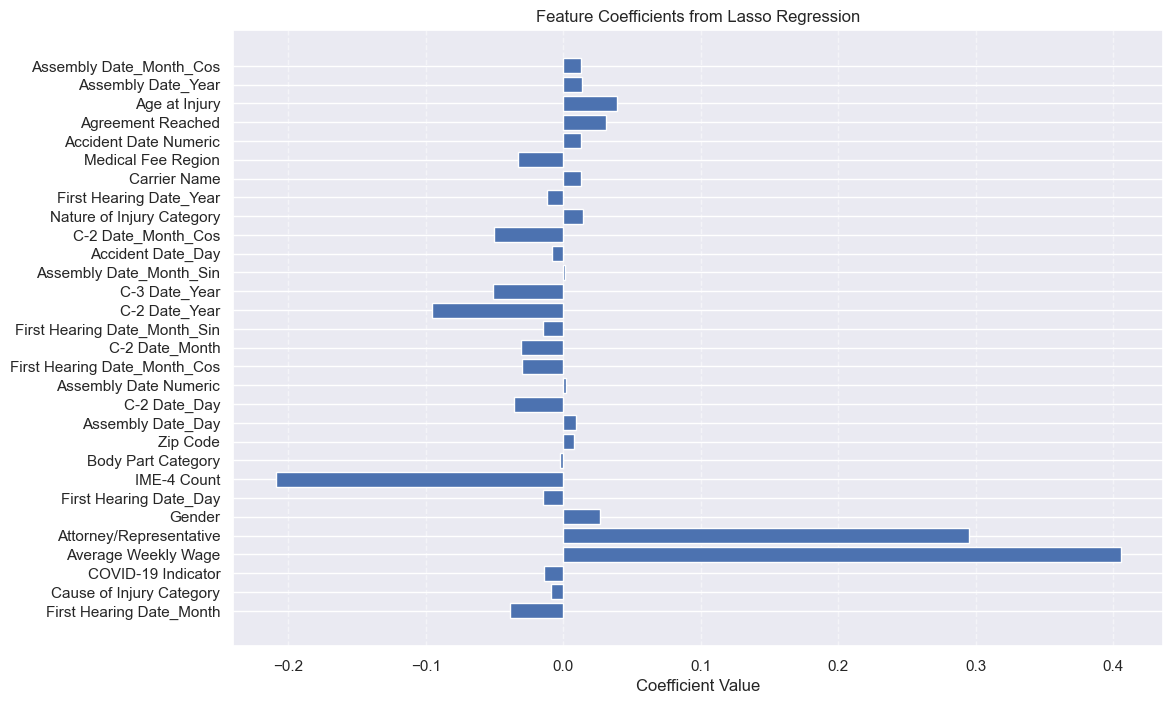

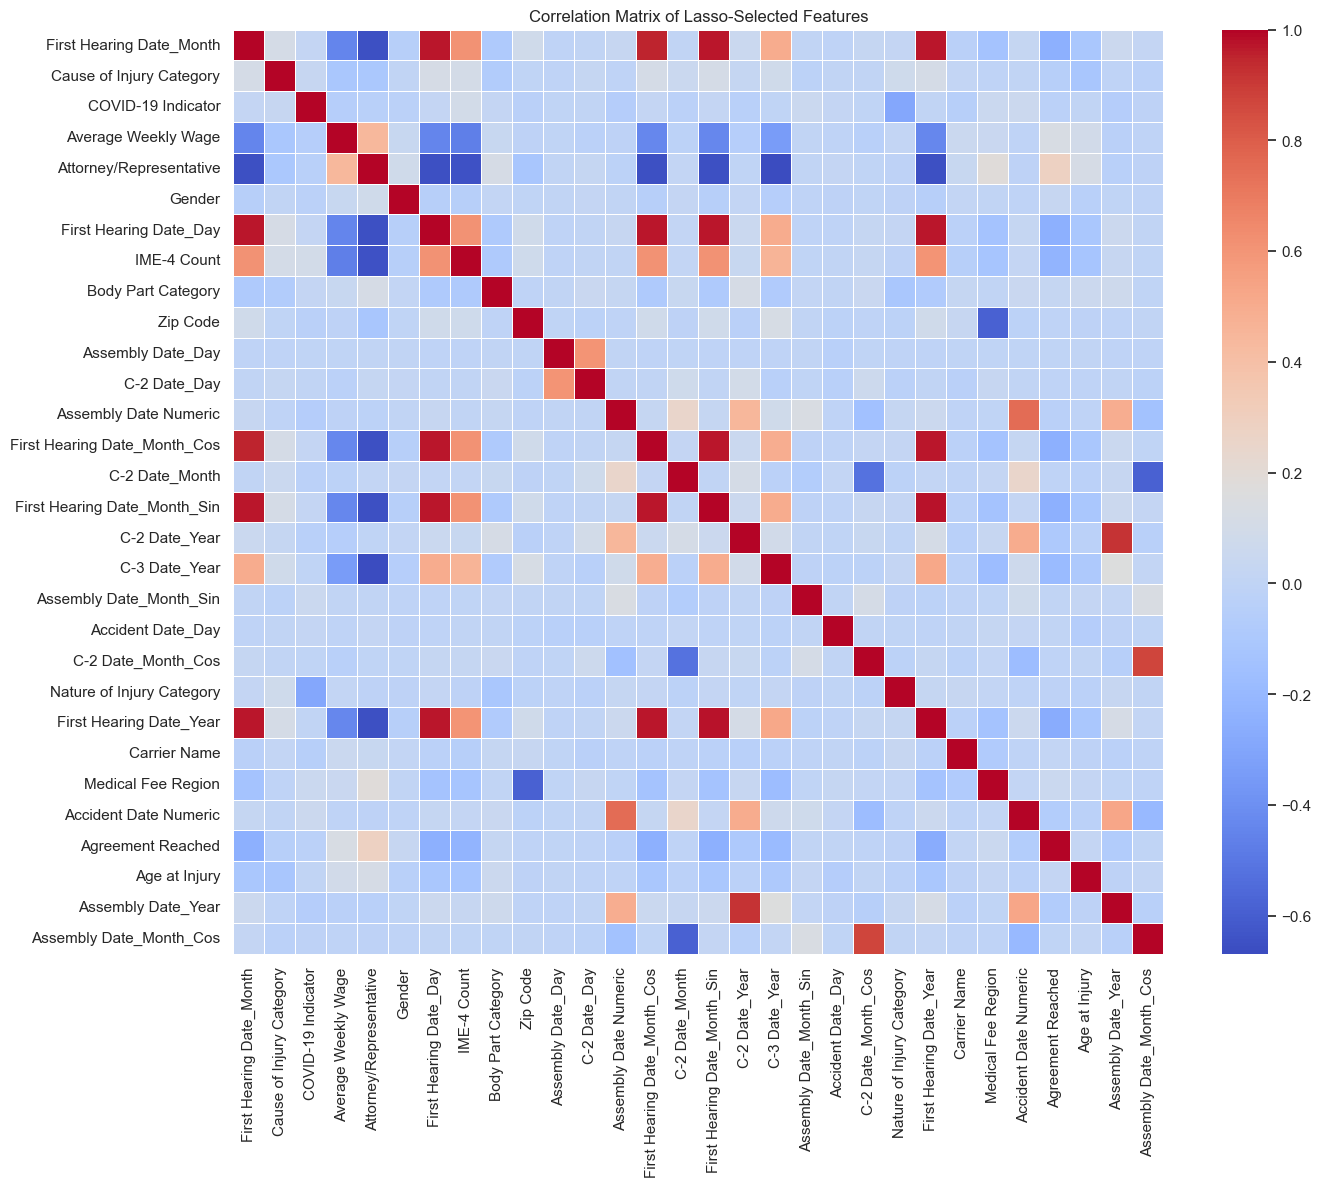

Highly correlated pairs:
[('First Hearing Date_Month', 'First Hearing Date_Day'), ('First Hearing Date_Month', 'First Hearing Date_Month_Cos'), ('First Hearing Date_Month', 'First Hearing Date_Month_Sin'), ('First Hearing Date_Month', 'First Hearing Date_Year'), ('First Hearing Date_Day', 'First Hearing Date_Month_Cos'), ('First Hearing Date_Day', 'First Hearing Date_Month_Sin'), ('First Hearing Date_Day', 'First Hearing Date_Year'), ('First Hearing Date_Month_Cos', 'First Hearing Date_Month_Sin'), ('First Hearing Date_Month_Cos', 'First Hearing Date_Year'), ('First Hearing Date_Month_Sin', 'First Hearing Date_Year'), ('C-2 Date_Year', 'Assembly Date_Year')]
VIF values for Lasso-selected features:
                         Feature       VIF
22       First Hearing Date_Year  7.460118
20            C-2 Date_Month_Cos  5.189653
29       Assembly Date_Month_Cos  5.152985
15  First Hearing Date_Month_Sin  4.024684
6         First Hearing Date_Day  3.703725
13  First Hearing Date_Month_Cos  3

In [183]:
# Step 1: Run Lasso Regression to Identify Important Features
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 2: Run Lasso Regression with a chosen alpha value
lasso = Lasso(alpha=0.01, max_iter=1000, random_state=42)  # Adjust alpha as needed
lasso.fit(X_train_imputed_scaled, y_train)

# Step 3: Select features with non-zero coefficients
non_zero_features = X_train_imputed_scaled.columns[lasso.coef_ != 0]
non_zero_coefficients = lasso.coef_[lasso.coef_ != 0]

# Check if there are any features selected
if len(non_zero_features) > 0:
    # Print the selected features
    print("Features selected by Lasso regression:")
    print(non_zero_features)

    # Create the DataFrame with Lasso-selected features
    X_train_lasso_selected = X_train_imputed_scaled[non_zero_features]

    # Step 4: Plot the non-zero feature coefficients
    plt.figure(figsize=(12, 8))
    plt.barh(non_zero_features, non_zero_coefficients)
    plt.xlabel("Coefficient Value")
    plt.title("Feature Coefficients from Lasso Regression")
    plt.grid(axis='x', linestyle='--', alpha=0.5)  # Optional for better readability
    plt.show()
else:
    print("No features were selected by Lasso regression.")

# Step 5: Check for Redundancy Using Correlation Analysis
# Compute the correlation matrix for the Lasso-selected features
corr_matrix = X_train_lasso_selected.corr(method='spearman')

# Plot the correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Lasso-Selected Features")
plt.show()

# Identify pairs of highly correlated features (e.g., correlation > 0.9)
high_corr_pairs = [(col, corr_matrix.columns[j]) for i, col in enumerate(corr_matrix.columns)
                   for j in range(i + 1, len(corr_matrix.columns))
                   if abs(corr_matrix.iloc[i, j]) > 0.9]

print("Highly correlated pairs:")
print(high_corr_pairs)

# Step 6: Check for Redundancy Using VIF
# Calculate VIF for each Lasso-selected feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_lasso_selected.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_lasso_selected.values, i)
                   for i in range(X_train_lasso_selected.shape[1])]

# Display VIF values sorted by VIF score
print("VIF values for Lasso-selected features:")
print(vif_data.sort_values(by="VIF", ascending=False))

# Step 7: Decide on Dropping Redundant Features
# Review correlation pairs and high VIF values (e.g., VIF > 5-10)
# Drop one feature from each highly correlated pair or those with high VIF, if necessary


The features with high VIF values, particularly above 5, suggest multicollinearity. These features are:
* C-2 Date_Month_Sin (VIF: 6.87)
* Assembly Date_Month (VIF: 6.71)
* Assembly Date_Month_Sin (VIF: 6.37)
* C-2 Date_Month (VIF: 6.36)
* Assembly Date_Month_Cos (VIF: 5.98)
* C-2 Date_Month_Cos (VIF: 5.96)

#### Suggested Features to Retain:

* IME-4 Count: Strong positive impact, low VIF.
* Attorney/Representative: Positive impact, low VIF.
* C-2 Date_Year: Important feature with a significant coefficient and low VIF.
* C-2 Date_Month_Cos: Chosen from the C-2 Date-related features due to a significant coefficient.
* Assembly Date_Month_Sin: Selected from the Assembly Date group for its positive coefficient.
* Age at Injury: Low VIF, non-zero Lasso coefficient.
* Carrier Name: Included due to interpretability and low VIF.
* Gender: Low VIF, included for demographic insight.
* Average Weekly Wage: Moderate importance, low VIF.
* Zip Code: Low VIF, possible geographic insight.
* Accident Date Numeric: Low VIF and non-zero coefficient

#### Features to Consider Dropping:

* Features with high multicollinearity like Assembly Date_Month, C-2 Date_Month_Sin, and Assembly Date_Month_Cos unless needed for interpretation.

* Features with minimal coefficients and redundancy based on correlation.

## 5. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

- _"Identify the type of the problem and select the relevant algorithms._
- _Use cross-validation to assess performance. Which metrics did you use and why?_
- _Train at least 1 model using the train dataset and obtain predictions for the test dataset."_

### 5.1 Baseline <a id='baseline'></a>
[to the top](#top)

In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score


selected_features = [
    "IME-4 Count",
    "Average Weekly Wage",
    "Attorney/Representative",
    "First Hearing Date_Month",
    "Gender",
    "C-2 Date_Year",
    "Body Part Category",
    "Cause of Injury Category"
]


suggested_features_2 = [
    'IME-4 Count', 'Attorney/Representative', 'C-2 Date_Year', 
    'C-2 Date_Month_Cos', 'Assembly Date_Month_Sin', 'Age at Injury', 
    'Carrier Name', 'Gender', 'Average Weekly Wage', 'Zip Code', 
    'Accident Date Numeric'
]

# Select the suggested features from X
X_selected = X_train_imputed_scaled[selected_features]

In [94]:
def run_model_LR(X, y):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X, y)
    return model

def evaluate_model(X, y, model):
    y_pred = model.predict(X)
    return f1_score(y, y_pred, average='macro')

def avg_score_LR(method, X, y):
    score_train = []
    score_test = []
    for train_index, test_index in method.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = run_model_LR(X_train, y_train)
        value_train = evaluate_model(X_train, y_train, model)
        value_test = evaluate_model(X_test, y_test, model)
        score_train.append(value_train)
        score_test.append(value_test)

    print('Train:', np.mean(score_train))
    print('Test:', np.mean(score_test))

kf = KFold(n_splits=10)
avg_score_LR(kf, X_selected, y)

Train: 0.0832711079913708
Test: 0.08325023033524401


In [203]:
X_test = test_df.copy()

In [206]:
y_1 = y.loc[X_selected.index]


In [205]:
print(X_selected.shape)
print(y_1.shape)

(459220, 8)
(459220,)


In [204]:
print("Training features:", X_selected.columns)
print("Test features:", X_test.columns)

Training features: Index(['IME-4 Count', 'Average Weekly Wage', 'Attorney/Representative',
       'First Hearing Date_Month', 'Gender', 'C-2 Date_Year',
       'Body Part Category', 'Cause of Injury Category'],
      dtype='object')
Test features: Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'County of Injury', 'COVID-19 Indicator',
       'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count',
       'Industry Code', 'Industry Code Description', 'Medical Fee Region',
       'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Code',
       'WCIO Part Of Body Description', 'Zip Code', 'Number of Dependents'],
      dtype='obje

In [198]:
X_test.columns

Index(['IME-4 Count', 'Attorney/Representative', 'C-2 Date_Year',
       'C-2 Date_Month_Cos', 'Assembly Date_Month_Sin', 'Age at Injury',
       'Carrier Name', 'Gender', 'Average Weekly Wage', 'Zip Code',
       'Accident Date Numeric', 'Claim Identifier'],
      dtype='object')

In [115]:
X_selected.columns

Index(['IME-4 Count', 'Attorney/Representative', 'C-2 Date_Year',
       'C-2 Date_Month_Cos', 'Assembly Date_Month_Sin', 'Age at Injury',
       'Carrier Name', 'Gender', 'Average Weekly Wage', 'Zip Code',
       'Accident Date Numeric'],
      dtype='object')

In [207]:
missing_cols_in_test = [col for col in X_selected.columns if col not in X_test.columns]
if missing_cols_in_test:
    print(f"The following columns are missing in X_test: {missing_cols_in_test}")
    # Add missing columns with default values if necessary
    for col in missing_cols_in_test:
        X_test[col] = 0  # Or another default value, if appropriate
# Ensure X_test has all columns from X_selected and reorder them
X_test = X_test[X_selected.columns]


The following columns are missing in X_test: ['First Hearing Date_Month', 'C-2 Date_Year', 'Body Part Category', 'Cause of Injury Category']


In [117]:
X_test.columns

Index(['IME-4 Count', 'Attorney/Representative', 'C-2 Date_Year',
       'C-2 Date_Month_Cos', 'Assembly Date_Month_Sin', 'Age at Injury',
       'Carrier Name', 'Gender', 'Average Weekly Wage', 'Zip Code',
       'Accident Date Numeric'],
      dtype='object')

In [123]:
for col in X_test.columns:
    if X_test[col].dtype in ['int32', 'int64', 'float64']:
        # Check if there are any non-numeric values accidentally stored as strings
        if X_test[col].apply(lambda x: isinstance(x, str)).any():
            print(f"Column {col} has non-numeric string values.")


In [ ]:
required_features = ['IME-4 Count', 'Attorney/Representative', 'C-2 Date_Year',
                     'C-2 Date_Month_Cos', 'Assembly Date_Month_Sin', 'Age at Injury',
                     'Carrier Name', 'Gender', 'Average Weekly Wage', 'Zip Code',
                     'Accident Date Numeric']

# Ensure only the required columns are selected and ordered
X_test = X_test[required_features]

# Ensure 'Claim Identifier' is included in the list of required features
required_features_with_id = required_features + ['Claim Identifier']

KeyError: "['C-3 Date Numeric', 'First Hearing Date Numeric'] not in index"

In [185]:
selected_features 

['IME-4 Count',
 'Average Weekly Wage',
 'Attorney/Representative',
 'First Hearing Date_Month',
 'Gender',
 'C-2 Date_Year',
 'Body Part Category',
 'Cause of Injury Category']

In [212]:
# Identify the missing columns in X_test
missing_cols_in_test = [col for col in X_selected.columns if col not in X_test.columns]

if missing_cols_in_test:
    print(f"The following columns are missing in X_test: {missing_cols_in_test}")
    # Add missing columns with default values if necessary
    for col in missing_cols_in_test:
        X_test[col] = 0  # Or another default value, if appropriate

# Ensure X_test has all columns from X_selected and reorder them
X_test = X_test[X_selected.columns]

print(X_test.columns)

# Ensure only the required columns are selected and ordered
X_test = X_test[selected_features]

# Ensure 'Claim Identifier' is included in the list of required features
required_features_with_id = selected_features + ['Claim Identifier']

Index(['IME-4 Count', 'Average Weekly Wage', 'Attorney/Representative',
       'First Hearing Date_Month', 'Gender', 'C-2 Date_Year',
       'Body Part Category', 'Cause of Injury Category'],
      dtype='object')


In [ ]:

# Ensure only the required columns are selected and ordered
X_test = X_test[selected_features]

# Ensure 'Claim Identifier' is included in the list of required features
required_features_with_id = selected_features + ['Claim Identifier']

KeyError: "['First Hearing Date_Month', 'Body Part Category', 'Cause of Injury Category'] not in index"

In [215]:
X_train_imputed_scaled[selected_features].columns

Index(['IME-4 Count', 'Average Weekly Wage', 'Attorney/Representative',
       'First Hearing Date_Month', 'Gender', 'C-2 Date_Year',
       'Body Part Category', 'Cause of Injury Category'],
      dtype='object')

In [211]:
X_test.columns

Index(['IME-4 Count', 'Average Weekly Wage', 'Attorney/Representative',
       'First Hearing Date_Month', 'Gender', 'C-2 Date_Year',
       'Body Part Category', 'Cause of Injury Category'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV

# List of selected features
selected_features = [
    "IME-4 Count",
    "Average Weekly Wage",
    "Attorney/Representative",
    "First Hearing Date_Month",
    "Gender",
    "C-2 Date_Year",
    "Body Part Category",
    "Cause of Injury Category"
]

# Ensure 'Claim Identifier' is included in the list of selected features
selected_features_with_id = selected_features + ['Claim Identifier']

# Ensure only the required columns are selected and ordered
# If 'Claim Identifier' is not in X_test, you may need to merge it back from the original dataset
if 'Claim Identifier' not in X_test.columns:
    X_test = X_test.merge(X_train_imputed_scaled[['Claim Identifier']], left_index=True, right_index=True)

X_test_temp = X_test.copy()

# Identify the missing columns in X_test_temp
missing_cols_in_test = [col for col in selected_features if col not in X_test_temp.columns]

if missing_cols_in_test:
    print(f"The following columns are missing in X_test: {missing_cols_in_test}")
    # Add missing columns with default values if necessary
    for col in missing_cols_in_test:
        X_test_temp[col] = 0  # Or another default value, if appropriate

# Ensure X_test_temp has all columns from selected_features and reorder them
X_test_temp = X_test_temp[selected_features_with_id]

# Identify label-encoded columns that are present in X_test
valid_label_encode_columns = [col for col in selected_features if col in label_encode_columns]

# Replace NaN values with a placeholder and ensure consistent data types (all strings) for valid label-encoded columns
X_test_temp[valid_label_encode_columns] = X_test_temp[valid_label_encode_columns].fillna('Unknown').astype(str)

# Step 1: Label encode categorical columns
label_encoders = {}
for col in valid_label_encode_columns:
    if col in X_train_imputed_scaled.columns:  # Ensure the encoder is fitted on the training data
        le = LabelEncoder()
        
        # Combine unique values from both train and test to fit the encoder
        combined_unique_values = pd.concat([X_train_imputed_scaled[col], X_test_temp[col]]).astype(str).unique()
        le.fit(combined_unique_values)
        
        # Transform columns
        X_train_imputed_scaled[col] = le.transform(X_train_imputed_scaled[col].astype(str))
        X_test_temp[col] = le.transform(X_test_temp[col].astype(str))
        
        # Store encoder for reference
        label_encoders[col] = le

# Select only the selected features from X_train_imputed_scaled
X_train_selected = X_train_imputed_scaled[selected_features]

# Step 2: Apply MICE imputation to X_test
print("Starting imputation for X_test...")
imputer = IterativeImputer(max_iter=20, random_state=42)

# Fit the imputer on the selected training data and transform the test data
imputer.fit(X_train_selected)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_temp[selected_features]), 
                              columns=selected_features, 
                              index=X_test_temp.index)

# Add the 'Claim Identifier' column back to the imputed test set
X_test_imputed['Claim Identifier'] = X_test_temp['Claim Identifier']

print("Imputation for X_test completed.")

# Step 3: Verify that all columns are numeric after encoding and imputation for X_test
print("Data types after imputation for X_test:")
print(X_test_imputed.dtypes)

# Step 4: Hyperparameter tuning for the final model
from sklearn.ensemble import GradientBoostingClassifier

# Define the model
model = GradientBoostingClassifier(random_state=42)

# Set up the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', cv=5, n_jobs=-1)

grid_search.fit(X_train_selected, y_1)

# Get the best model from the grid search
final_model = grid_search.best_estimator_
print("Best hyperparameters found:")
print(grid_search.best_params_)

# Train the final model on the entire training set and make predictions for Kaggle submission
final_model.fit(X_train_selected, y_1)

# Make predictions
predictions = final_model.predict(X_test_imputed[selected_features])

# Create a submission DataFrame
submission = pd.DataFrame({
    'Claim Identifier': X_test_imputed['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")



Starting imputation for X_test...
Imputation for X_test completed.
Data types after imputation for X_test:
IME-4 Count                 float64
Average Weekly Wage         float64
Attorney/Representative     float64
First Hearing Date_Month    float64
Gender                      float64
C-2 Date_Year               float64
Body Part Category          float64
Cause of Injury Category    float64
Claim Identifier              int64
dtype: object


In [213]:
# If 'Claim Identifier' is not in X_test, you may need to merge it back from the original dataset
if 'Claim Identifier' not in X_test.columns:
    X_test = X_test.merge(test_df[['Claim Identifier']], left_index=True, right_index=True)


# Ensure only the required columns are selected and ordered
X_test_temp = X_test[required_features_with_id].copy()

# Identify label-encoded columns that are present in X_test
valid_label_encode_columns = [col for col in required_features if col in label_encode_columns]

# Replace NaN values with a placeholder and ensure consistent data types (all strings) for valid label-encoded columns
X_test_temp[valid_label_encode_columns] = X_test_temp[valid_label_encode_columns].fillna('Unknown').astype(str)

# Step 1: Label encode categorical columns
label_encoders = {}
for col in valid_label_encode_columns:
    if col in X_train.columns:  # Ensure the encoder is fitted on the training data
        le = LabelEncoder()
        
        # Combine unique values from both train and test to fit the encoder
        combined_unique_values = pd.concat([X_train[col], X_test_temp[col]]).astype(str).unique()
        le.fit(combined_unique_values)
        
        # Transform columns
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test_temp[col] = le.transform(X_test_temp[col].astype(str))
        
        # Store encoder for reference
        label_encoders[col] = le

# Select only the required features from X_train
X_train_selected = X_train[required_features]

# Step 2: Apply MICE imputation to X_test
print("Starting imputation for X_test...")
imputer = IterativeImputer(max_iter=20, random_state=42)

# Fit the imputer on the selected training data and transform the test data
imputer.fit(X_train_selected)

X_test_imputed = pd.DataFrame(imputer.transform(X_test_temp[required_features]), 
                              columns=required_features, 
                              index=X_test_temp.index)

# Add the 'Claim Identifier' column back to the imputed test set
X_test_imputed['Claim Identifier'] = X_test_temp['Claim Identifier']


print("Imputation for X_test completed.")

# Step 3: Verify that all columns are numeric after encoding and imputation for X_test
print("Data types after imputation for X_test:")
print(X_test_imputed.dtypes)

# Now you can use X_test_imputed to evaluate your model

KeyError: "['C-2 Date_Month_Cos', 'Assembly Date_Month_Sin', 'Age at Injury', 'Carrier Name', 'Zip Code', 'Accident Date Numeric', 'C-3 Date Numeric', 'First Hearing Date Numeric'] not in index"

In [173]:
# Train the final model on the entire training set and make predictions for Kaggle submission
final_model = run_model_GB(X_train_selected, y_1)

# Make predictions
predictions = final_model.predict(X_test_imputed[required_features])

# Create a submission DataFrame
submission = pd.DataFrame({
    'Claim Identifier': X_test_imputed['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Training Gradient Boosting model...
Submission file saved as 'submission.csv'


In [149]:
X_test_imputed.columns

Index(['IME-4 Count', 'Attorney/Representative', 'C-2 Date_Year',
       'C-2 Date_Month_Cos', 'Assembly Date_Month_Sin', 'Age at Injury',
       'Carrier Name', 'Gender', 'Average Weekly Wage', 'Zip Code',
       'Accident Date Numeric'],
      dtype='object')

In [152]:
X_train.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Carrier Name',
       'Carrier Type', 'Claim Identifier', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender', 'IME-4 Count',
       'Industry Code Description', 'Medical Fee Region', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Cause of Injury Category', 'Nature of Injury Category',
       'Body Part Category', 'Accident Date_Year', 'Accident Date_Month',
       'Accident Date_Day', 'Accident Date_Month_Sin',
       'Accident Date_Month_Cos', 'Assembly Date_Year', 'Assembly Date_Month',
       'Assembly Date_Day', 'Assembly Date_Month_Sin',
       'Assembly Date_Month_Cos', 'C-2 Date_Year', 'C-2 Date_Month',
       'C-2 Date_Day', 'C-2 Date_Month_Sin', 'C-2 Date_Month_Cos',
       'C-3 Date_Year', 'C-3 Date_Month', 'C-3 Date_Day', 'C-3 Date_Month_Sin',
       'C-3 Date_Month_Cos', 'First Hearing Date_Year'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# List of required features including 'Claim Identifier'
required_features = ['IME-4 Count', 'Attorney/Representative', 'C-2 Date_Year',
                     'C-2 Date_Month_Cos', 'Assembly Date_Month_Sin', 'Age at Injury',
                     'Carrier Name', 'Gender', 'Average Weekly Wage', 'Zip Code',
                     'Accident Date Numeric', 'Claim Identifier']

# Ensure only valid columns are included for X_test
X_test_temp = X_test[required_features].copy()

# Identify label-encoded columns that are present in X_test
valid_label_encode_columns = [col for col in required_features if col in label_encode_columns]

# Replace NaN values with a placeholder and ensure consistent data types (all strings) for valid label-encoded columns
X_test_temp[valid_label_encode_columns] = X_test_temp[valid_label_encode_columns].fillna('Unknown').astype(str)

# Step 1: Label encode categorical columns
label_encoders = {}
for col in valid_label_encode_columns:
    if col in X_train.columns:  # Ensure the encoder is fitted on the training data
        le = LabelEncoder()
        
        # Combine unique values from both train and test to fit the encoder
        combined_unique_values = pd.concat([X_train[col], X_test_temp[col]]).astype(str).unique()
        le.fit(combined_unique_values)
        
        # Transform columns
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test_temp[col] = le.transform(X_test_temp[col].astype(str))
        
        # Store encoder for reference
        label_encoders[col] = le

# Select only the required features from X_train
X_train_selected = X_train[required_features]

# Step 2: Apply MICE imputation to X_test
print("Starting imputation for X_test...")
imputer = IterativeImputer(max_iter=20, random_state=42)

# Fit the imputer on the selected training data and transform the test data
imputer.fit(X_train_selected.drop(columns=['Claim Identifier']))
X_test_imputed = pd.DataFrame(imputer.transform(X_test_temp.drop(columns=['Claim Identifier'])), 
                              columns=X_test_temp.drop(columns=['Claim Identifier']).columns, 
                              index=X_test_temp.index)

# Add the 'Claim Identifier' column back to the imputed test set
X_test_imputed['Claim Identifier'] = X_test_temp['Claim Identifier']

print("Imputation for X_test completed.")

# Step 3: Verify that all columns are numeric after encoding and imputation for X_test
print("Data types after imputation for X_test:")
print(X_test_imputed.dtypes)

# Train the final model on the entire training set and make predictions for Kaggle submission
final_model = run_model_GB(X_train_selected.drop(columns=['Claim Identifier']), y_1)

# Make predictions
predictions = final_model.predict(X_test_imputed.drop(columns=['Claim Identifier']))

# Create a submission DataFrame
submission = pd.DataFrame({
    'Id': X_test_imputed['Claim Identifier'],  # Use 'Claim Identifier' as the ID
    'Prediction': predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Starting imputation for X_test...
Imputation for X_test completed.
Data types after imputation for X_test:
IME-4 Count                float64
Attorney/Representative    float64
C-2 Date_Year              float64
C-2 Date_Month_Cos         float64
Assembly Date_Month_Sin    float64
Age at Injury              float64
Carrier Name               float64
Gender                     float64
Average Weekly Wage        float64
Zip Code                   float64
Accident Date Numeric      float64
dtype: object
Training Gradient Boosting model...
Submission file saved as 'submission.csv'


In [ ]:
from lightgbm import LGBMClassifier

def run_model_LGBM(X, y):
    print("Training LightGBM model...")
    model = LGBMClassifier(objective='multiclass', num_class=len(np.unique(y)), boosting_type='gbdt', random_state=42)
    model.fit(X, y)
    return model


# Function to evaluate the model
def evaluate_model(X, y, model):
    y_pred = model.predict(X)
    score = f1_score(y, y_pred, average='macro')
    print(f"Evaluating model... F1 Score: {score}")
    return score

# Function to compute average F1 macro scores using cross-validation
def avg_score_GB(method, X, y):
    score_train = []
    score_test = []
    for train_index, test_index in method.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = run_model_GB(X_train, y_train)
        value_train = evaluate_model(X_train, y_train, model)
        value_test = evaluate_model(X_test, y_test, model)
        score_train.append(value_train)
        score_test.append(value_test)

    print('Train Macro F1 Score:', np.mean(score_train))
    print('Test Macro F1 Score:', np.mean(score_test))

# Create KFold instance
kf = KFold(n_splits=10)

# Run the function to compute F1 macro scores
avg_score_GB(kf, X_selected, y)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# Function to train the LightGBM Classifier model
def run_model_LGBM(X, y):
    print("Training LightGBM model...")
    model = LGBMClassifier(
        objective='multiclass', 
        num_class=len(np.unique(y)), 
        boosting_type='gbdt', 
        random_state=42
    )
    model.fit(X, y)
    return model

# Function to evaluate the model
def evaluate_model(X, y, model):
    y_pred = model.predict(X)
    score = f1_score(y, y_pred, average='macro')
    print(f"Evaluating model... F1 Score: {score}")
    return score

# Function to compute average F1 macro scores using cross-validation
def avg_score_LGBM(method, X, y):
    score_train = []
    score_test = []
    for train_index, test_index in method.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = run_model_LGBM(X_train, y_train)
        value_train = evaluate_model(X_train, y_train, model)
        value_test = evaluate_model(X_test, y_test, model)
        score_train.append(value_train)
        score_test.append(value_test)

    print('Train Macro F1 Score:', np.mean(score_train))
    print('Test Macro F1 Score:', np.mean(score_test))

# Create KFold instance
kf = KFold(n_splits=10)

# Assuming X_selected and y are defined
avg_score_LGBM(kf, X_selected, y)